In [1]:
import torch 
import torch.nn.functional as F 
from torch import nn 
from torchsummary import summary 
import os
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

#%cd '/content/drive' # change directory to wherever train_val_loaders.py is
!pip install pretty_midi

os.chdir("/content/drive/MyDrive/ECE324_project") # for Richard
#%cd '/content/drive/My Drive' # for Anthony
!pwd
!ls
from train_val_loaders import *
from accuracy_function import * 
from qualitative_result import *

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/.shortcut-targets-by-id/1Fj_nQk_JePlcXToLjWbqW7zBLS0cu7eP/ECE324_project
 Accuracies_AccType1.png
 Accuracies_AccType2_WindowSize11.png
 Accuracies_AccType2_WindowSize123.png
 Accuracies_AccType2_WindowSize1.png
 Accuracies_AccType2_WindowSize5.png
'Accuracies (Weighted 1:92.5).png'
'Accuracies (Weighted 1:9.3) 100Epoch.png'
'Accuracies (Weighted 1:9.3).png'
'Accuracies (Weighted 1:9.5 60Epoch 8Batch).png'
'Accuracies (Weighted).png'
 accuracy_function.py
'AutoTranscriber: Project Proposal.gdoc'
 AutoTranscriber-recordings
'Brainstorm Ideas.gdoc'
'Final Report.gdoc'
 kats_data
 Loss.png
'Loss (Weighted 1:92.5).png'
'Loss (Weighted 1:9.3) 100Epoch.png'
'Loss (Weighted 1:9.3).png'
'Loss (Weighted 1:9.5 60Epoch 8Batch).png'
'Loss (Weighted).png'
 Loss_WindowSize11.png
 Loss_WindowSize123.png
 Loss_WindowSize1.png
 Loss_WindowSize5.png
 MAESTRO
'Mu

In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

  from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Thu Dec  3 21:53:01 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P0    43W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
class amtNetMk5(nn.Module): 
    def __init__(self, num_kernels=40):
        super().__init__() 
        self.n_layers = 1
        self.hidden_size=100
        
        self.cnn = nn.Sequential(
            # input batchsizex1x229x126
            nn.Conv2d(1, 20, (3, 3), padding=0),
            nn.BatchNorm2d(20), 
            nn.ReLU(), 
            # current shape batchsizex20x229x124
            nn.Conv2d(20, 20, (3, 3), padding=1), 
            nn.BatchNorm2d(20), 
            nn.ReLU(), 
            nn.MaxPool2d((4, 1)), 
            nn.Dropout(0.25), 
            # current shape batchsizex20x57x124
            nn.Conv2d(20, 20, (3, 3), padding=1), 
            nn.BatchNorm2d(20), 
            nn.ReLU(), 
            nn.MaxPool2d((4, 1)), 
            nn.Dropout(0.25), 
            # current shape 20x14x124
        )
    
        self.fc1 = nn.Sequential(
            #input shape is 1x34720
            nn.Linear((124*14*20), int(124*88*1.5)),
            nn.Dropout(0.5),
            nn.BatchNorm1d(int(124*88*1.5)),
            nn.ReLU(),
        )
        
        # input shape is 248x110
        self.rnn = nn.LSTM(int(88*1.5), 100, batch_first = True)
        
        self.fc2 = nn.Sequential(
            nn.Linear(124*100, 124*88), 
            nn.Dropout(0.5),
            nn.BatchNorm1d(124*88)
        )
        
    def forward(self, x):
        batch_size = x.size(0)
        #print(x.shape)
        x = self.cnn(x)
        #print(x.shape)
        #x = x.transpose(1, 3).flatten(-3)
        x = x.view(batch_size, -1)
        #print(x.shape)
        x = self.fc1(x)
        #print(x.shape)
        x = x.reshape(batch_size, int(88*1.5), 124) 
        #print(x.shape)
        x = x.transpose(1, 2)
        #print(x.shape)
        x, a = self.rnn(x)
        # print(x.shape)
        # print(a.shape)
        x = x.transpose(1, 2).flatten(-2)
        #print(x.shape)
        rawPreds = self.fc2(x).unsqueeze(1)
        preds = nn.Sigmoid()(rawPreds)
        preds = preds.reshape(batch_size, 88, 124)
        rawPreds = rawPreds.reshape(batch_size, 88, 124)
        #print(x.shape)
        return preds, rawPreds
    
    def init_hidden(self, batch_size, device):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, 124, self.hidden_size).zero_().to(device)
        return hidden

In [5]:
class amtNetMk6(nn.Module): 
    def __init__(self, num_kernels=40):
        super().__init__() 
        self.n_layers = 1
        self.hidden_size=100
        
        self.cnn = nn.Sequential(
            # input batchsizex1x229x126
            nn.Conv2d(1, 20, (3, 3), padding=0),
            nn.BatchNorm2d(20), 
            nn.ReLU(), 
            # current shape batchsizex20x229x124
            nn.Conv2d(20, 20, (3, 3), padding=1), 
            nn.BatchNorm2d(20), 
            nn.ReLU(), 
            nn.MaxPool2d((2, 1)), 
            nn.Dropout(0.25), 
            # current shape batchsizex20x114x124
            nn.Conv2d(20, 20, (3, 3), padding=1), 
            nn.BatchNorm2d(20), 
            nn.ReLU(), 
            nn.MaxPool2d((2, 1)), 
            nn.Dropout(0.25), 
            # current shape 20x57x124
        )
    
        self.fc1 = nn.Sequential(
            #input shape is 1x34720
            nn.Linear((124*14*20), int(124*88*1.5)),
            nn.Dropout(0.5),
            nn.BatchNorm1d(int(124*88*1.5)),
            nn.ReLU(),
        )
        
        # input shape is 248x110
        self.rnn = nn.LSTM(int(88*1.5), 100, batch_first=True)
        
        self.fc2 = nn.Sequential(
            nn.Linear(124*100, 124*88), 
            nn.Dropout(0.5),
            nn.BatchNorm1d(124*88)
        )
        
    def forward(self, x):
        batch_size = x.size(0)
        #print(x.shape)
        x = self.cnn(x)
        #print(x.shape)
        #x = x.transpose(1, 3).flatten(-3)
        x = x.view(batch_size, -1)
        #print(x.shape)
        x = self.fc1(x)
        #print(x.shape)
        x = x.reshape(batch_size, int(88*1.5), 124) 
        #print(x.shape)
        x = x.transpose(1, 2)
        #print(x.shape)
        x, a = self.rnn(x)
        # print(x.shape)
        # print(a.shape)
        x = x.transpose(1, 2).flatten(-2)
        #print(x.shape)
        rawPreds = self.fc2(x).unsqueeze(1)
        preds = nn.Sigmoid()(rawPreds)
        preds = preds.reshape(batch_size, 88, 124)
        rawPreds = rawPreds.reshape(batch_size, 88, 124)
        #print(x.shape)
        return preds, rawPreds
    
    def init_hidden(self, batch_size, device):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, 124, self.hidden_size).zero_().to(device)
        return hidden

In [6]:
def getLoader(batchSize):
    # mean and std dev -32.1196136474609375 and 21.2591381072998046875 respectively
    trainPath = "./MAESTRO/train"
    valPath = "./MAESTRO/validation"
    testPath = "./MAESTRO/test"
    mean = -32.1196136474609375
    stdDev = 21.2591381072998046875
    trainLoader, valLoader, testLoader = get_data_loaders(trainPath, valPath, testPath, batchSize, mean=mean, std=stdDev)

    return trainLoader, valLoader, testLoader

In [7]:
def getModels(learningRate, modelVer = 'Mk3', lossFuncType='BCE', optimizerType='RMSprop'):
    if modelVer == "Mk3":
        net = amtNetMk3()
    elif modelVer == "Mk4":
        net = amtNetMk4()
    elif modelVer == "Mk5":
        net = amtNetMk5()

    if lossFuncType == 'CE':
        lossFunc = nn.CrossEntropyLoss()
    elif lossFuncType == 'BCE':
        lossFunc = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(9.3))
    
    if optimizerType == 'Adam':
        optimizer = torch.optim.Adam(net.parameters(), lr=learningRate)
    elif optimizerType == 'RMSprop':
        optimizer = torch.optim.RMSprop(net.parameters(), lr=learningRate)
    elif optimizerType == 'SGD':
        optimizer = torch.optim.SGD(net.parameters(), lr=learningRate, momentum=0.9, nesterov=True)

    return net, lossFunc, optimizer

In [8]:
def getAccuracy(preds, labels, batchSize, accuracyType="element", windowSize=1):
    if accuracyType == "element": 
        acc = elementacc((preds.cpu()).detach(), (labels.cpu()).detach())
    elif accuracyType == "frame":
        acc = accuracy((preds.cpu()).detach(), (labels.cpu()).detach(), window_size=windowSize)
    #print("leaving")
    return acc 

def evaluate(net, device, valLoader, lossFunc, batchSize, accuracyType, windowSize, visualize=False, visualizeSampleRate=0):
    valAccAvg = 0 
    valAcc = 0
    N = 0
    net.to(device)
    for data in valLoader:  
        net.eval()
        inputs = (data[0].unsqueeze(1)).to(device)
        labels = data[1].to(device)
        preds, rawPreds = net(inputs.float())
        valAcc += getAccuracy((preds.cpu()).detach(), ((labels.float()).cpu()).detach(), batchSize, accuracyType, windowSize)
        loss = lossFunc(input=rawPreds, target=labels.float())
        if visualize == True and N%visualizeSampleRate == 0:
            visualizer(preds[0, :, :], labels[0, :, :])
        N += 1
    #print(preds.max())
    valAccAvg = valAcc/N 
    return valAccAvg, loss.item()

def visualizer(prediction, label_sample):
    prediction = torch.where(prediction > 0.5, 1, 0)
    #print(prediction.sum())

    plt.figure(figsize=(12,12))
    plt.subplot(211)
    plt.subplot(211).set_title('Ground Truth MIDI')
    plt.subplot(211).set_xlabel('Frame')
    plt.subplot(211).set_ylabel('MIDI Note')
    plt.imshow(label_sample.cpu().detach().numpy(), cmap="Blues", aspect="auto", origin='lower') # auto makes each box rectangular
    plt.colorbar()
    plt.subplot(212)
    plt.subplot(212).set_title('Network Predictions')
    plt.subplot(212).set_xlabel('Frame')
    plt.subplot(212).set_ylabel('MIDI Note')
    plt.imshow(prediction.squeeze(0).cpu().detach().numpy(), cmap="Blues", aspect="auto", origin='lower') # auto makes each box rectangular
    plt.colorbar()
    plt.show()



In [9]:
def trainNetWithAcc(numOfEpochs = 5, batchSize = 10, learningRate = 0.001, modelVer = "Mk2", lossFuncType = "BCE", optimizerType = "RMSprop", accuracyType = "element", windowSize = 1):
    torch.manual_seed(324)
    testPath = "./MAESTRO/test"
    mean = -32.1196136474609375
    stdDev = 21.2591381072998046875
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Running through " + str(device))

    print("Initializing dataloaders...")
    trainLoader, valLoader, testLoader = getLoader(batchSize)

    print("Initializing models...")
    net, lossFunc, optimizer = getModels(learningRate, modelVer, lossFuncType, optimizerType)
    net.to(device)
    
    trainLossRec = []
    trainAccRec = []
    valLossRec = []  
    valAccRec = []  
    trainTimeSteps = []
    valTimeSteps = []
    N = 0

    trainAccSum = 0

    torch.cuda.empty_cache()

    for epoch in range(0, numOfEpochs, 1):
        N = 1
        print("Computing epoch " + str(epoch) + "...")
        for data in trainLoader:  
            # if N > 50:
            #     break
            net.train()
            inputs = (data[0].unsqueeze(1)).to(device)
            labels = data[1].to(device)
            optimizer.zero_grad()
            preds, rawPreds = net(inputs.float())
            #print(preds)
            loss = lossFunc(input=rawPreds, target=labels.float())
            #print(loss)
            loss.backward() 
            optimizer.step()
            trainAccSum += getAccuracy(preds, labels.float(), batchSize, accuracyType, windowSize)
            if N%525 == 0: 
                trainLossRec.append(loss.item())
                trainTimeSteps.append(N)
                if N == 0:
                    trainAccRec.append(trainAccSum)
                else:
                    trainAccRec.append(trainAccSum/525)
                trainAccSum = 0
                print("Epoch:" + str(epoch) + " | batch #" + str(N) +  " | Train Acc:" + str(trainAccRec[-1]) + " | Train Loss:" + str(trainLossRec[-1]))
            if N%525 == 0:
                if N == 525:
                    valData = evaluate(net, device, valLoader, lossFunc, batchSize, accuracyType, windowSize, True, 10)
                else:
                    valData = evaluate(net, device, valLoader, lossFunc, batchSize, accuracyType, windowSize)
                valAccRec.append(valData[0])
                valLossRec.append(valData[1])
                valTimeSteps.append(N)
                print("Epoch:" + str(epoch) + " | batch #" + str(N) +  " | Val Acc:" + str(valAccRec[-1]) + " | Val Loss:" + str(valLossRec[-1]))
            N += 1
    print("Training Loop Complete")
    print("Testing network...")
    testData = evaluate(net, device, testLoader, lossFunc, batchSize, accuracyType, windowSize, True, 2)
    print("Test Acc:" + str(testData[0]) + " | Test Loss:" + str(testData[1]))

    #visualizeSamples(net, testPath, mean, stdDev, 30)
    print("Saving current model...")
    torch.save(net.state_dict(), "Net.pt")

    return trainLossRec, trainAccRec, trainTimeSteps, valLossRec, valAccRec, valTimeSteps, testData

In [10]:
def visualizeSamples(net, testPath, mean, stdDev, samples):
    net.eval()
    for i in range(0, samples, 1):
        fileName, label, pred = qualitative_result(net, testPath, mean, stdDev)
        print(fileName, getAccuracy(pred, label.float(), 1))

    return True 

Running through cuda
Initializing dataloaders...
Initializing models...
Computing epoch 0...
Epoch:0 | batch #525 | Train Acc:0.7147110738723671 | Train Loss:0.7002853155136108


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version,

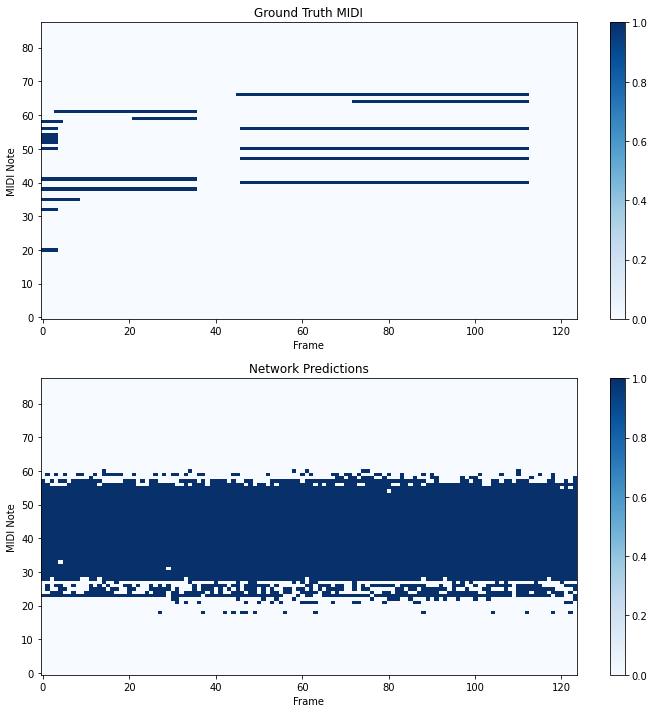

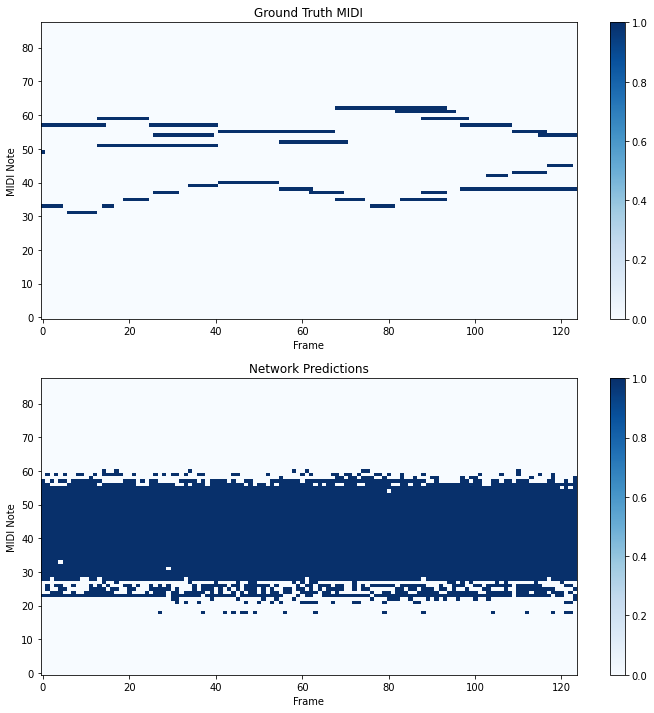

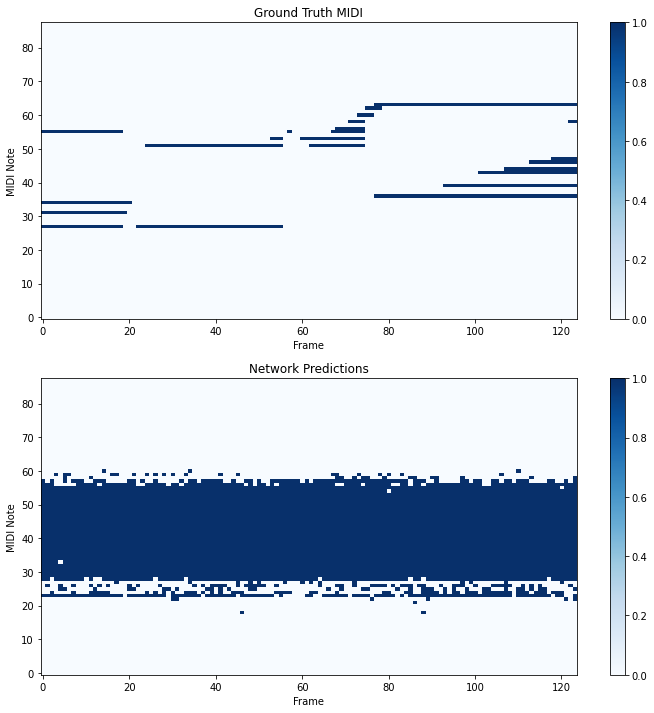

Epoch:0 | batch #525 | Val Acc:0.6569218393613555 | Val Loss:0.7262337803840637
Computing epoch 1...
Epoch:1 | batch #525 | Train Acc:0.7649800074477466 | Train Loss:0.9320141673088074


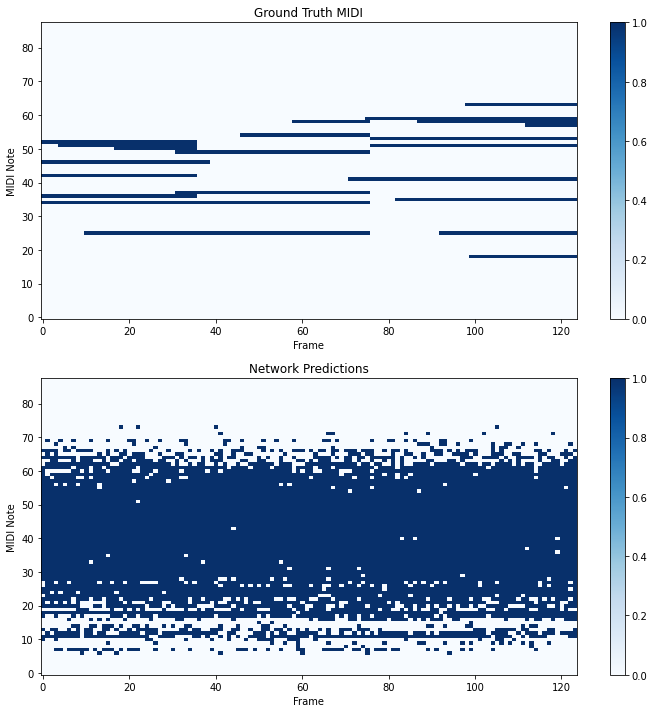

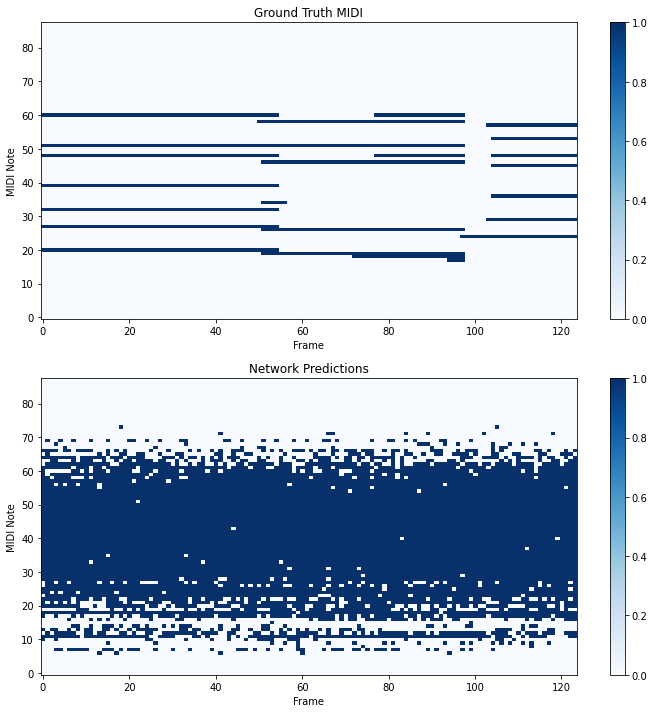

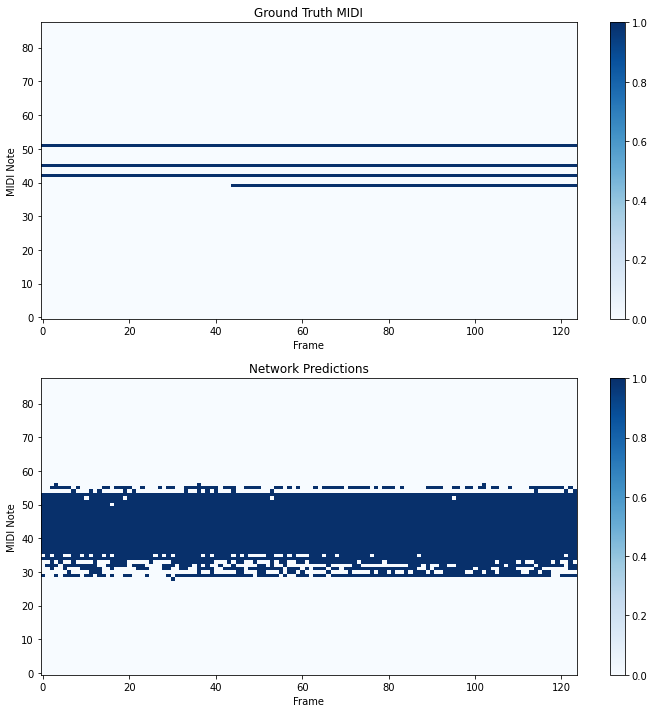

Epoch:1 | batch #525 | Val Acc:0.6181797816878463 | Val Loss:0.7146029472351074
Computing epoch 2...
Epoch:2 | batch #525 | Train Acc:0.777316762090958 | Train Loss:0.7076798677444458


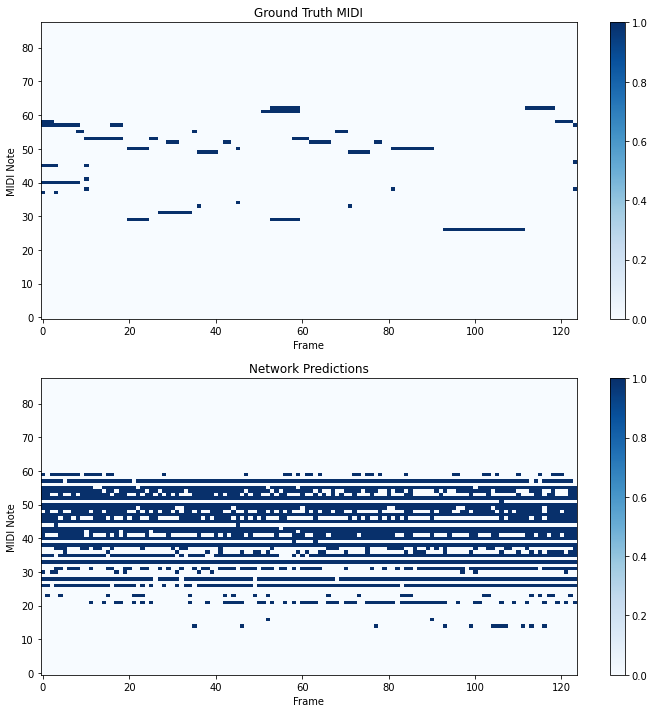

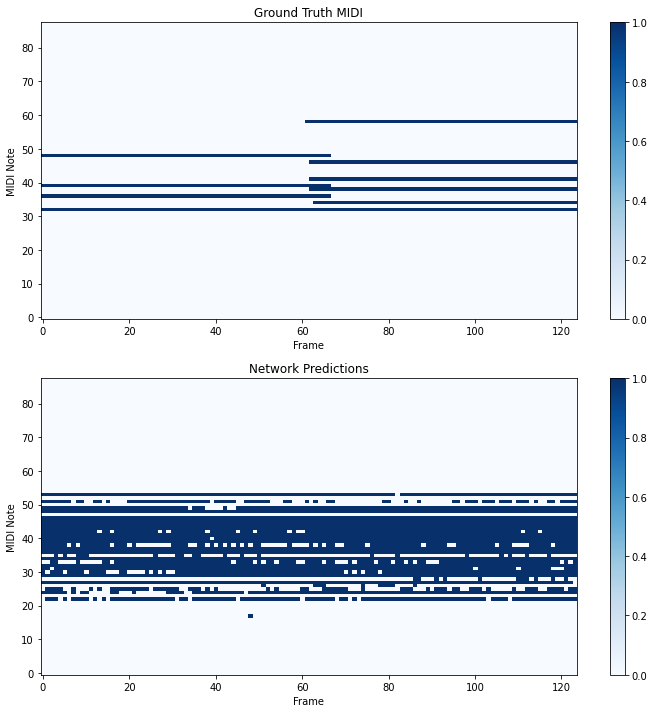

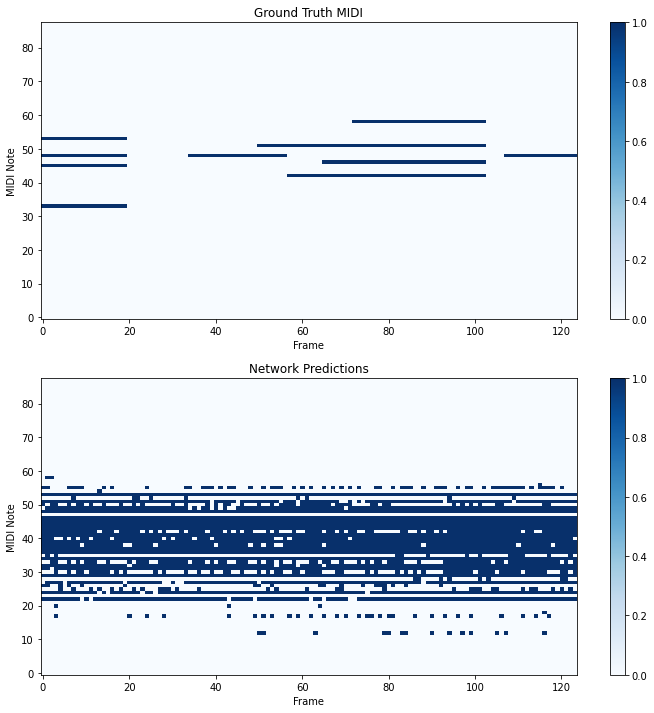

Epoch:2 | batch #525 | Val Acc:0.6686488880742915 | Val Loss:0.6856432557106018
Computing epoch 3...
Epoch:3 | batch #525 | Train Acc:0.8031974002699792 | Train Loss:0.7505219578742981


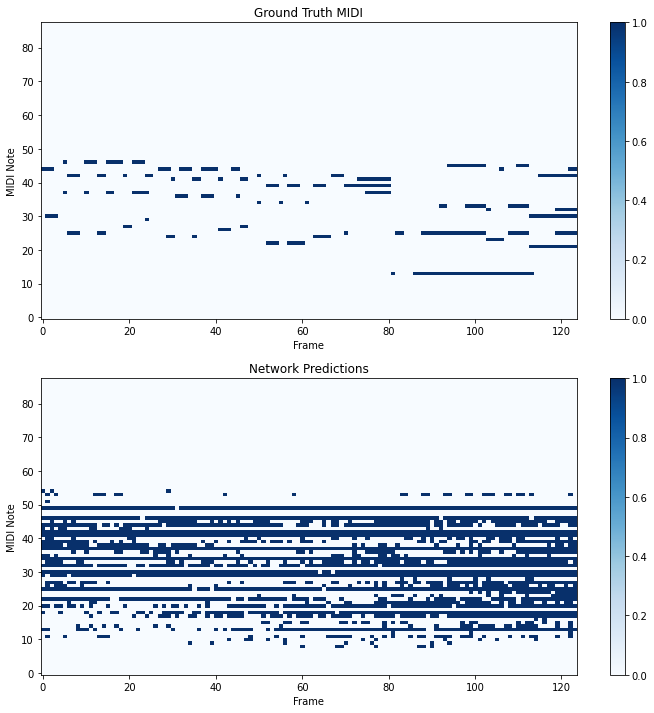

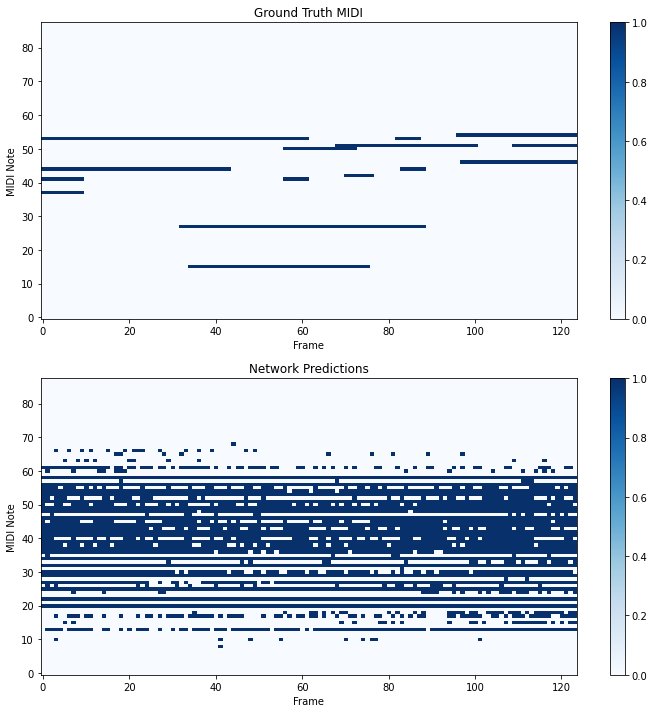

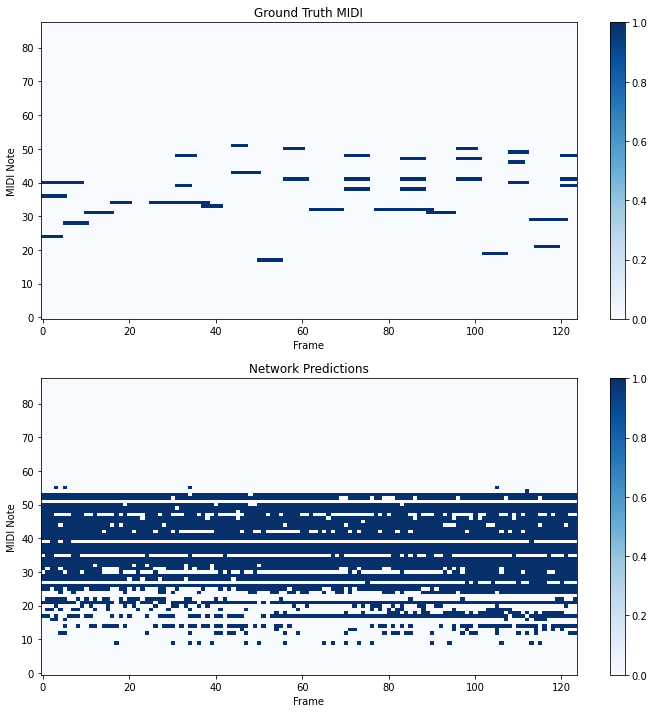

Epoch:3 | batch #525 | Val Acc:0.6986392147279243 | Val Loss:0.6957582235336304
Computing epoch 4...
Epoch:4 | batch #525 | Train Acc:0.8159862594842434 | Train Loss:0.7484458684921265


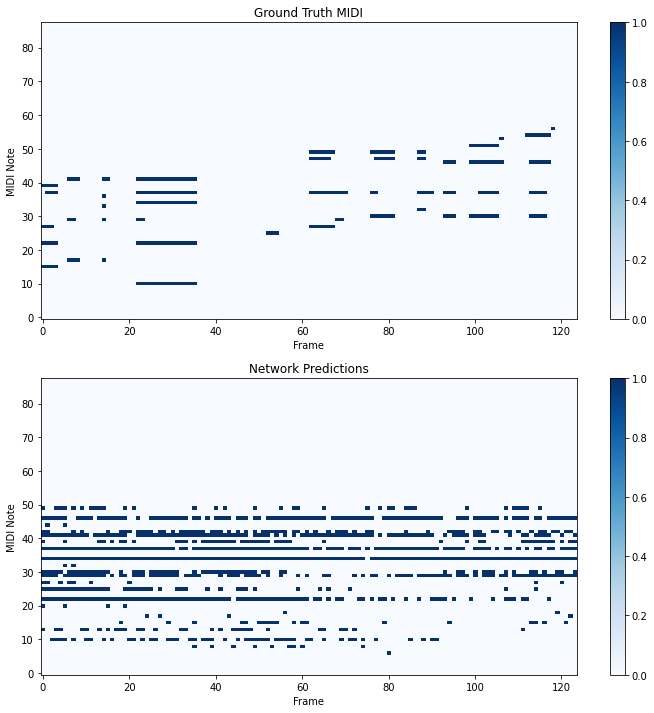

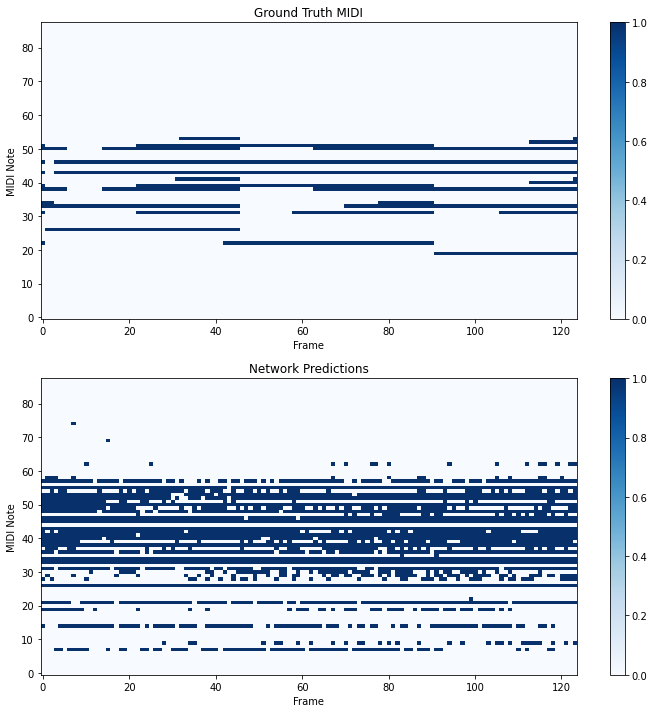

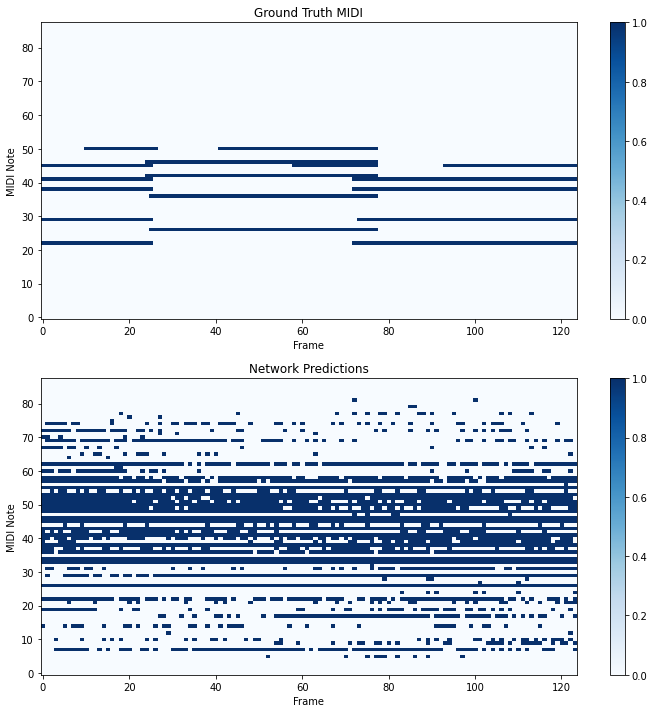

Epoch:4 | batch #525 | Val Acc:0.7922172328119909 | Val Loss:0.5486606955528259
Computing epoch 5...
Epoch:5 | batch #525 | Train Acc:0.8252611047107015 | Train Loss:0.7718037962913513


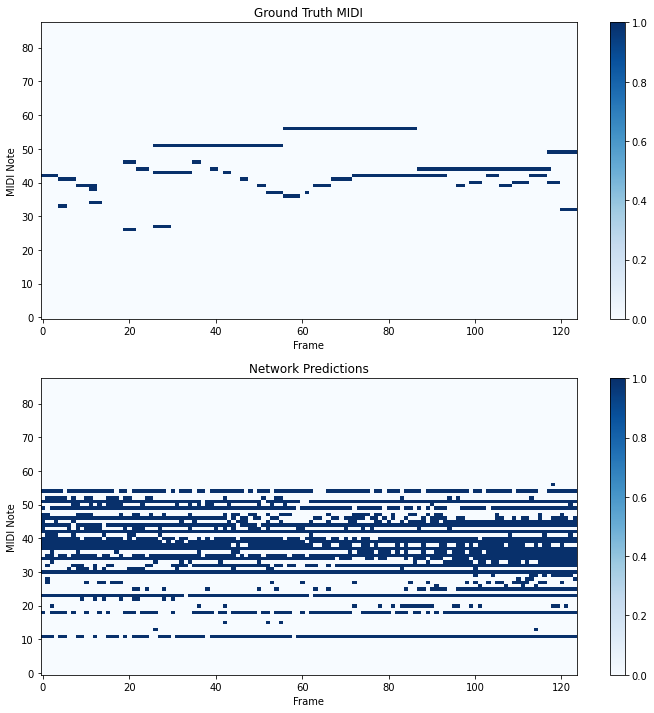

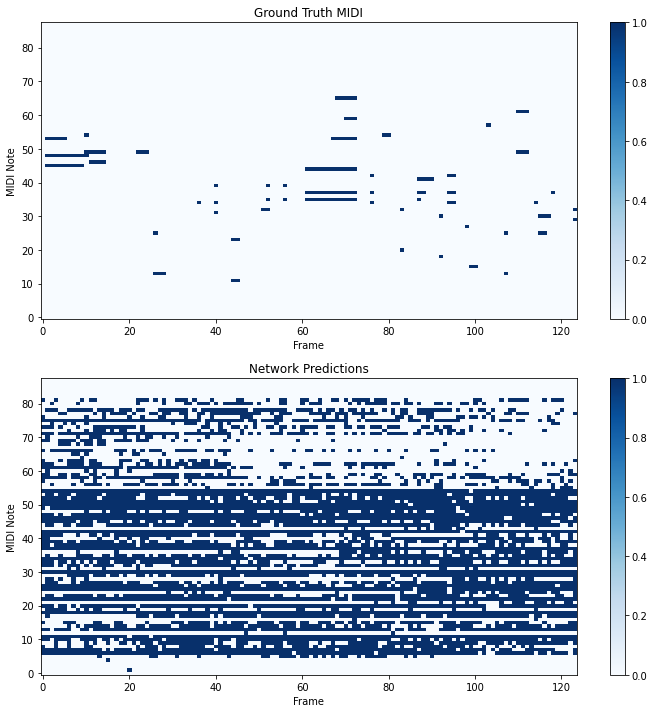

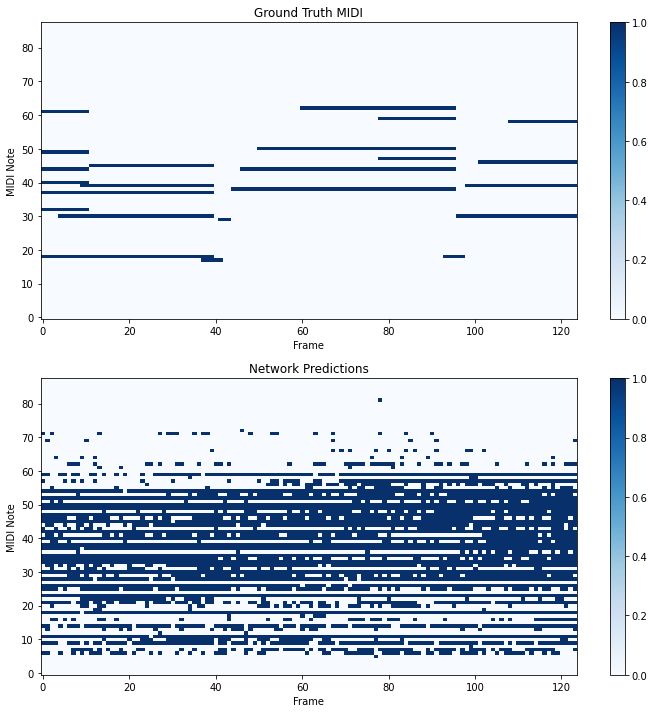

Epoch:5 | batch #525 | Val Acc:0.7864032461713911 | Val Loss:0.5294741988182068
Computing epoch 6...
Epoch:6 | batch #525 | Train Acc:0.8342947825024432 | Train Loss:0.7074391841888428


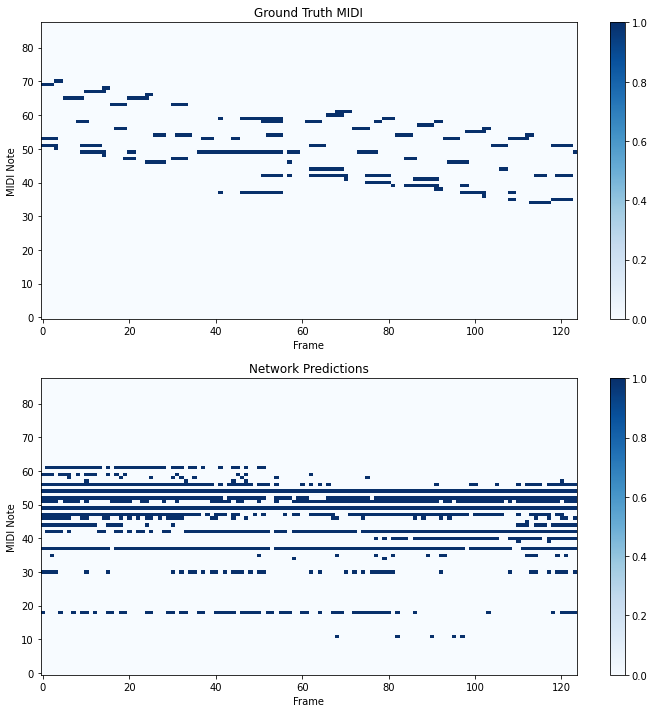

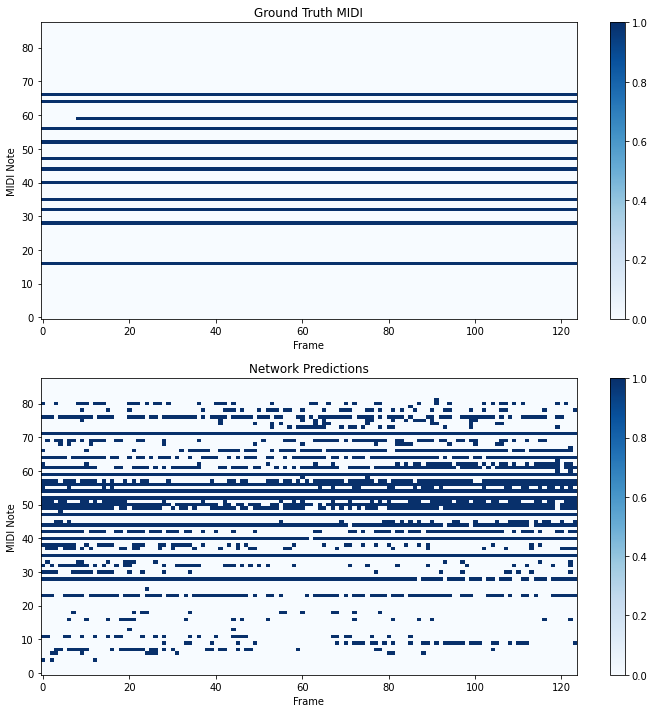

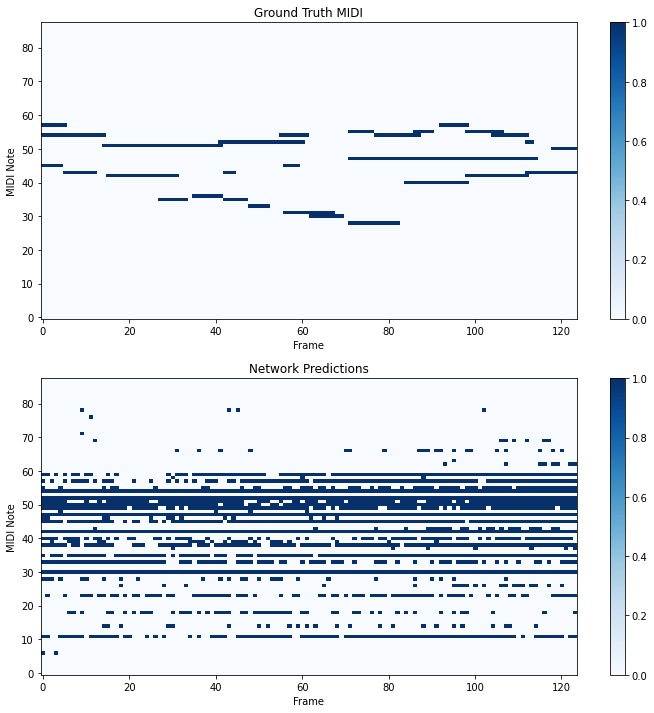

Epoch:6 | batch #525 | Val Acc:0.7753220715216683 | Val Loss:0.6227102279663086
Computing epoch 7...
Epoch:7 | batch #525 | Train Acc:0.8374526136945496 | Train Loss:0.5961242318153381


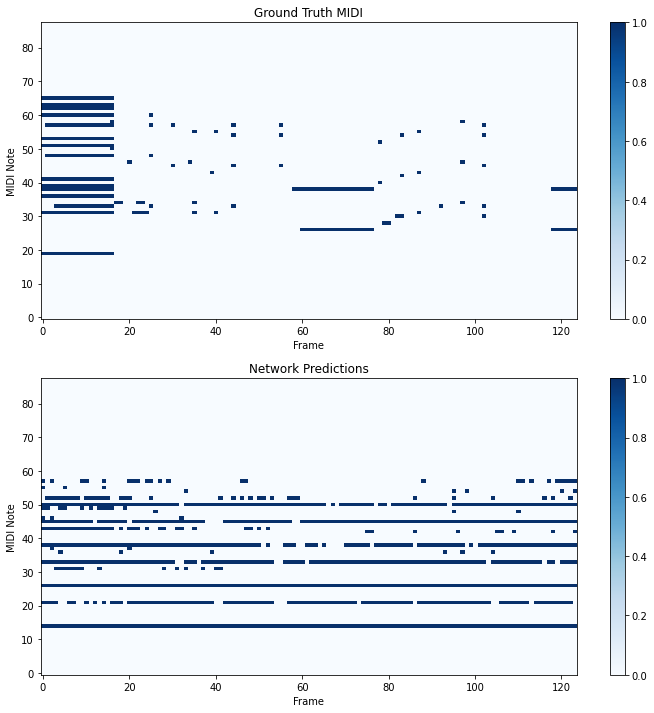

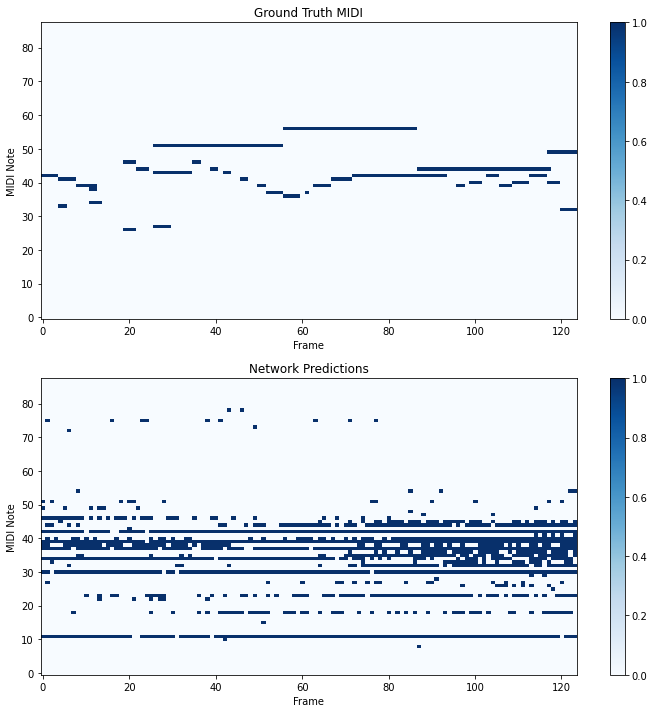

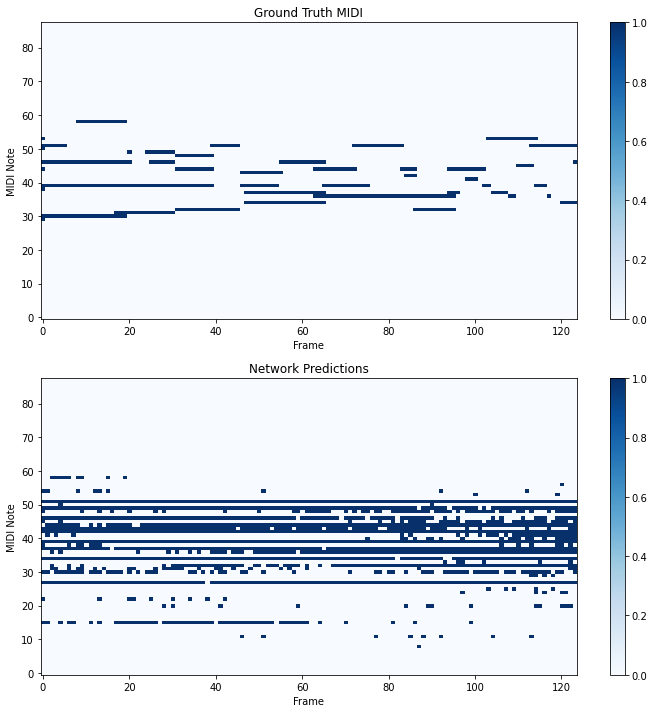

Epoch:7 | batch #525 | Val Acc:0.8010919680677746 | Val Loss:0.6195951104164124
Computing epoch 8...
Epoch:8 | batch #525 | Train Acc:0.8409537395847874 | Train Loss:0.6471178531646729


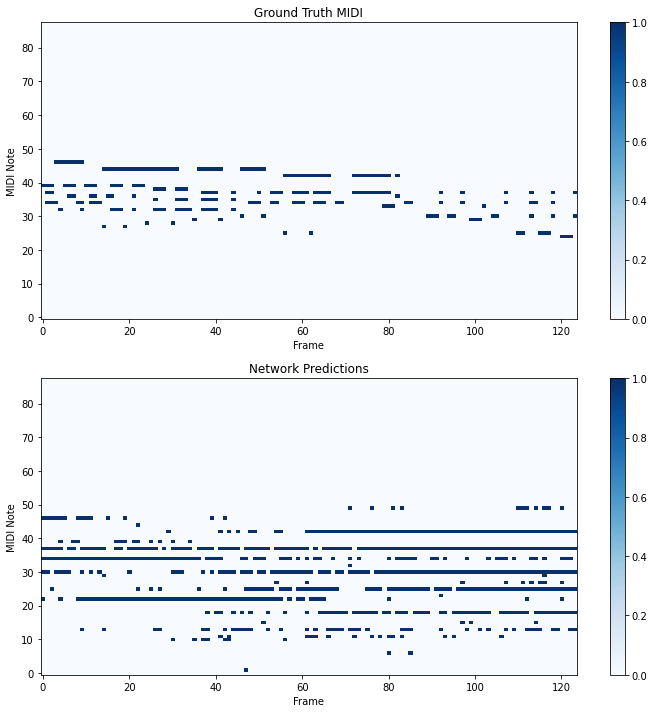

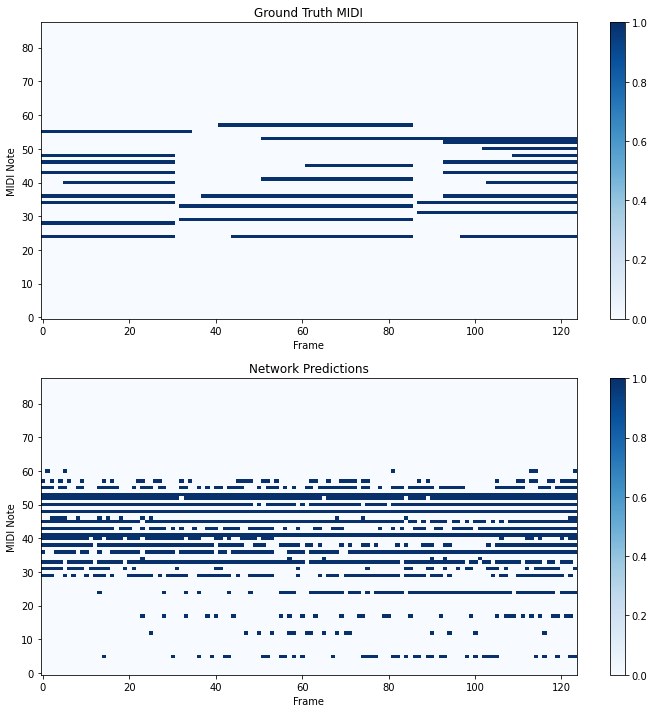

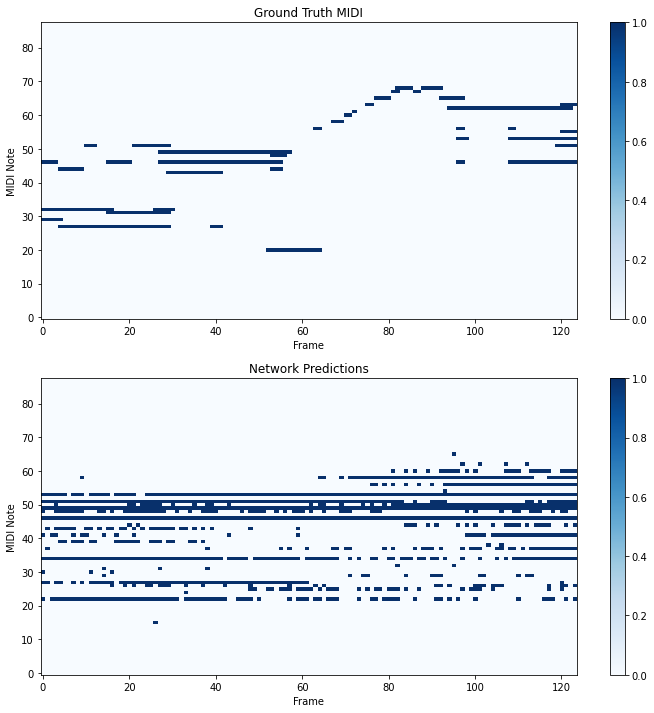

Epoch:8 | batch #525 | Val Acc:0.8847864736070381 | Val Loss:0.7196858525276184
Computing epoch 9...
Epoch:9 | batch #525 | Train Acc:0.8471851027556667 | Train Loss:1.0313916206359863


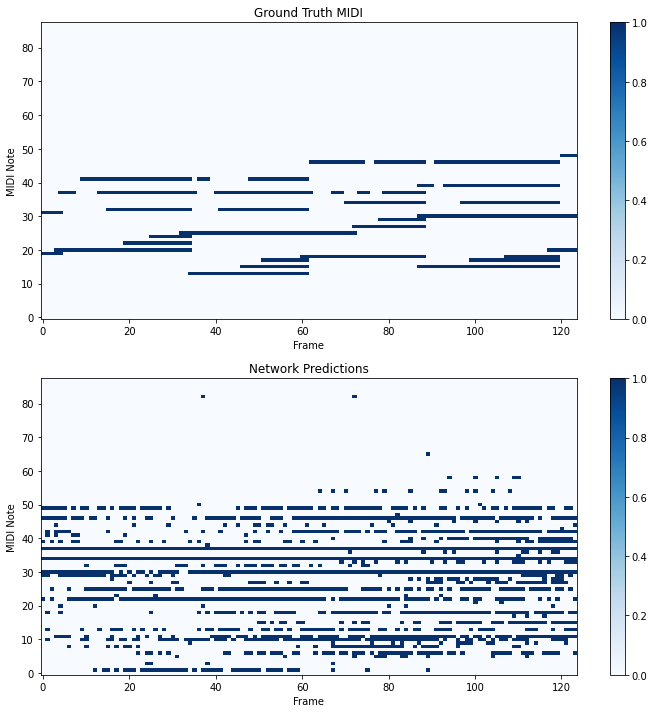

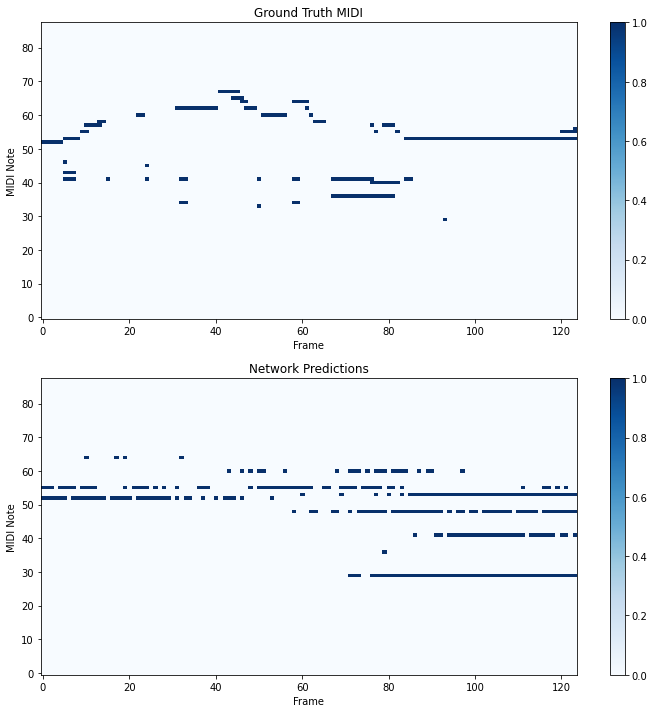

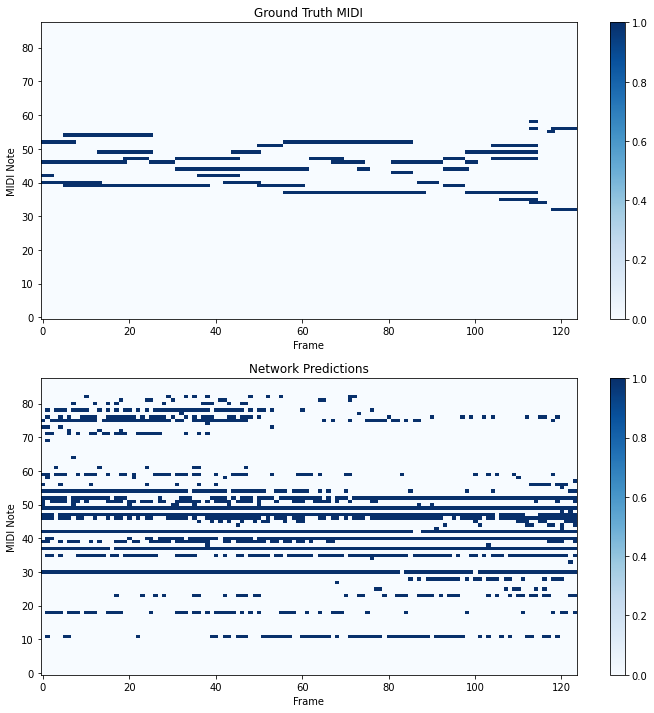

Epoch:9 | batch #525 | Val Acc:0.9060809710003256 | Val Loss:0.5427873134613037
Computing epoch 10...
Epoch:10 | batch #525 | Train Acc:0.8502942471954567 | Train Loss:0.5824931263923645


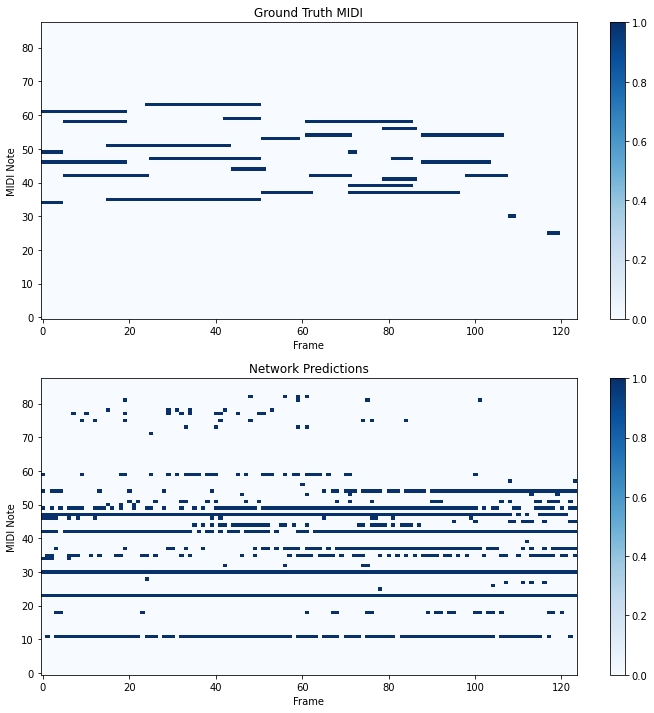

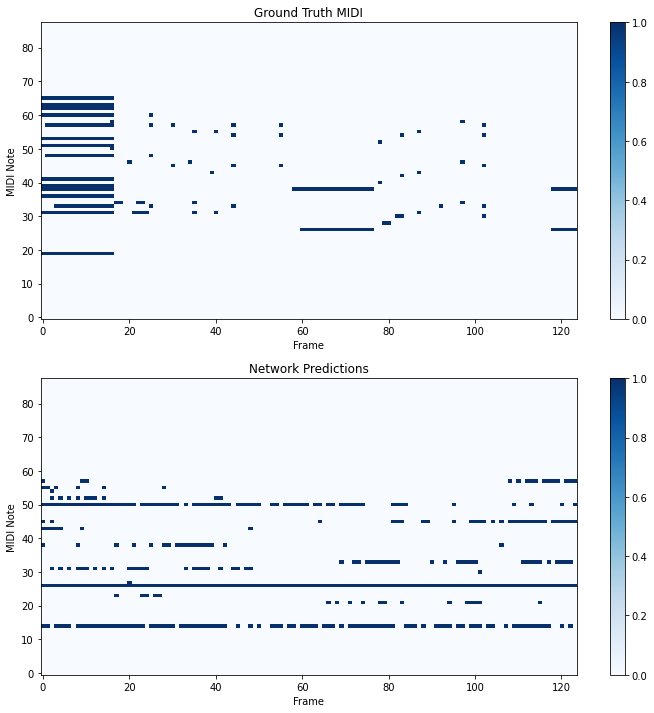

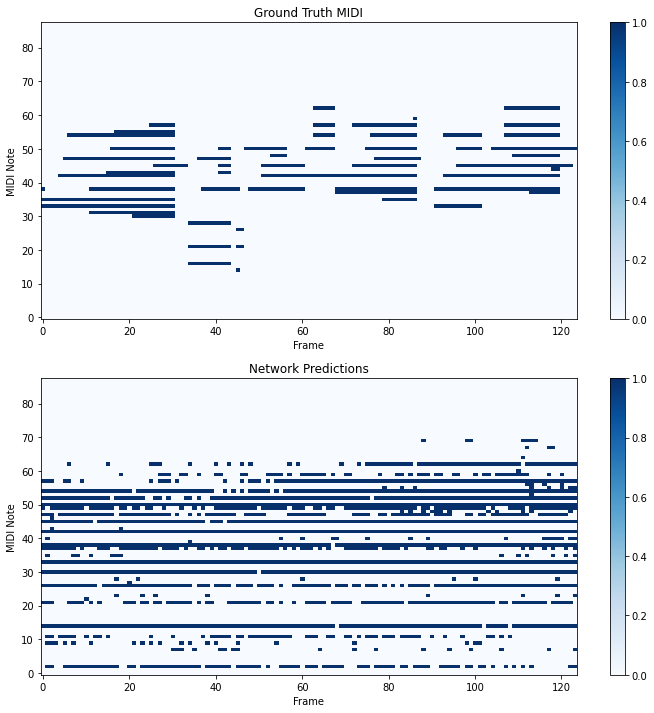

Epoch:10 | batch #525 | Val Acc:0.8866772564353209 | Val Loss:0.6185231804847717
Computing epoch 11...
Epoch:11 | batch #525 | Train Acc:0.8540769794721409 | Train Loss:0.6204836964607239


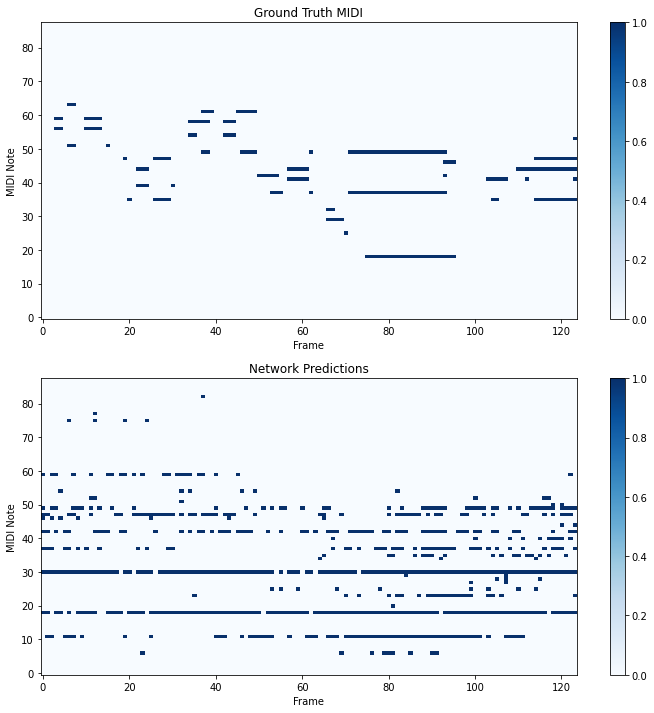

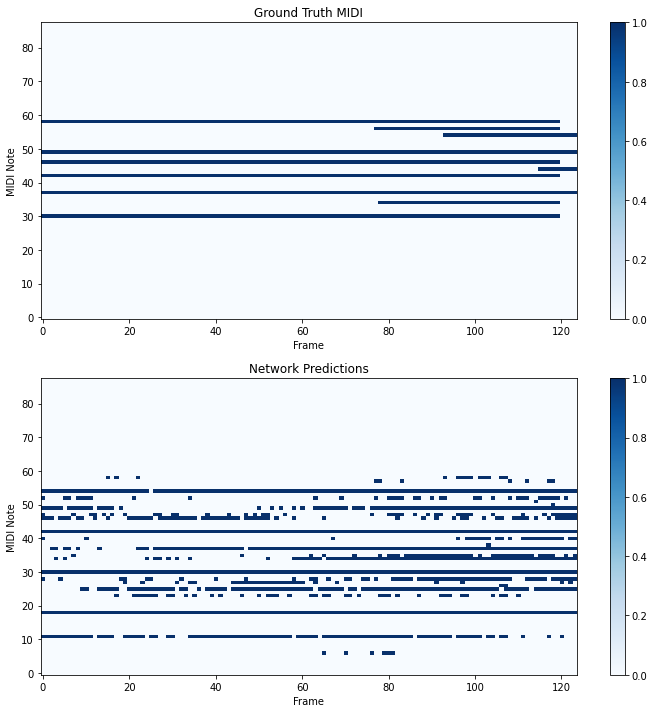

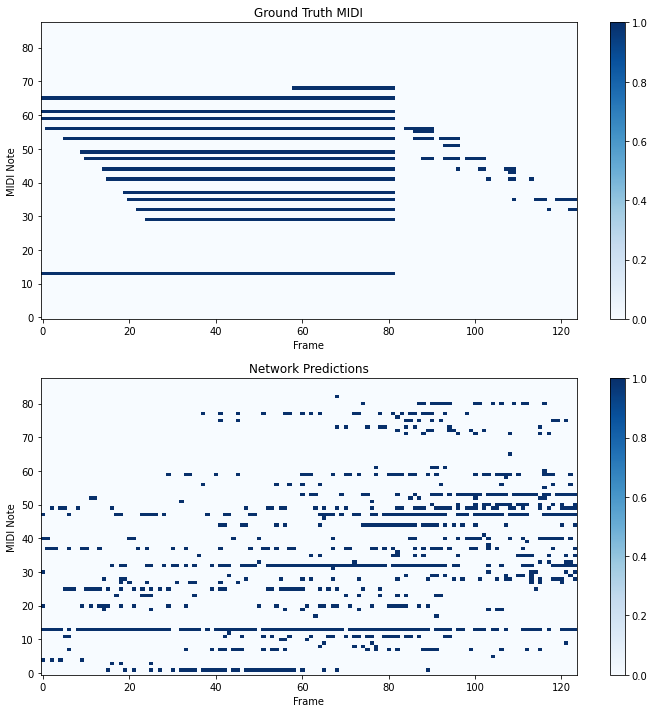

Epoch:11 | batch #525 | Val Acc:0.9080930270446398 | Val Loss:0.6203579306602478
Computing epoch 12...
Epoch:12 | batch #525 | Train Acc:0.8574283939626697 | Train Loss:0.6571226119995117


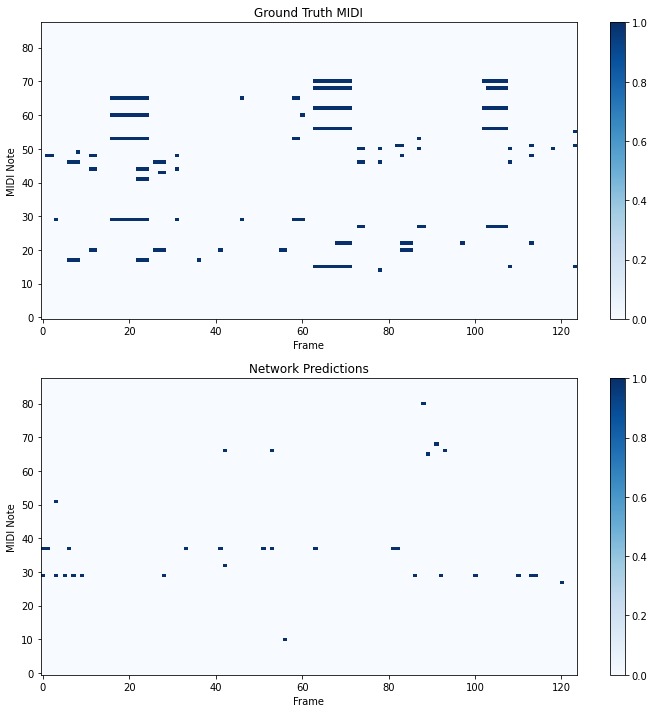

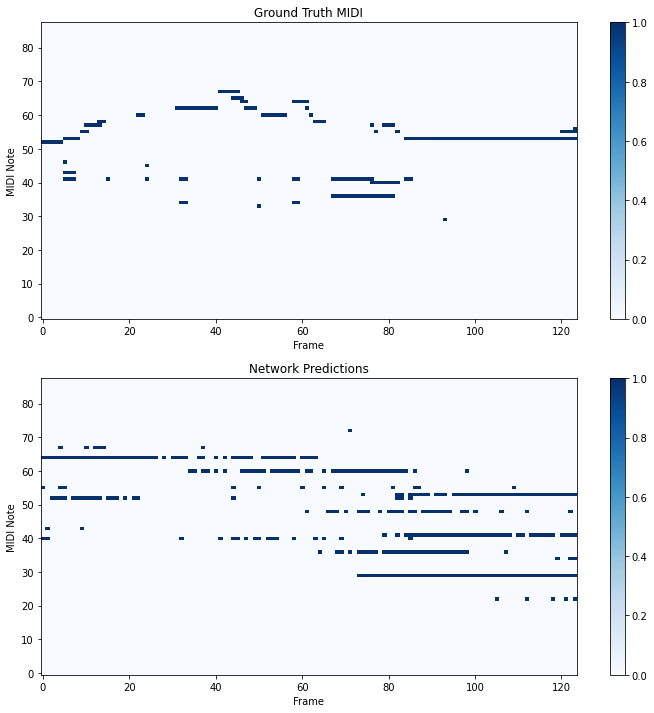

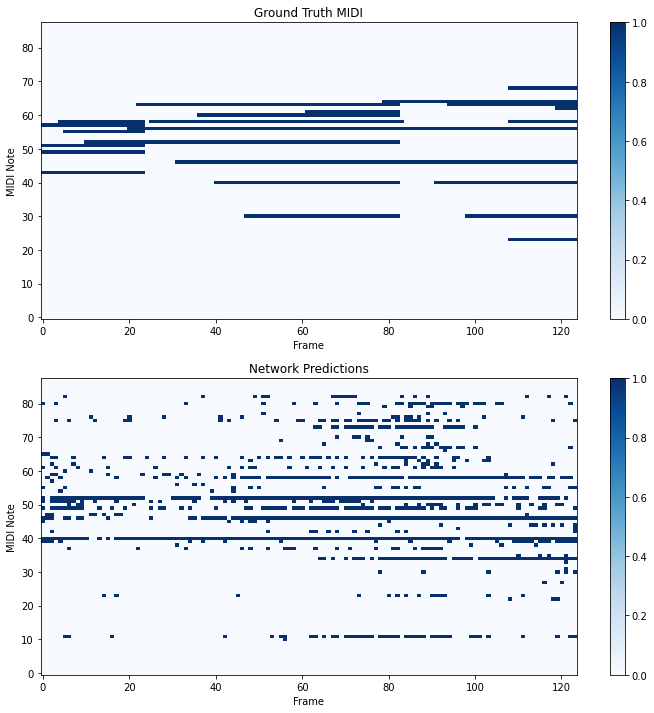

Epoch:12 | batch #525 | Val Acc:0.9215989532420983 | Val Loss:0.9431446194648743
Computing epoch 13...
Epoch:13 | batch #525 | Train Acc:0.8590955697528284 | Train Loss:0.6901552081108093


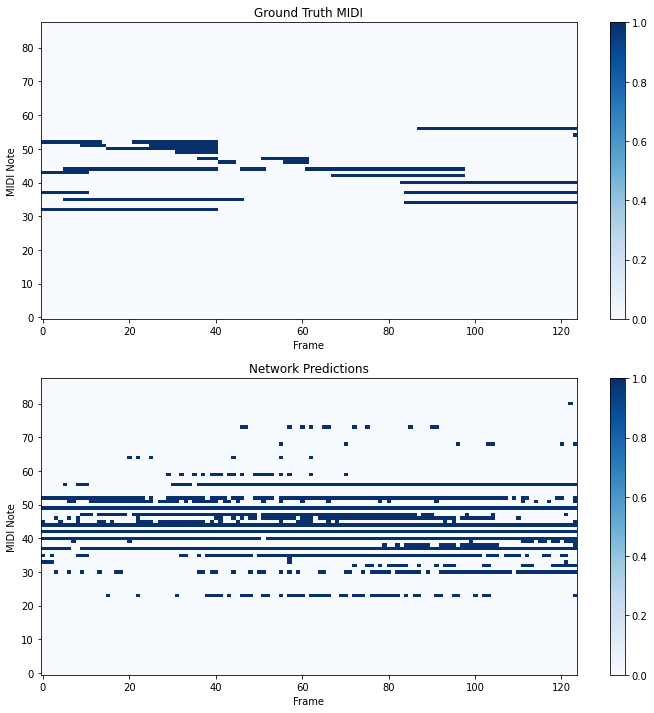

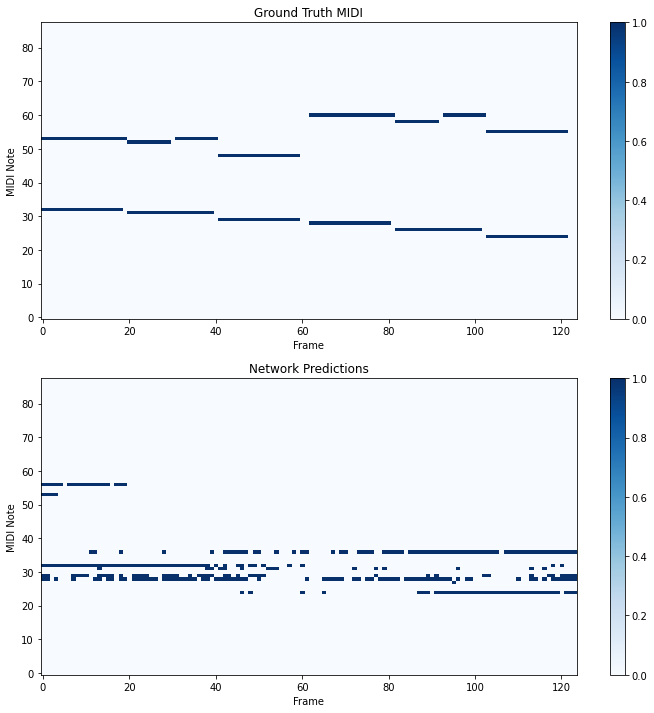

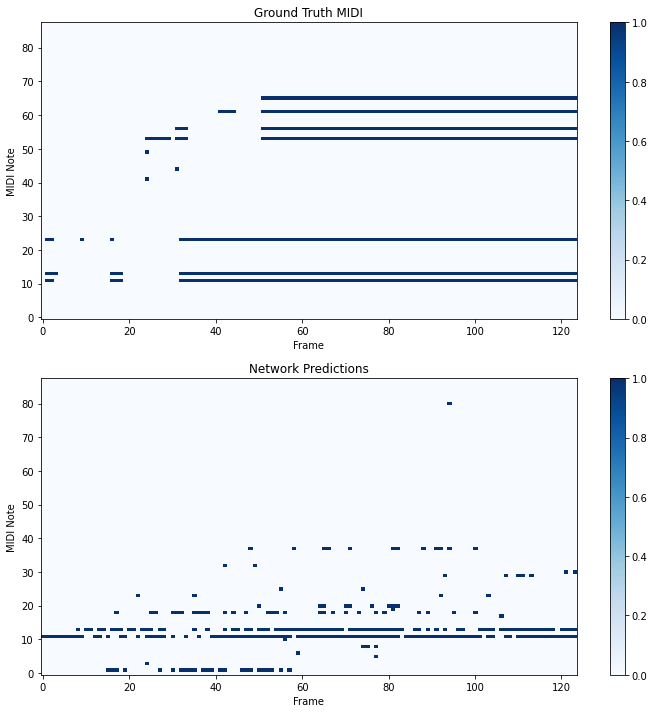

Epoch:13 | batch #525 | Val Acc:0.9250382860866732 | Val Loss:0.4985317289829254
Computing epoch 14...
Epoch:14 | batch #525 | Train Acc:0.8633146470465004 | Train Loss:0.5503475069999695


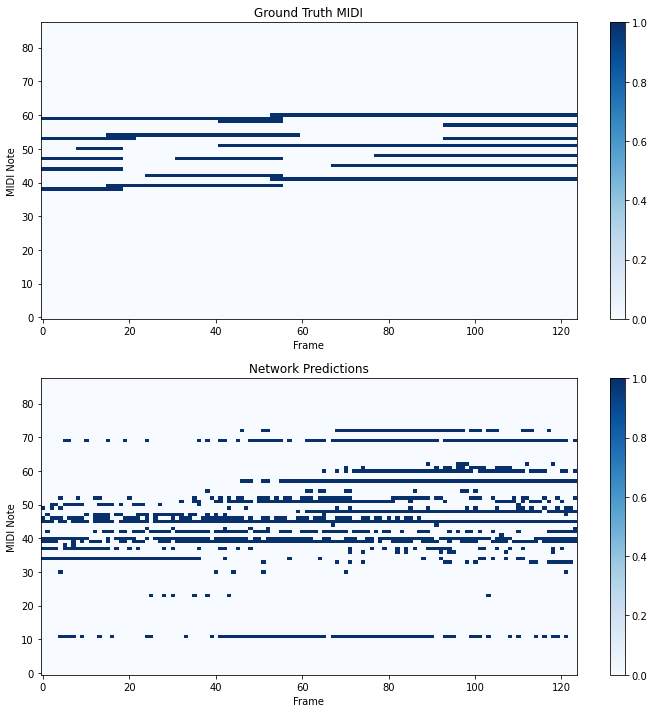

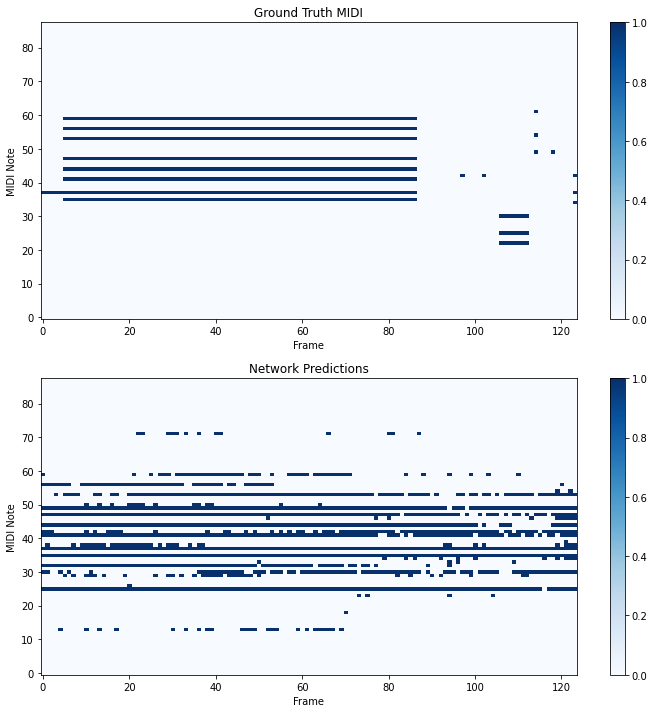

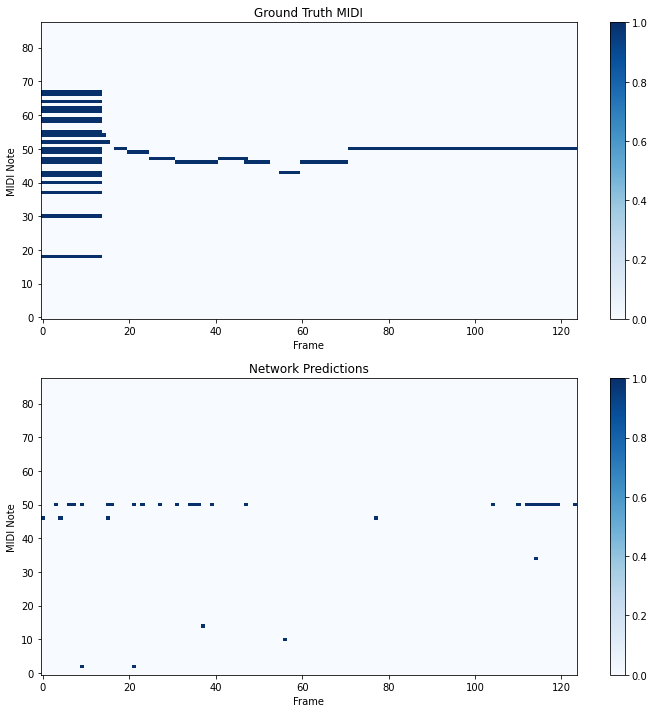

Epoch:14 | batch #525 | Val Acc:0.9290874470511568 | Val Loss:0.8119527101516724
Computing epoch 15...
Epoch:15 | batch #525 | Train Acc:0.8663453050086113 | Train Loss:0.5201808214187622


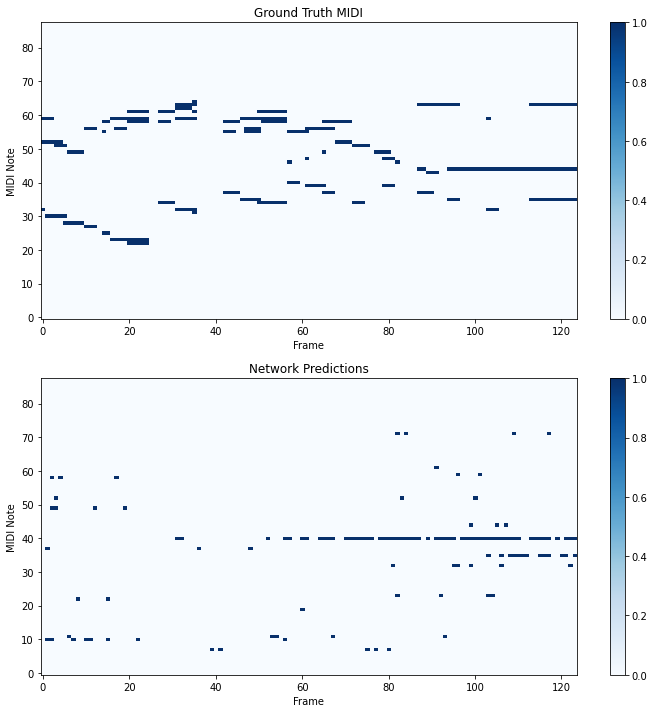

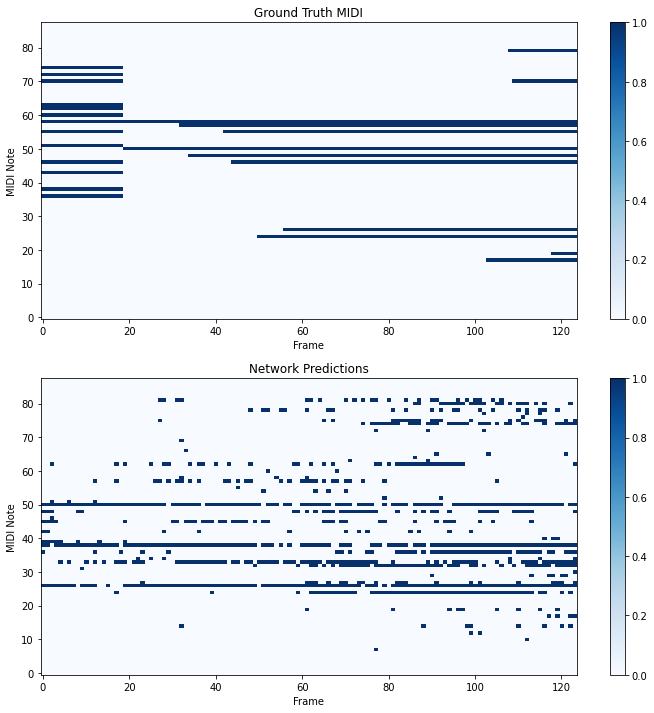

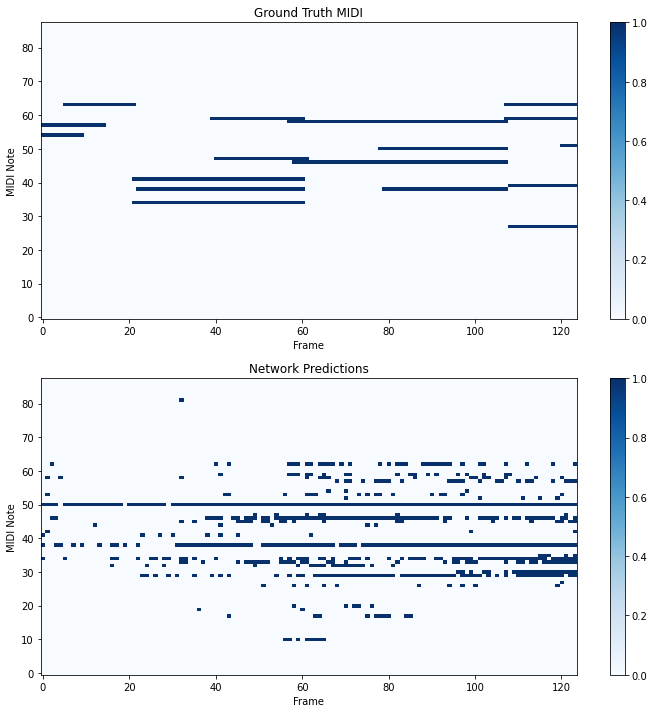

Epoch:15 | batch #525 | Val Acc:0.9113114002932552 | Val Loss:0.5051906108856201
Computing epoch 16...
Epoch:16 | batch #525 | Train Acc:0.8670369245449899 | Train Loss:0.5490815043449402


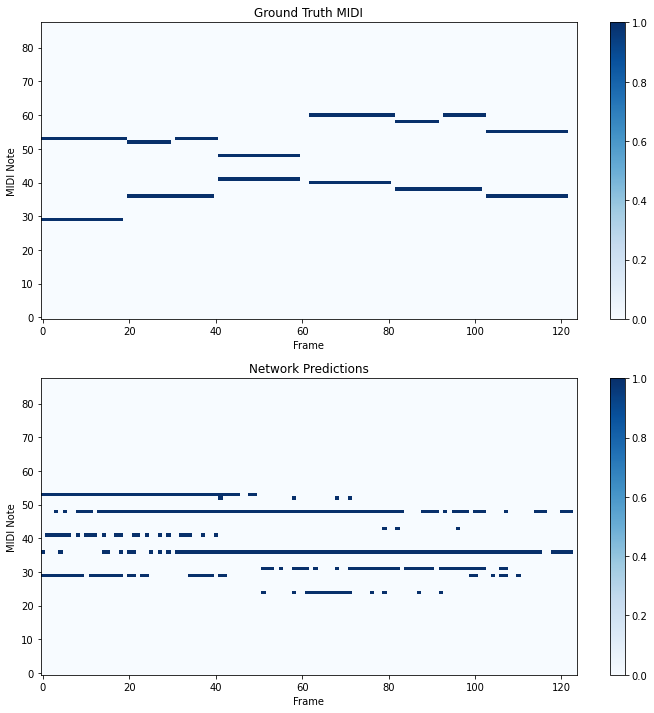

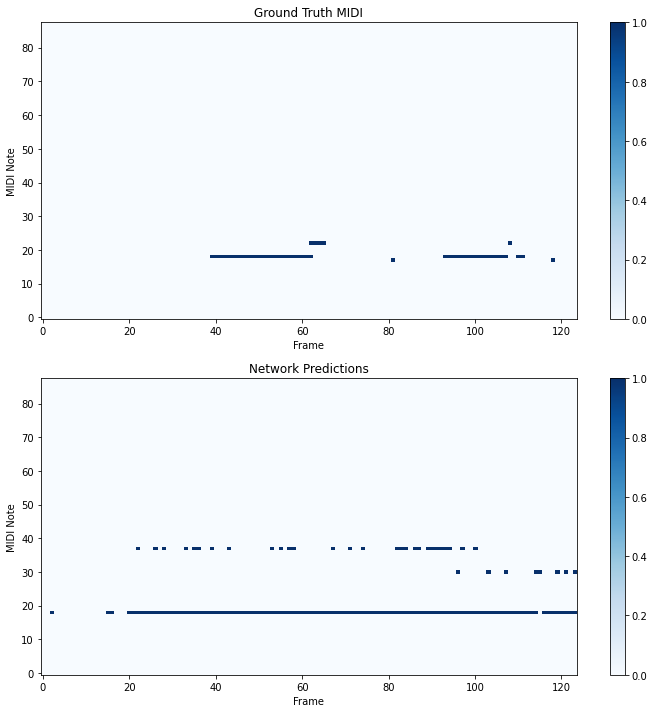

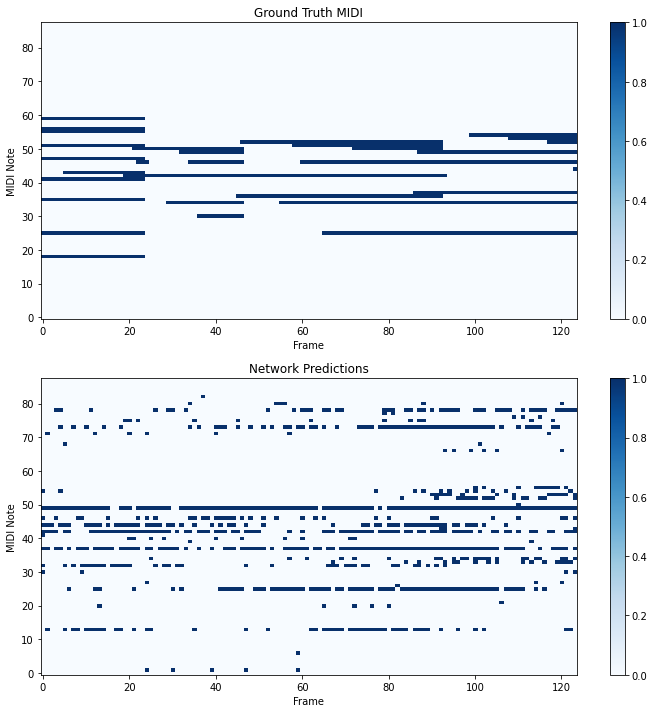

Epoch:16 | batch #525 | Val Acc:0.9162526474421636 | Val Loss:0.9143840074539185
Computing epoch 17...
Epoch:17 | batch #525 | Train Acc:0.8709105019084855 | Train Loss:0.5718613862991333


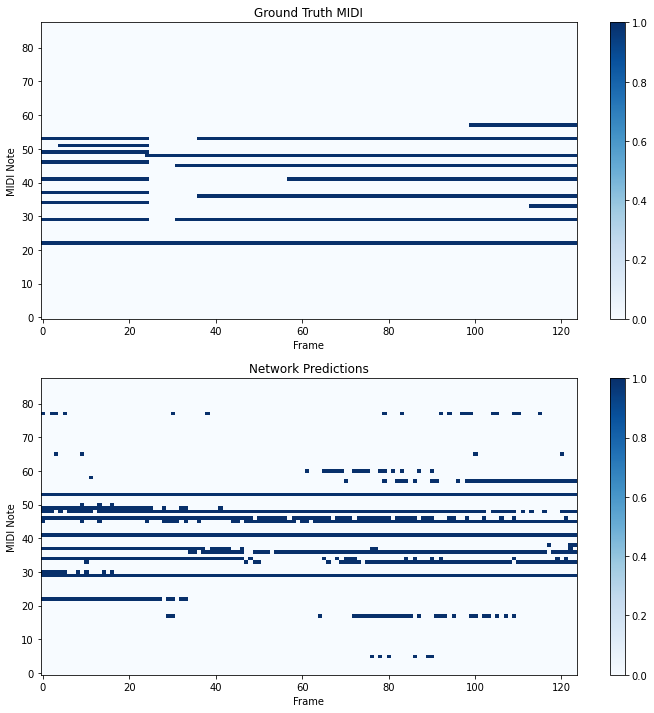

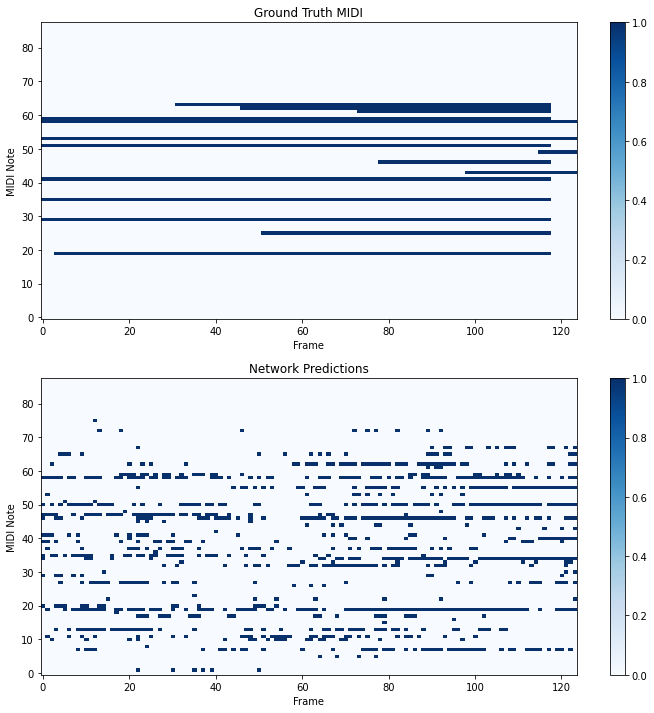

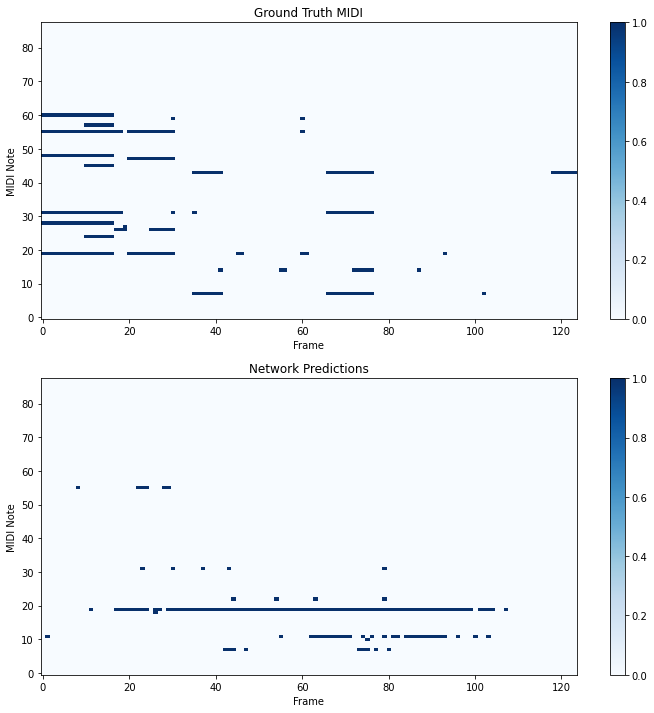

Epoch:17 | batch #525 | Val Acc:0.9126752403062888 | Val Loss:0.6855116486549377
Computing epoch 18...
Epoch:18 | batch #525 | Train Acc:0.8722519230321649 | Train Loss:0.48328331112861633


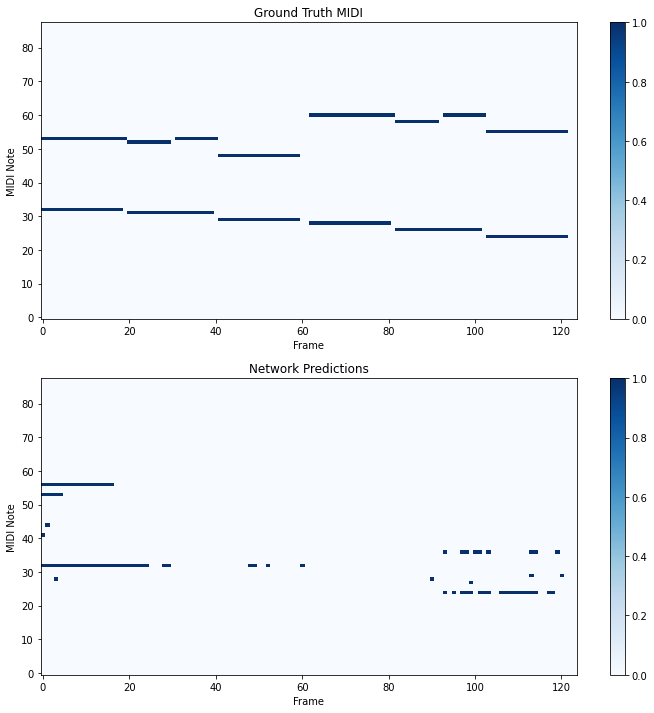

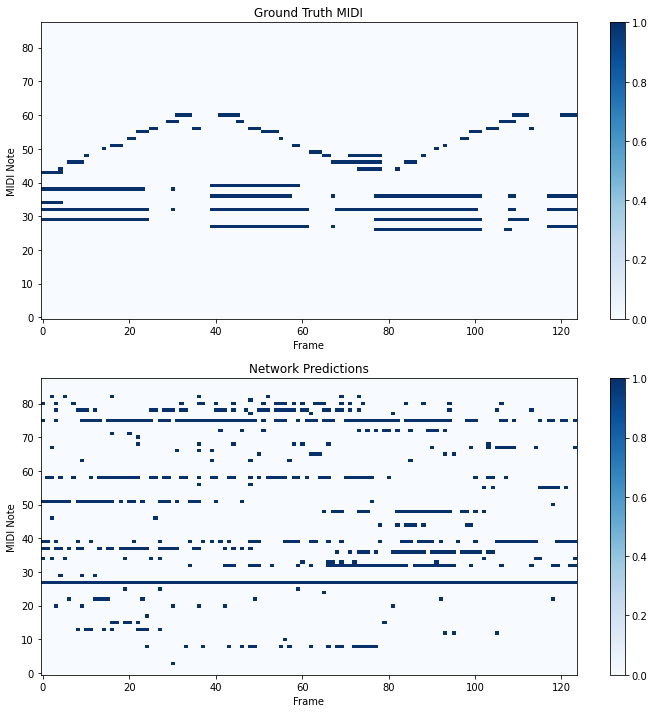

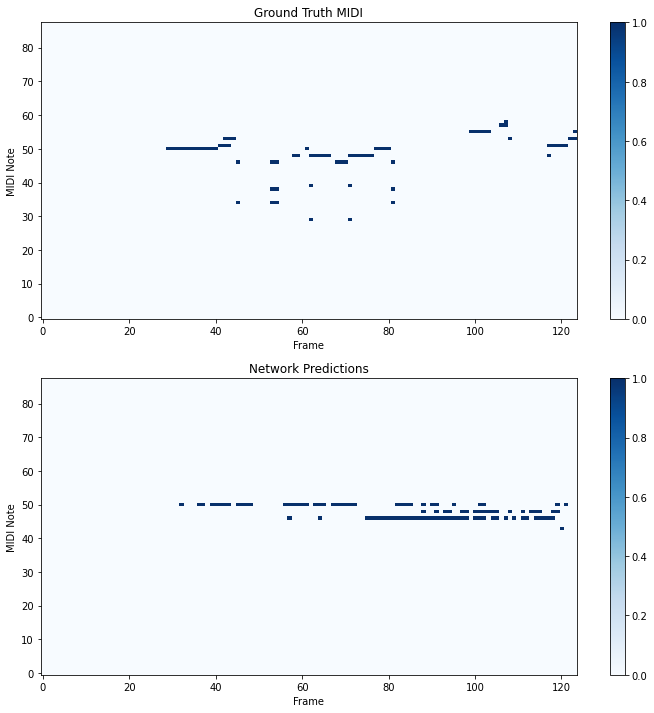

Epoch:18 | batch #525 | Val Acc:0.9373243523949171 | Val Loss:0.6994400024414062
Computing epoch 19...
Epoch:19 | batch #525 | Train Acc:0.8740008204161429 | Train Loss:0.5594483017921448


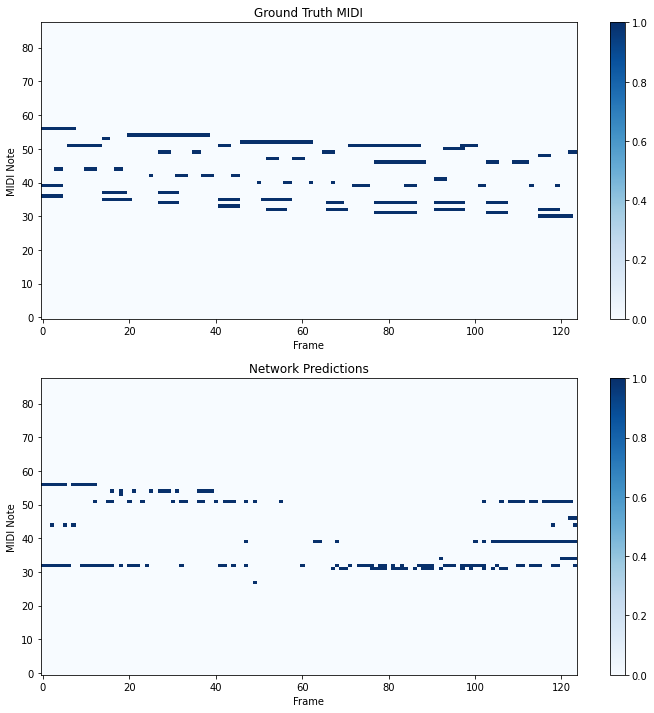

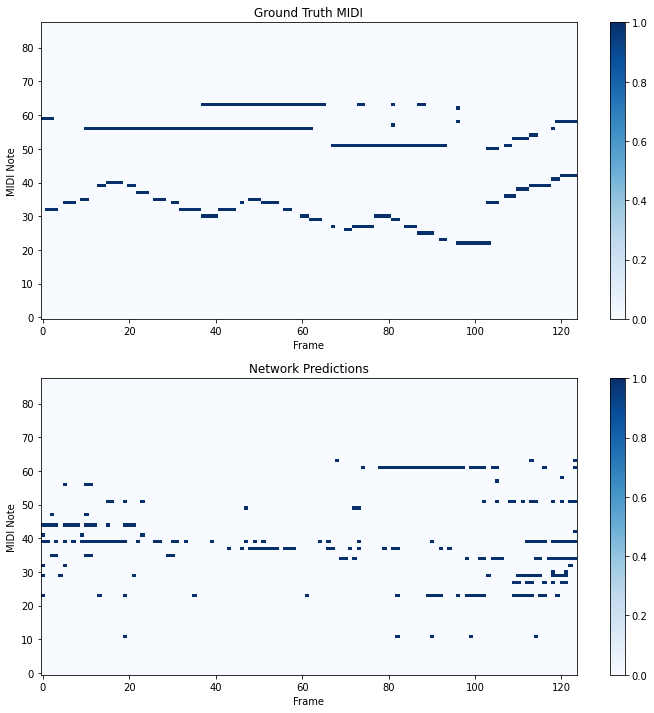

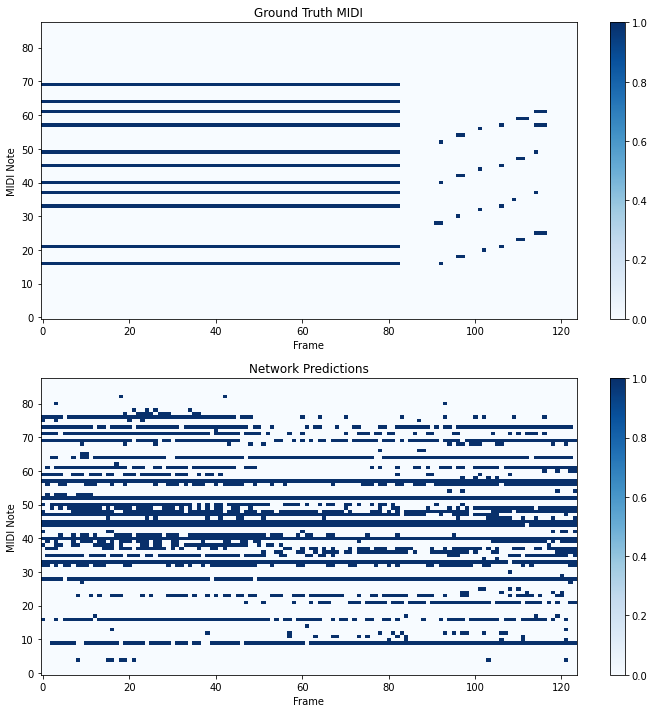

Epoch:19 | batch #525 | Val Acc:0.9074842171717173 | Val Loss:0.6792510747909546
Computing epoch 20...
Epoch:20 | batch #525 | Train Acc:0.8763742639528931 | Train Loss:0.5363160967826843


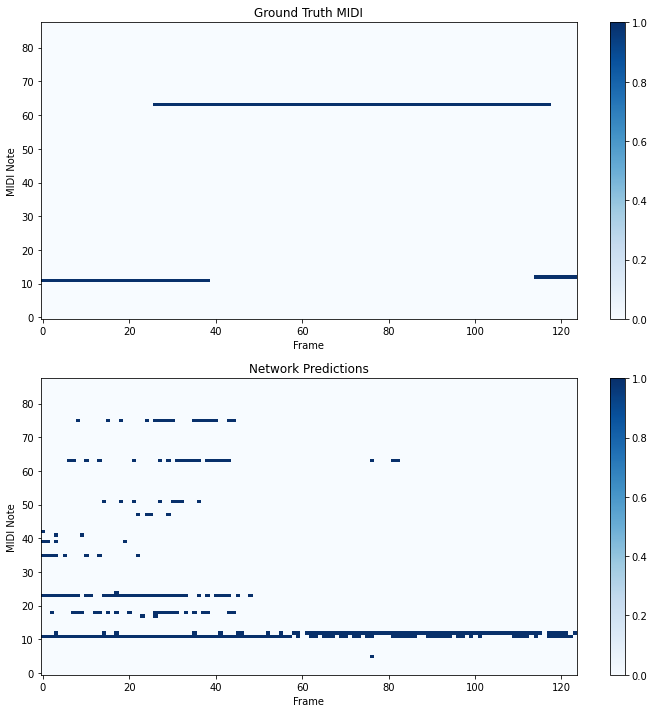

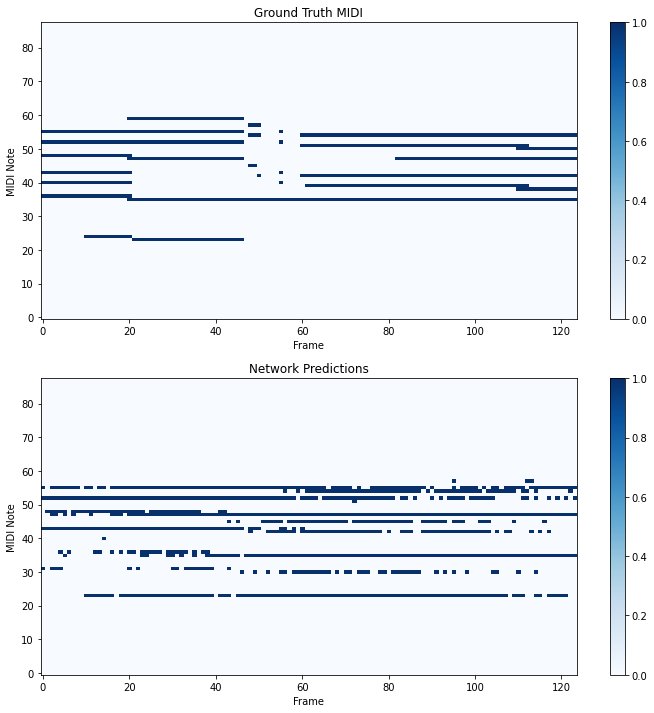

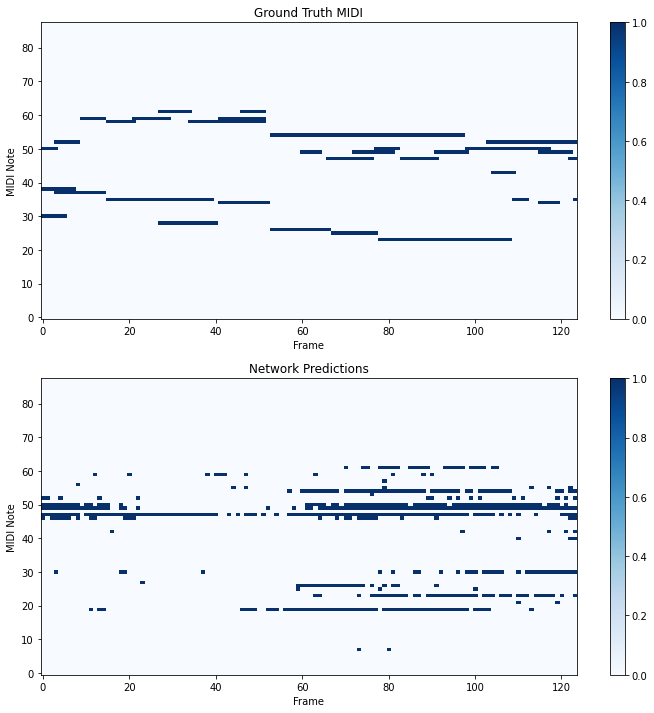

Epoch:20 | batch #525 | Val Acc:0.9091089320625613 | Val Loss:0.4638088643550873
Computing epoch 21...
Epoch:21 | batch #525 | Train Acc:0.8780742098403391 | Train Loss:0.516292154788971


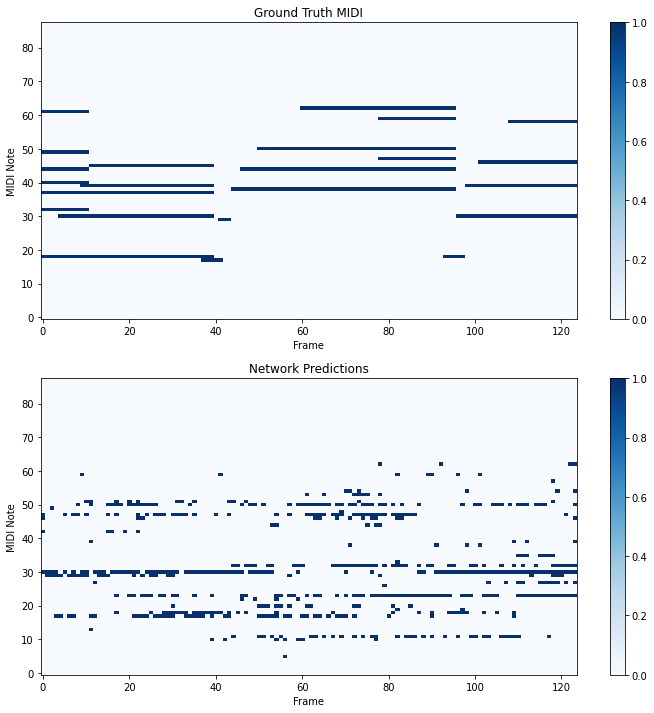

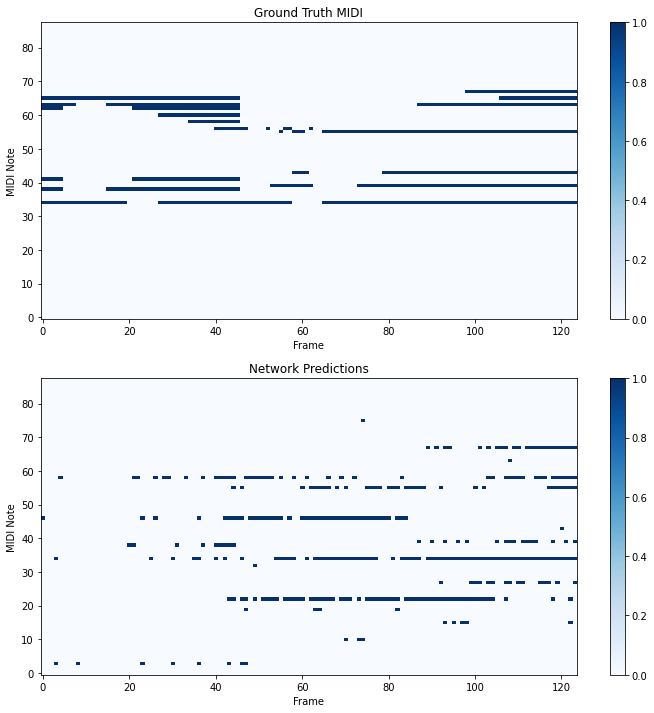

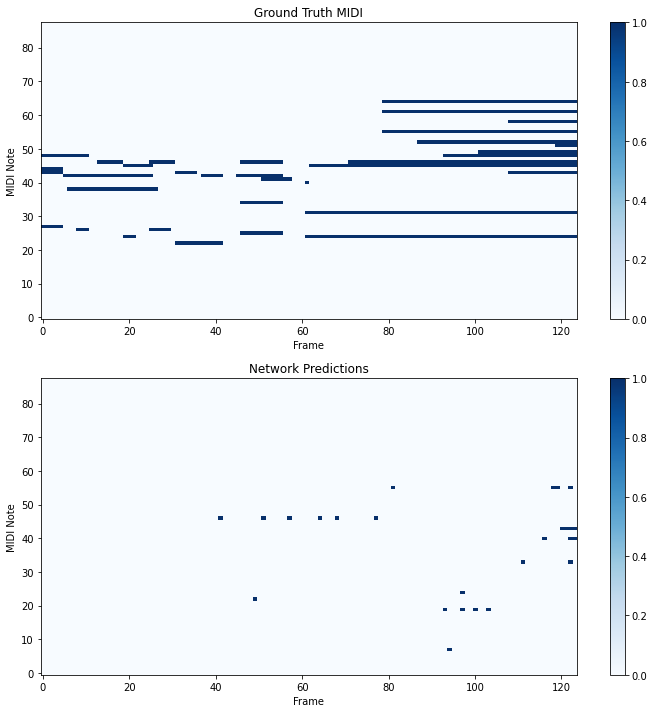

Epoch:21 | batch #525 | Val Acc:0.9277602639296186 | Val Loss:0.9660855531692505
Computing epoch 22...
Epoch:22 | batch #525 | Train Acc:0.8784690976586127 | Train Loss:0.5380706787109375


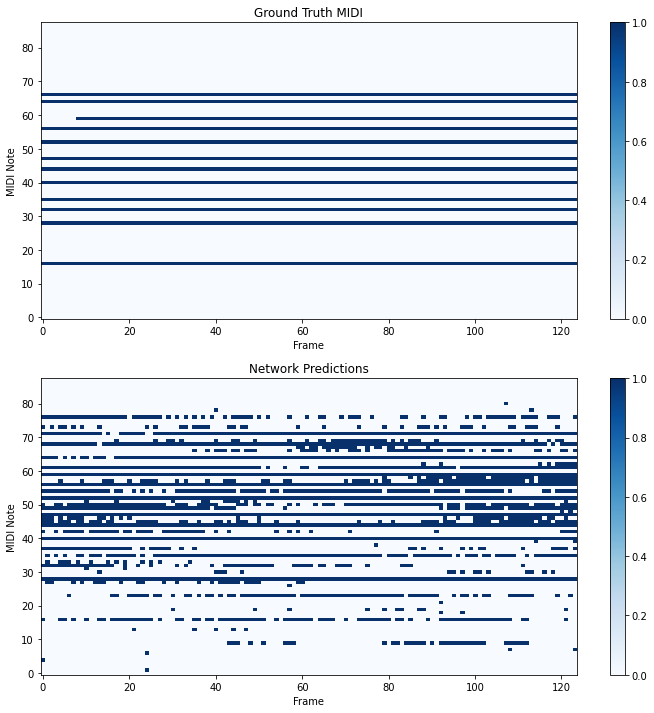

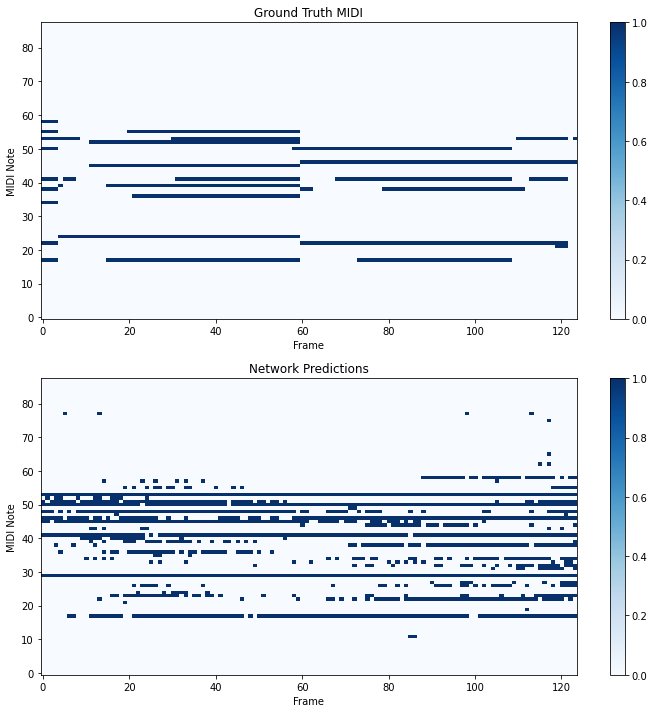

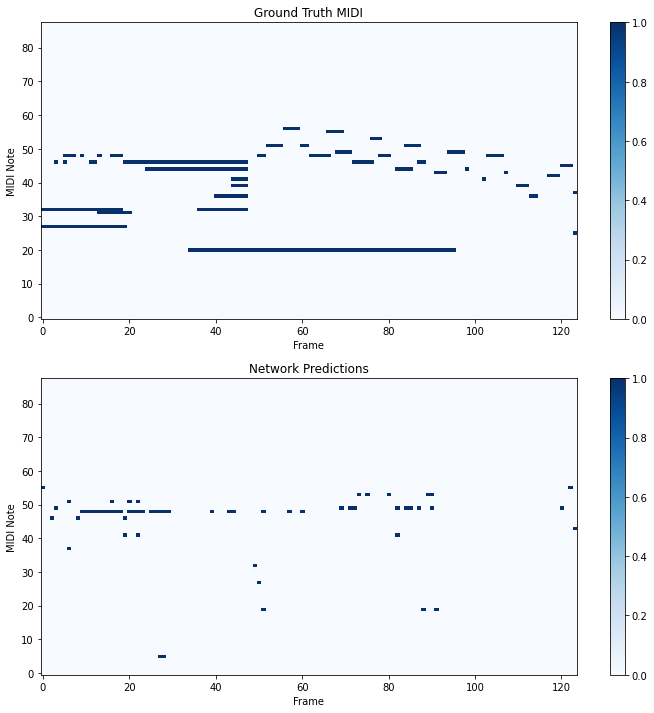

Epoch:22 | batch #525 | Val Acc:0.9108954463994787 | Val Loss:0.5393308401107788
Computing epoch 23...
Epoch:23 | batch #525 | Train Acc:0.8806984737932316 | Train Loss:0.675674557685852


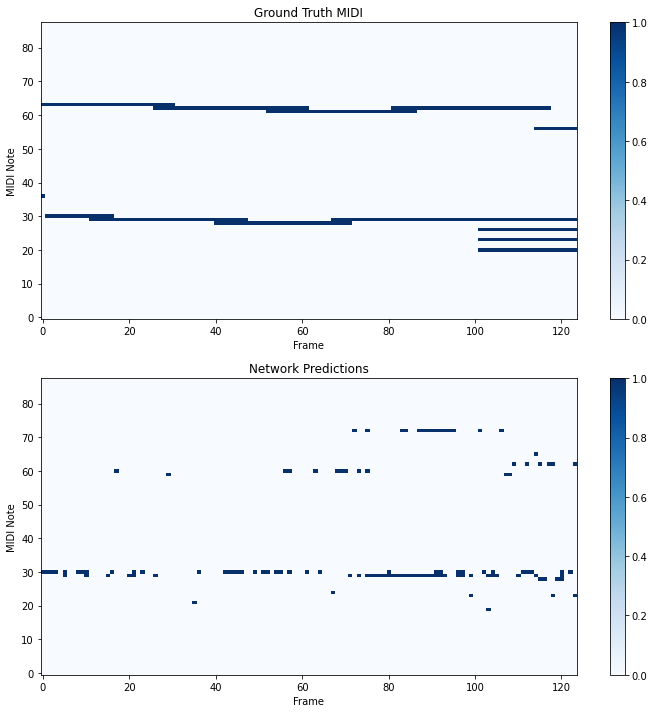

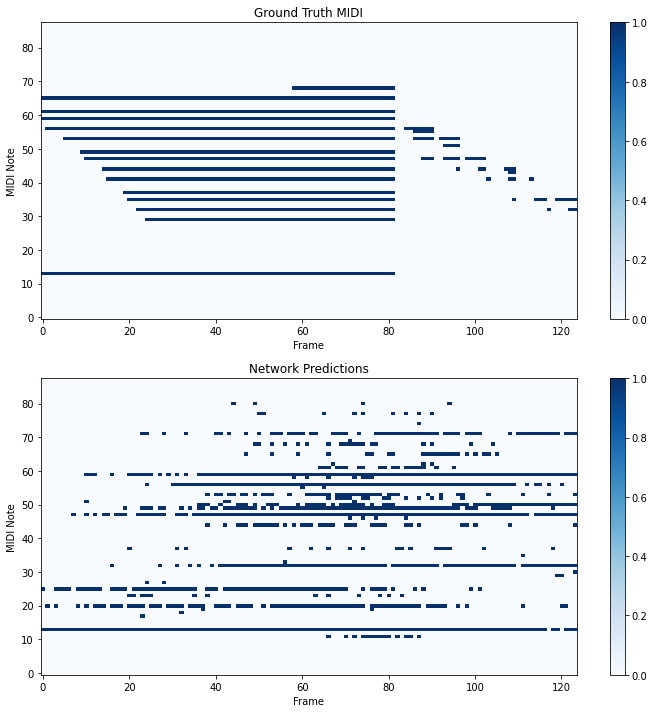

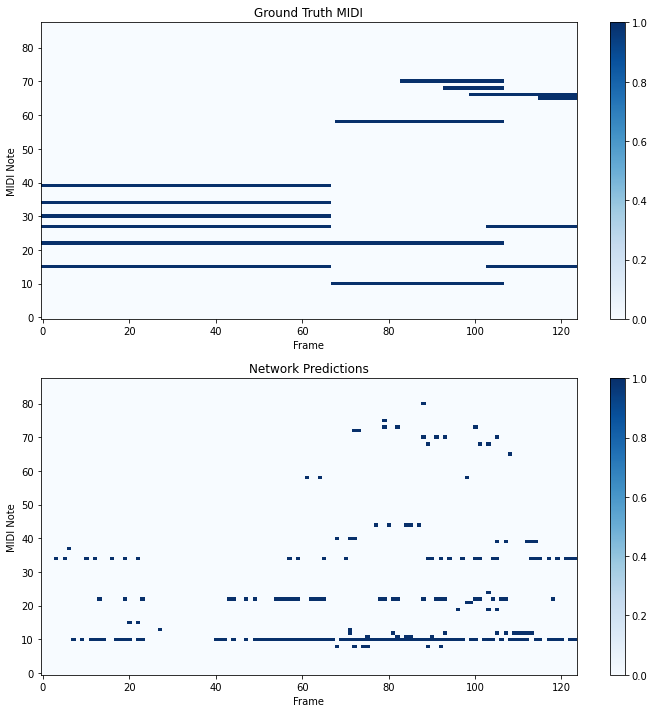

Epoch:23 | batch #525 | Val Acc:0.9335671228413162 | Val Loss:1.2545316219329834
Computing epoch 24...
Epoch:24 | batch #525 | Train Acc:0.8821641065028162 | Train Loss:0.6734279990196228


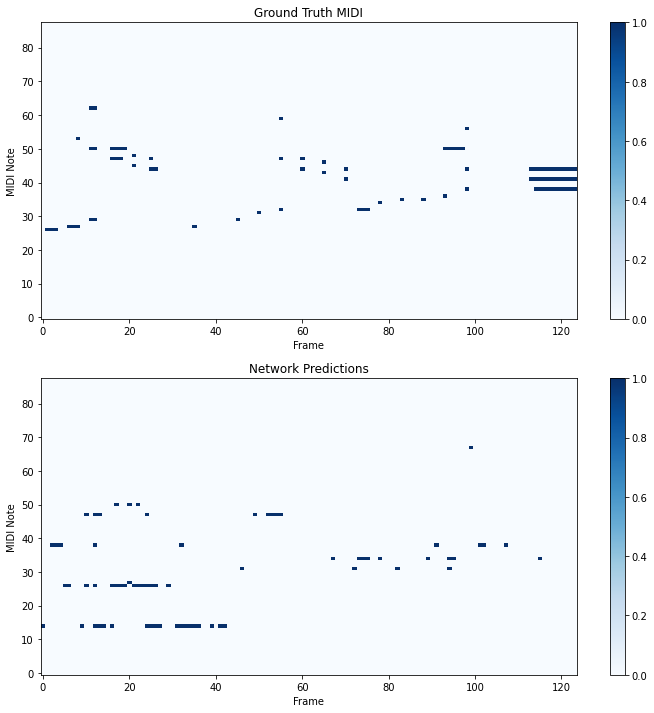

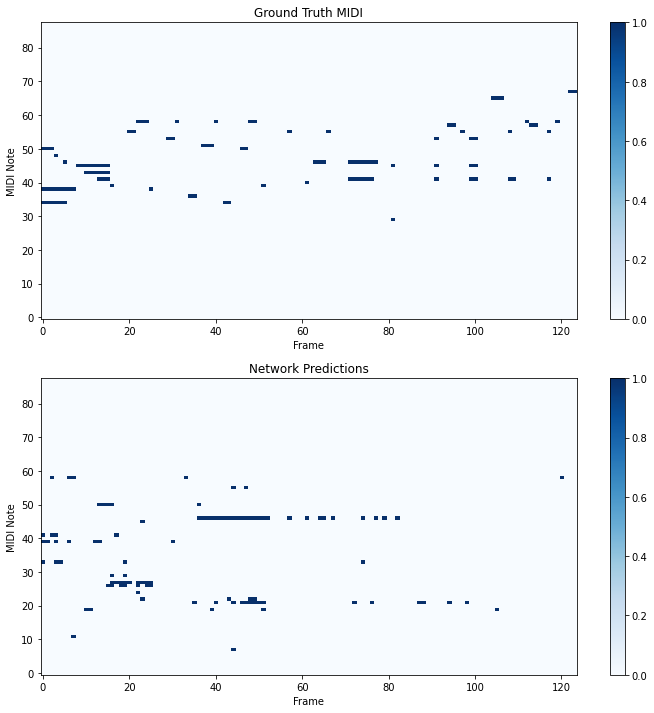

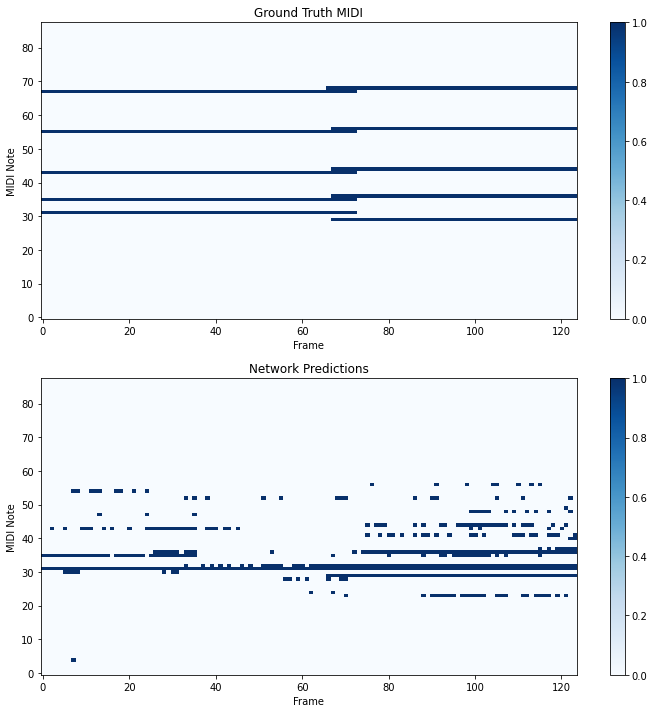

Epoch:24 | batch #525 | Val Acc:0.8941036371782339 | Val Loss:0.8087108135223389
Computing epoch 25...
Epoch:25 | batch #525 | Train Acc:0.8839948156682019 | Train Loss:0.7997761368751526


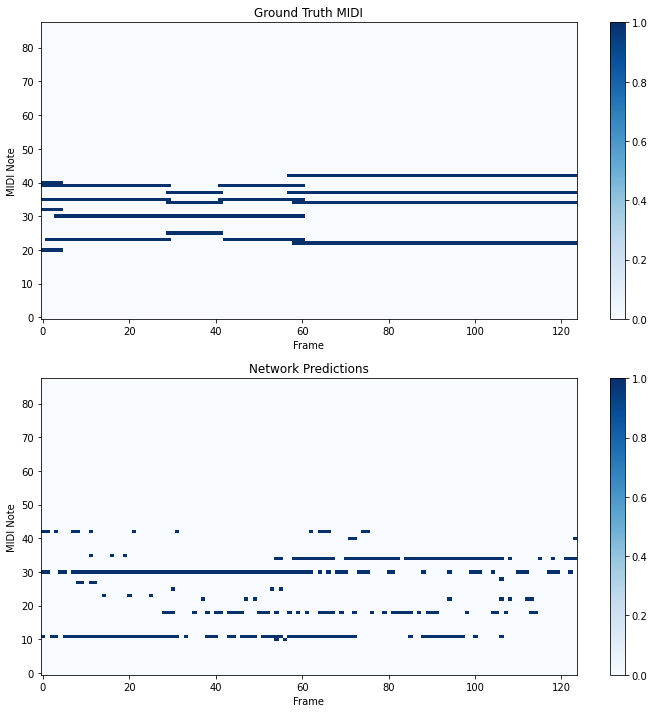

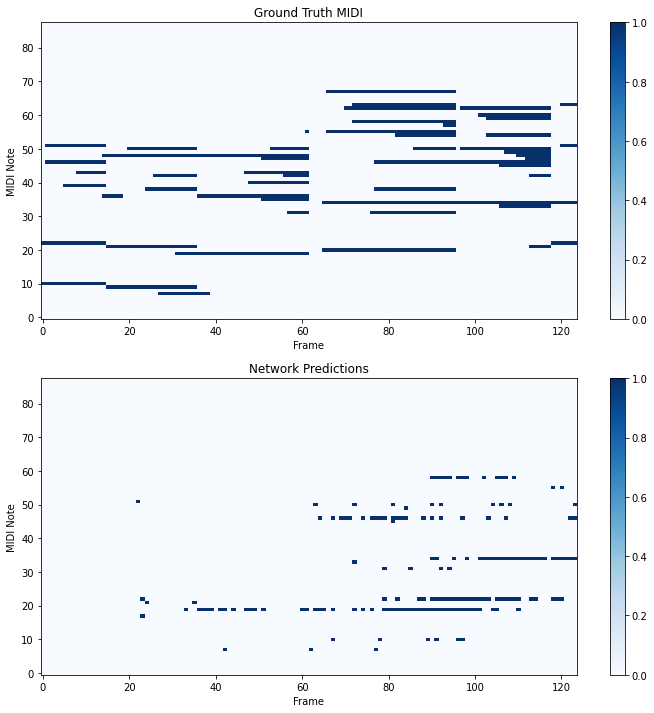

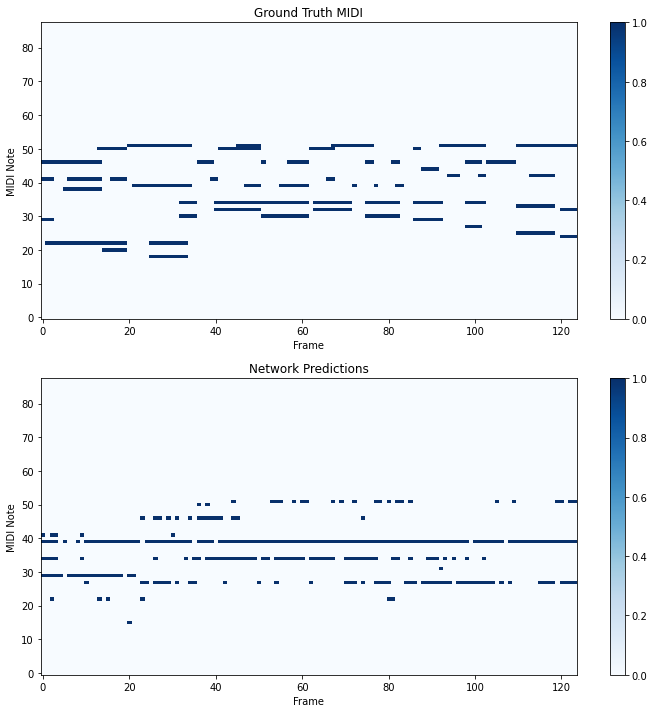

Epoch:25 | batch #525 | Val Acc:0.9478908031932226 | Val Loss:0.8012121915817261
Computing epoch 26...
Epoch:26 | batch #525 | Train Acc:0.8838843998743188 | Train Loss:0.5748533010482788


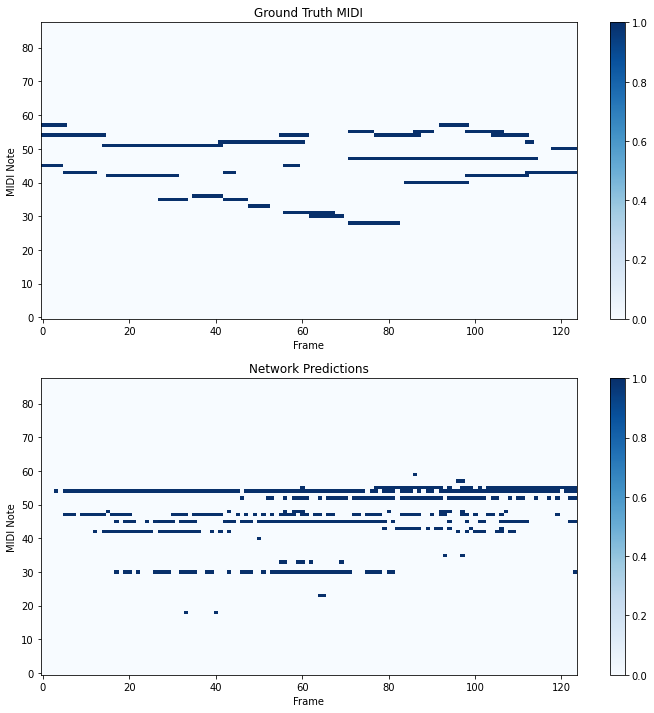

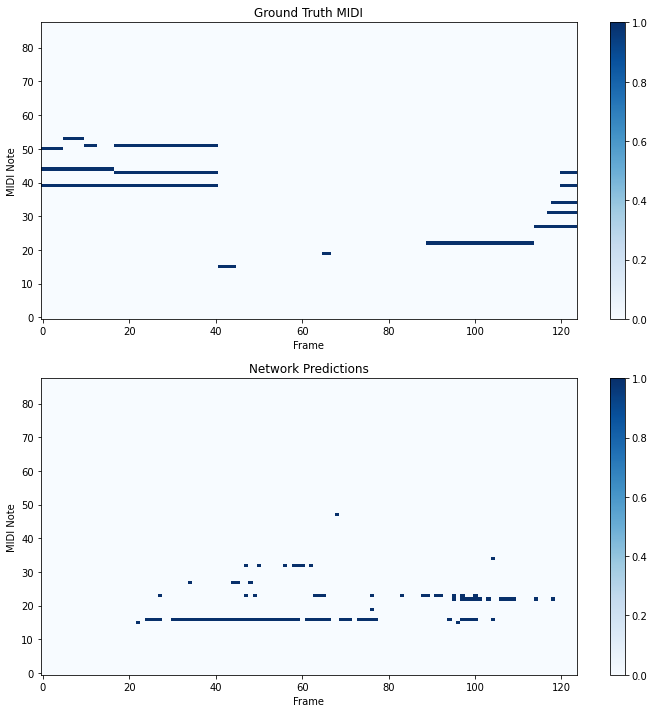

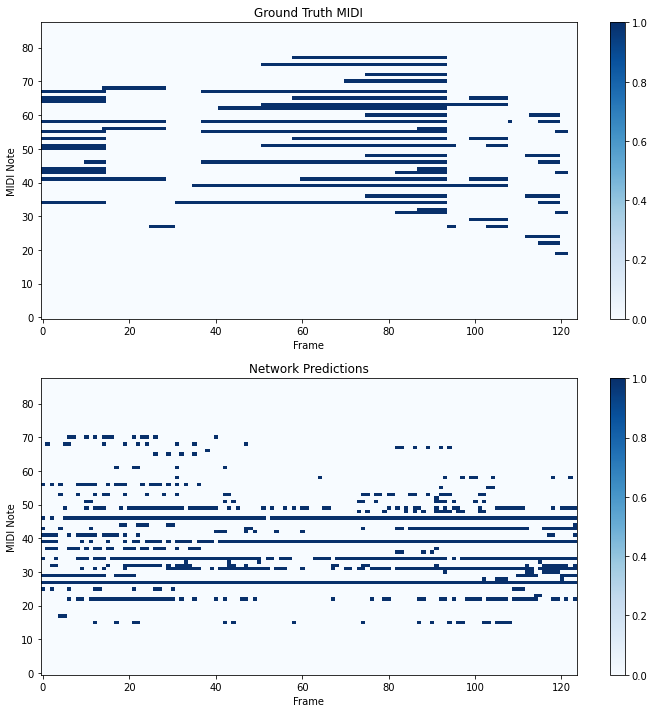

Epoch:26 | batch #525 | Val Acc:0.9045661249592699 | Val Loss:0.5537729859352112
Computing epoch 27...
Epoch:27 | batch #525 | Train Acc:0.8853839576641993 | Train Loss:0.5173545479774475


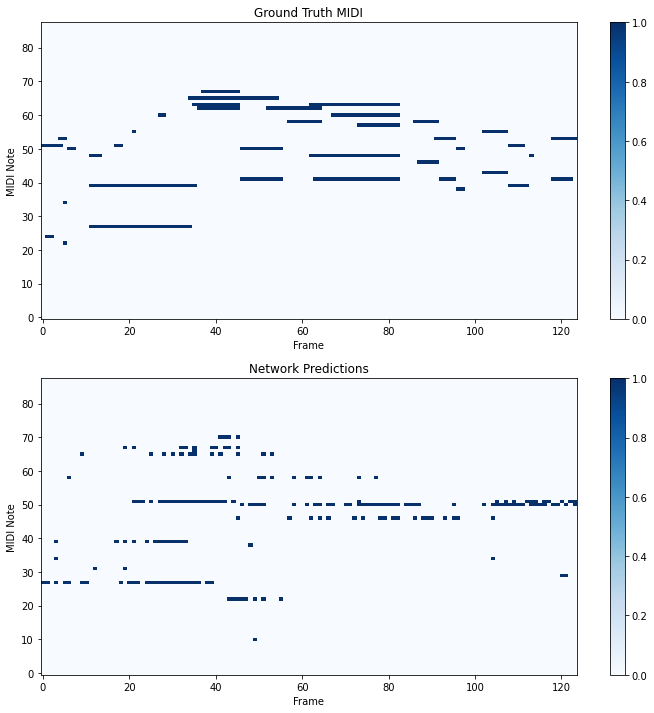

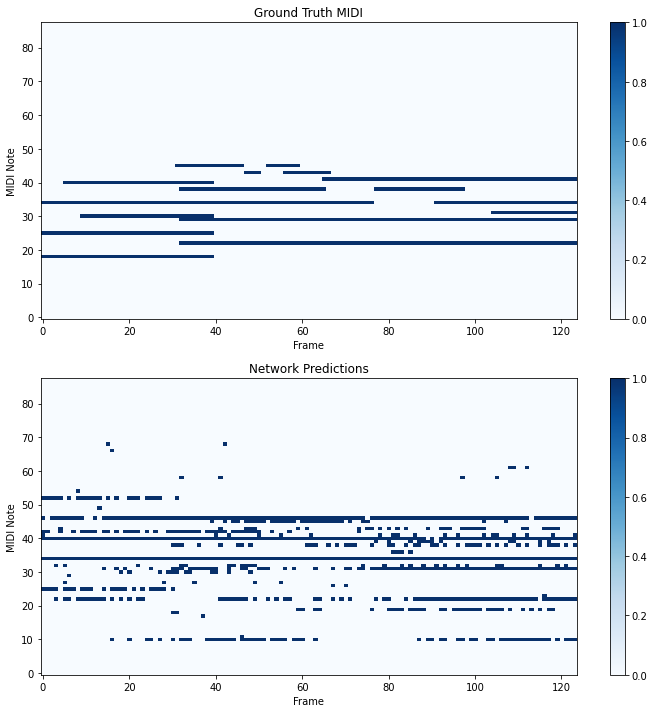

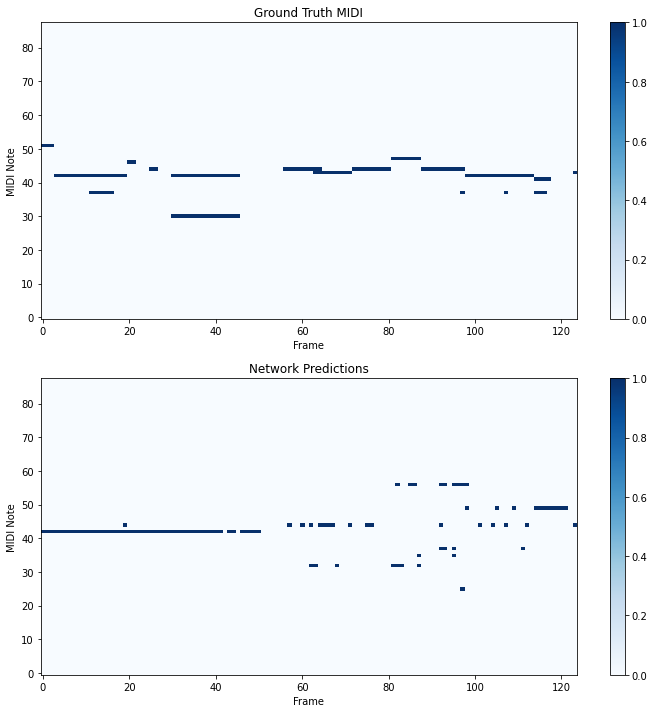

Epoch:27 | batch #525 | Val Acc:0.9181167521994135 | Val Loss:0.691909670829773
Computing epoch 28...
Epoch:28 | batch #525 | Train Acc:0.8864122300190855 | Train Loss:0.6501070857048035


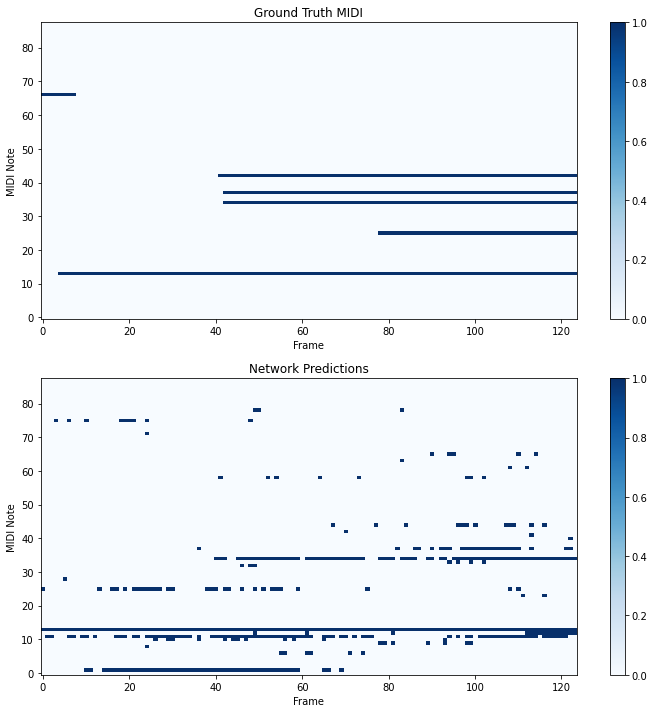

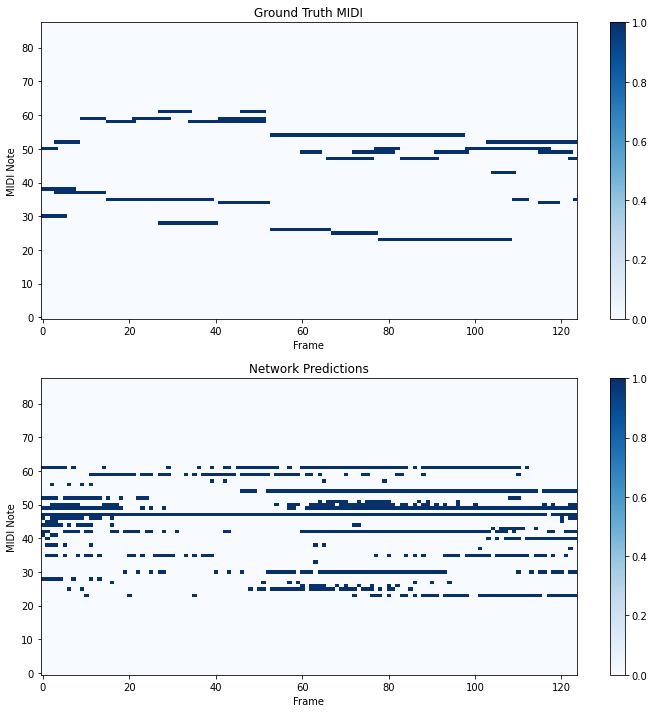

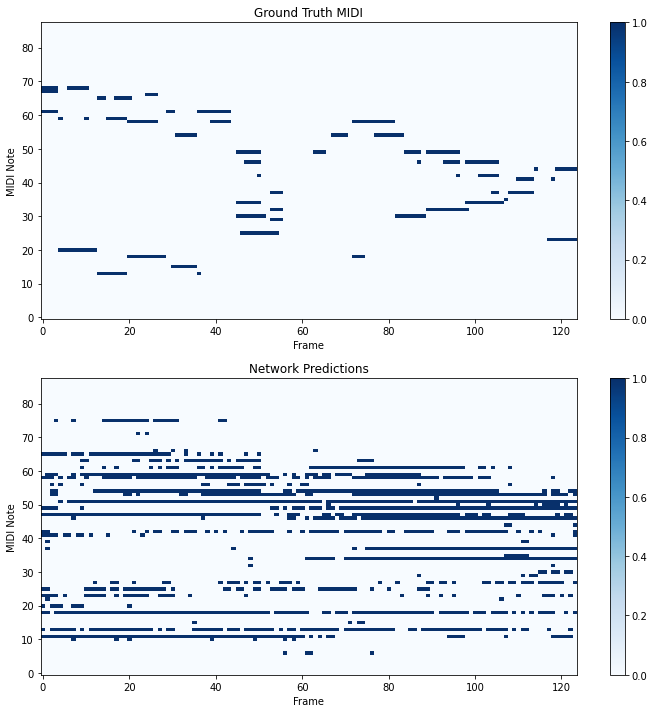

Epoch:28 | batch #525 | Val Acc:0.9144328364288044 | Val Loss:0.5977445244789124
Computing epoch 29...
Epoch:29 | batch #525 | Train Acc:0.8884864893171343 | Train Loss:0.5791139602661133


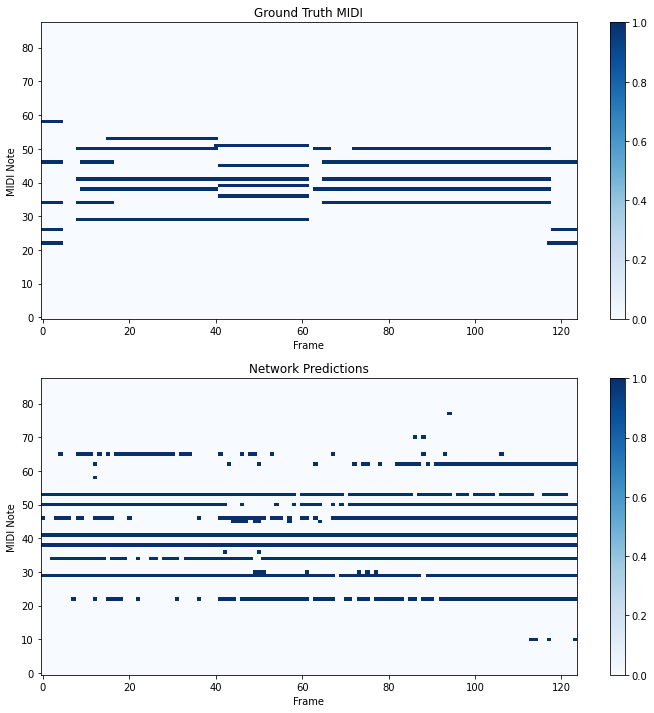

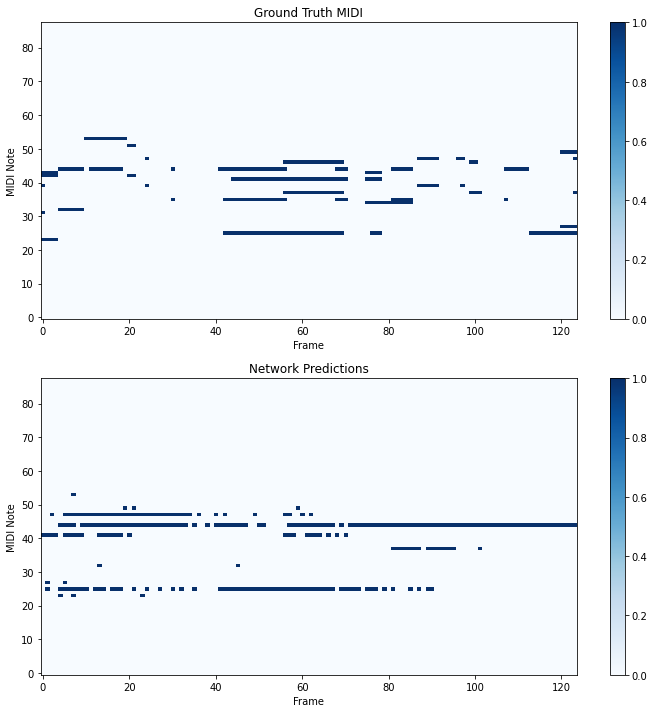

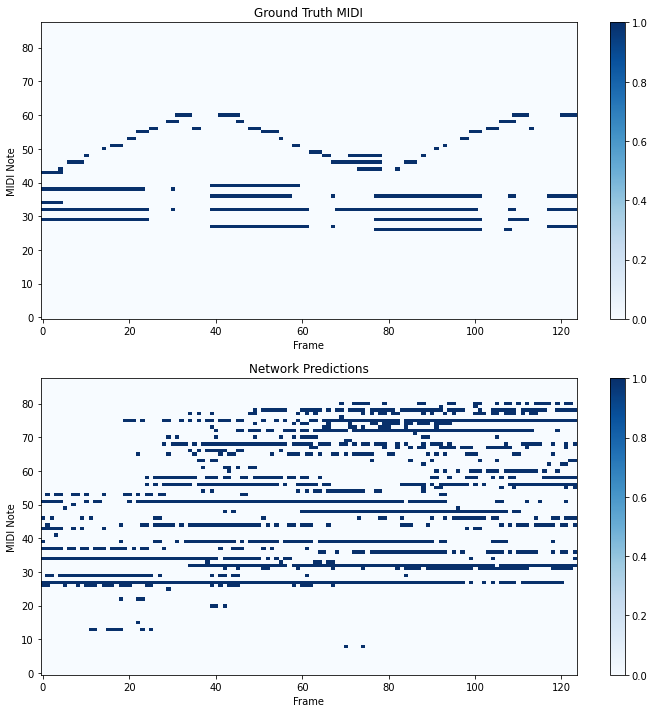

Epoch:29 | batch #525 | Val Acc:0.9010972629521015 | Val Loss:0.4025607407093048
Computing epoch 30...
Epoch:30 | batch #525 | Train Acc:0.8881469010380302 | Train Loss:0.5375476479530334


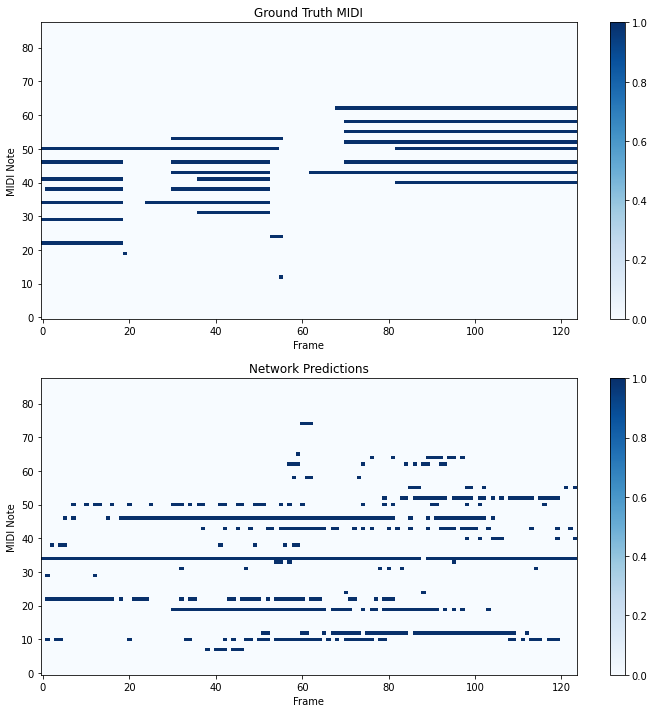

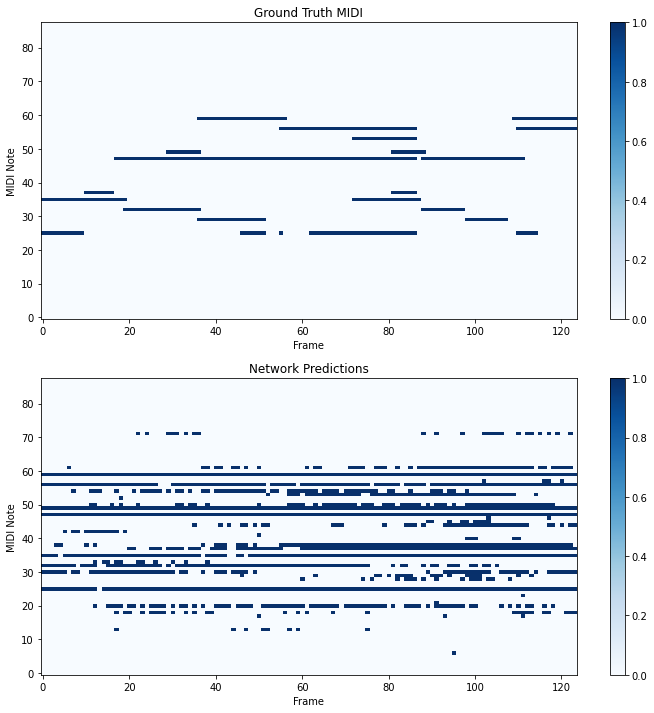

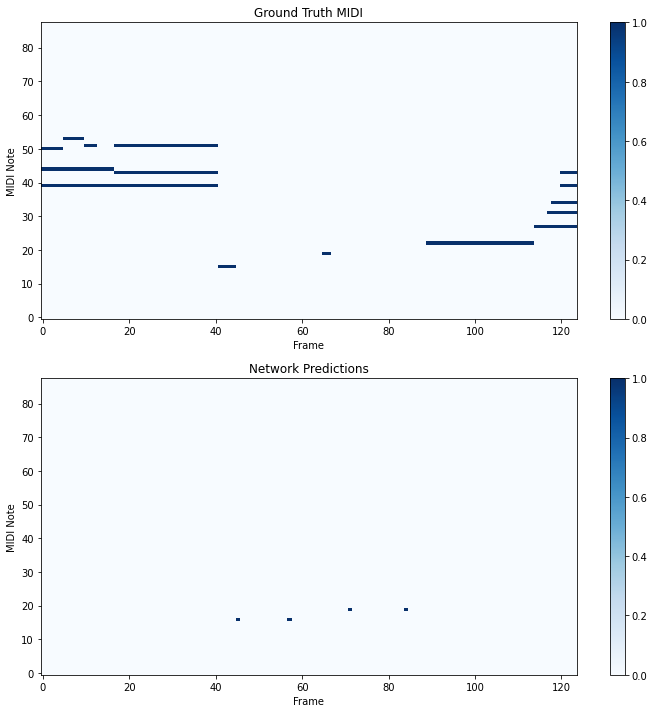

Epoch:30 | batch #525 | Val Acc:0.9288384856630825 | Val Loss:0.7774307131767273
Computing epoch 31...
Epoch:31 | batch #525 | Train Acc:0.8891217707024164 | Train Loss:0.6252623200416565


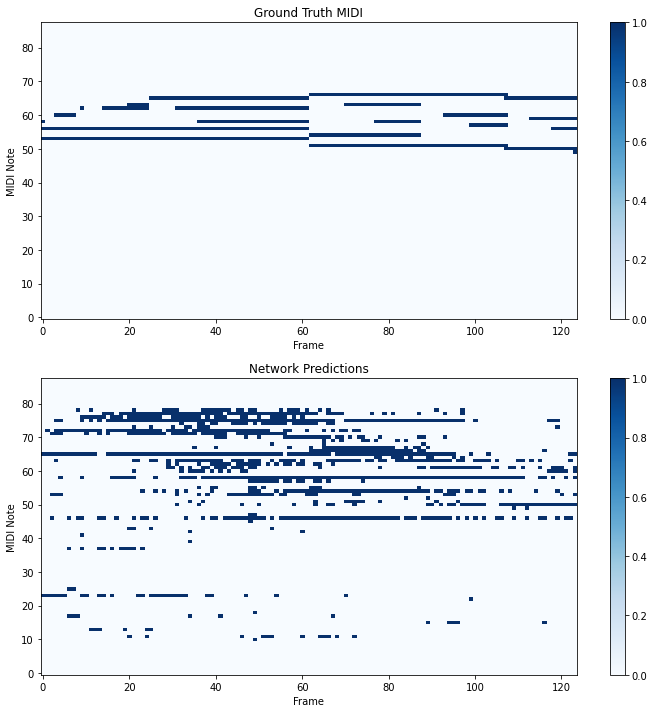

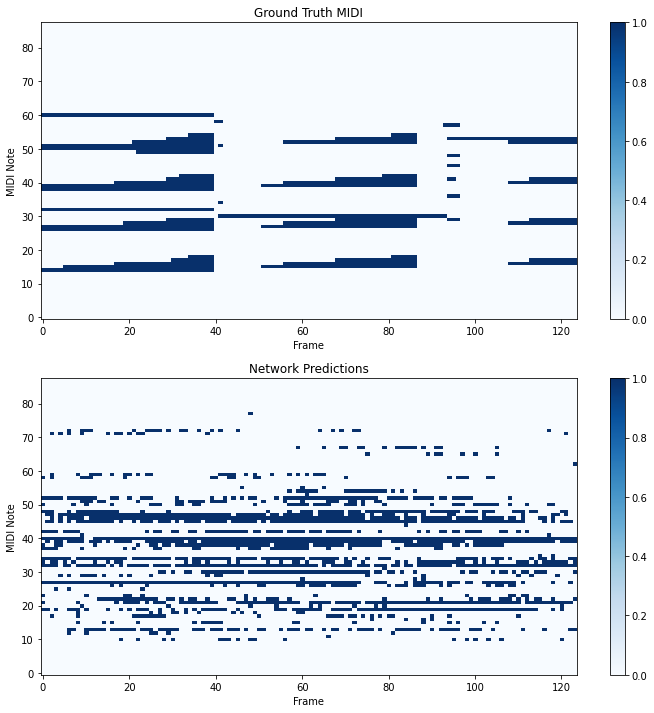

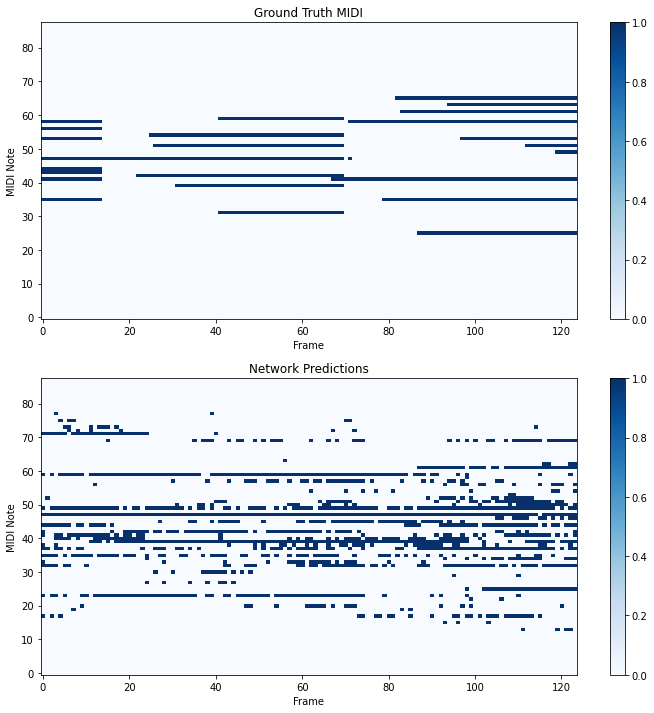

Epoch:31 | batch #525 | Val Acc:0.9181542236884979 | Val Loss:0.6828705668449402
Computing epoch 32...
Epoch:32 | batch #525 | Train Acc:0.8909530442675604 | Train Loss:0.4807617664337158


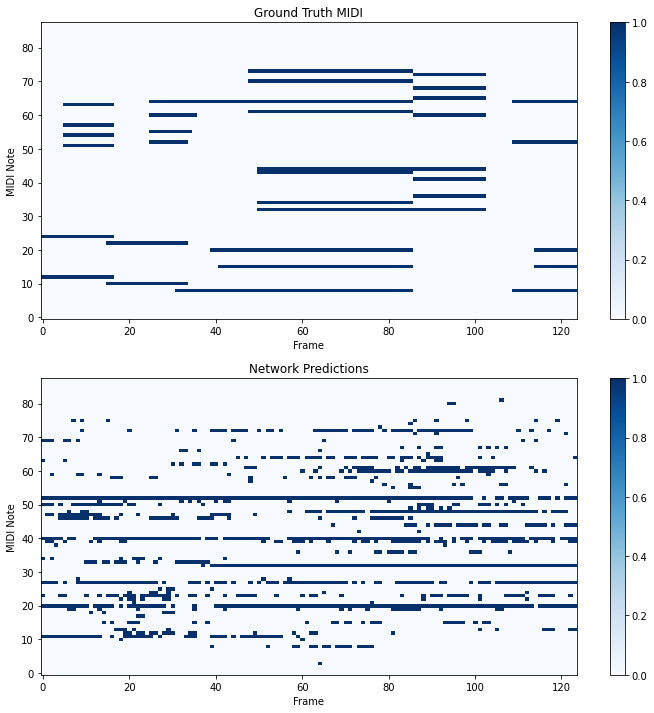

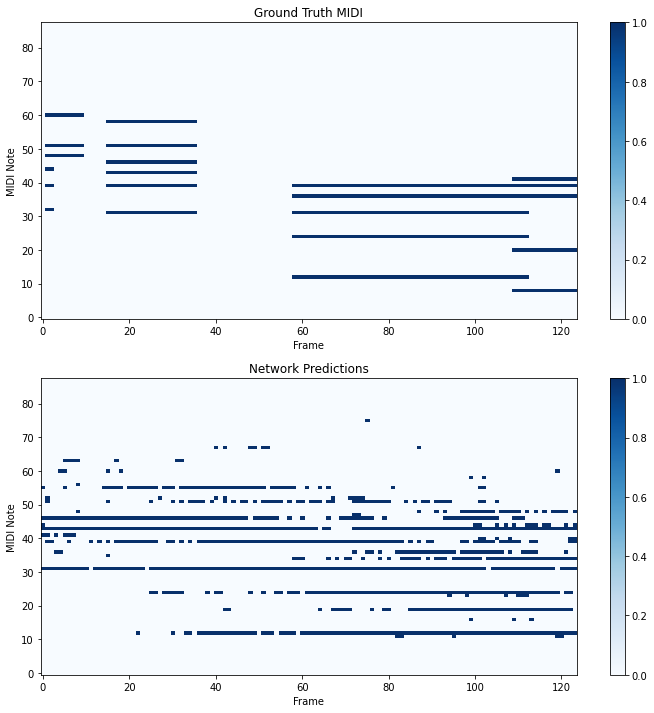

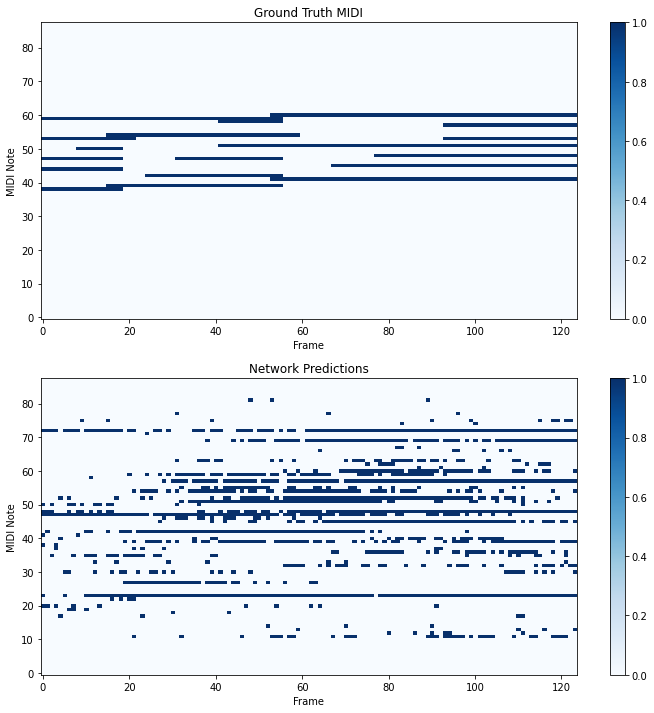

Epoch:32 | batch #525 | Val Acc:0.921774193548387 | Val Loss:0.7423052787780762
Computing epoch 33...
Epoch:33 | batch #525 | Train Acc:0.8907776090397066 | Train Loss:0.6095153093338013


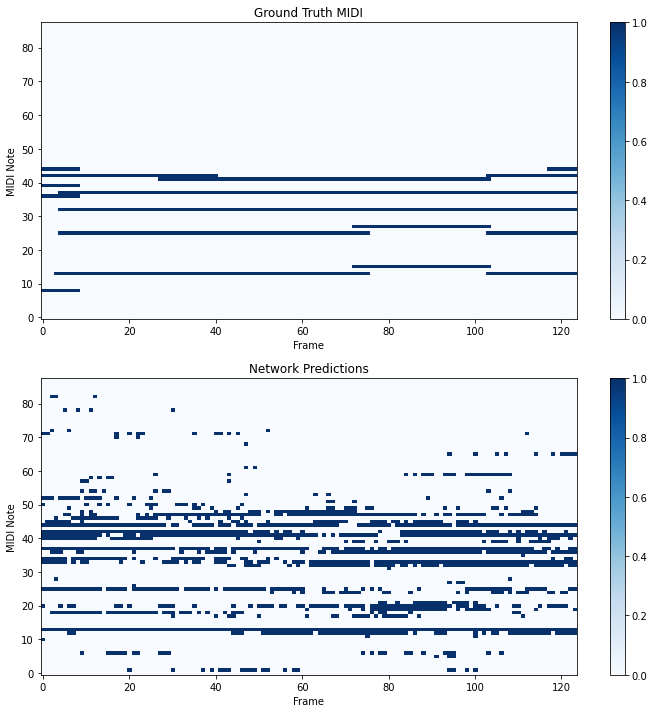

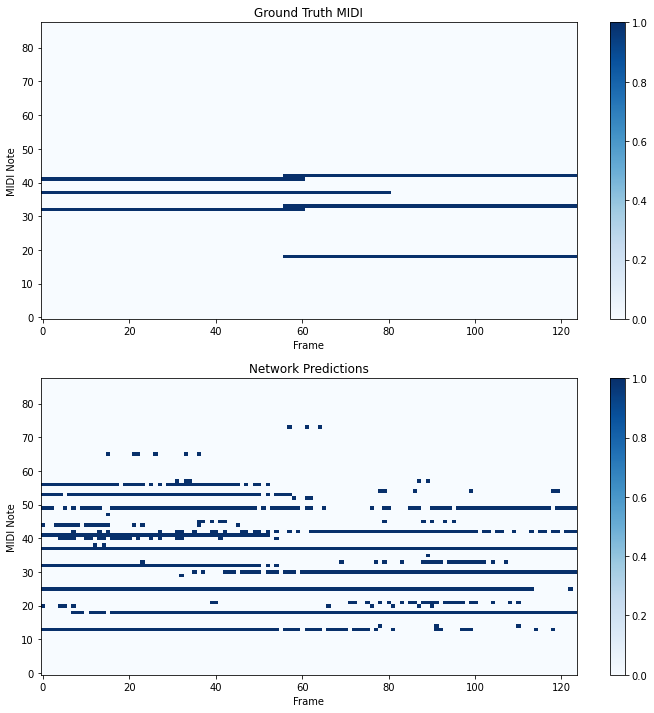

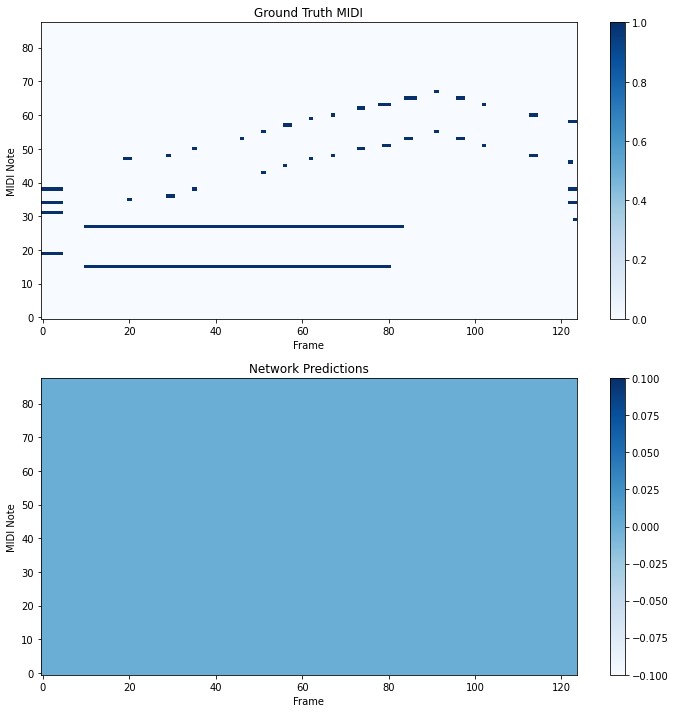

Epoch:33 | batch #525 | Val Acc:0.9285027696318018 | Val Loss:0.7222043871879578
Computing epoch 34...
Epoch:34 | batch #525 | Train Acc:0.892070910720104 | Train Loss:0.499610960483551


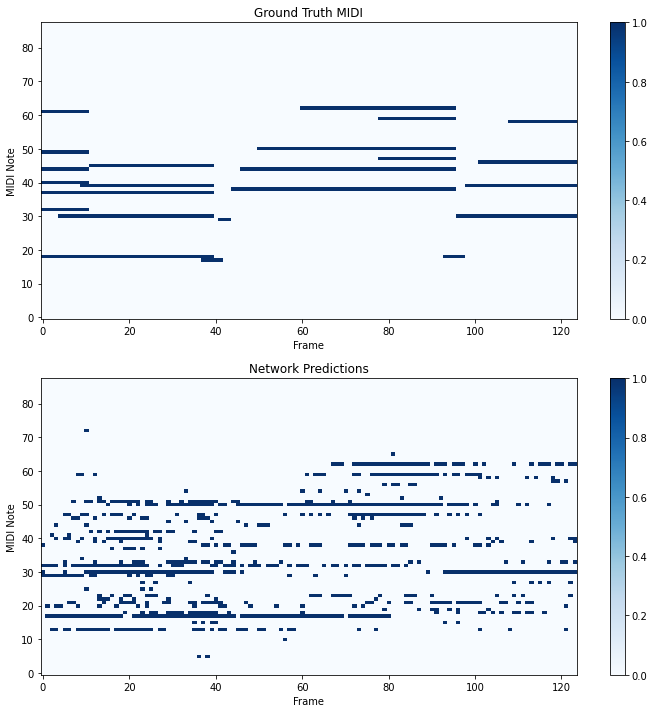

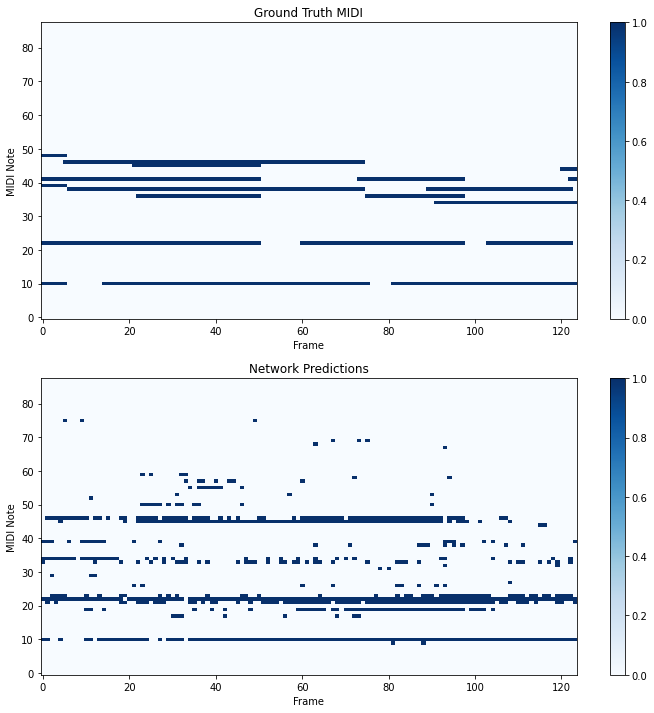

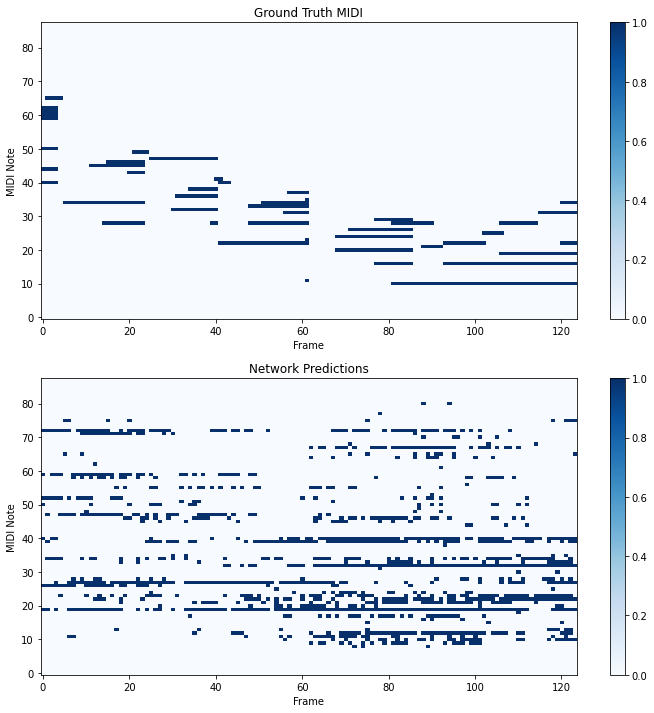

Epoch:34 | batch #525 | Val Acc:0.9257809954382534 | Val Loss:0.8047529458999634
Computing epoch 35...
Epoch:35 | batch #525 | Train Acc:0.8913389947865755 | Train Loss:0.4972947835922241


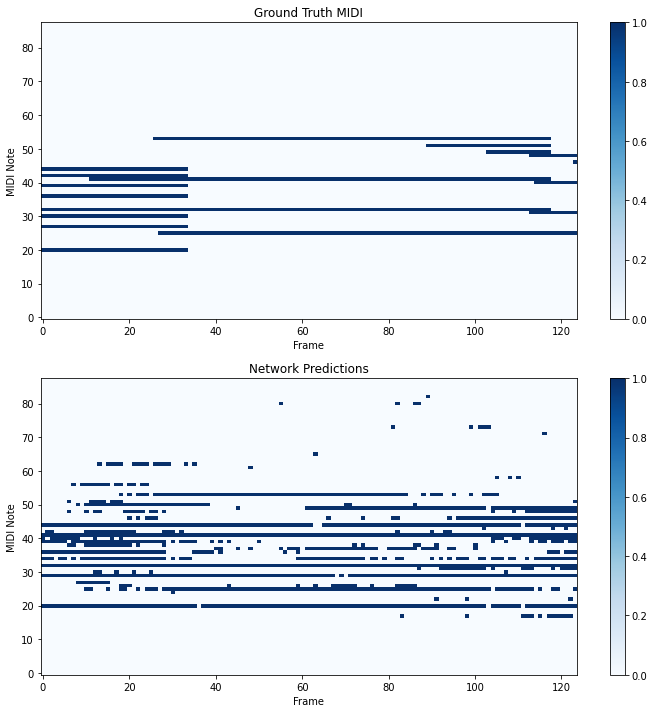

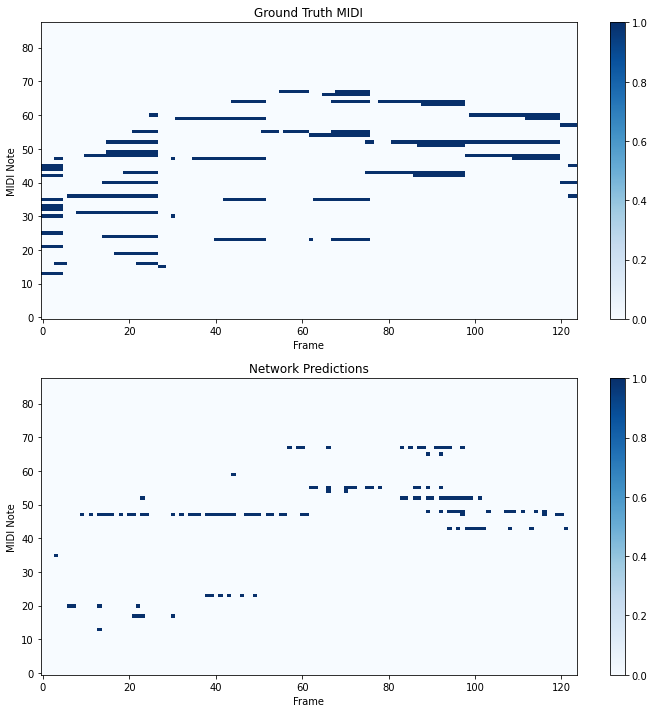

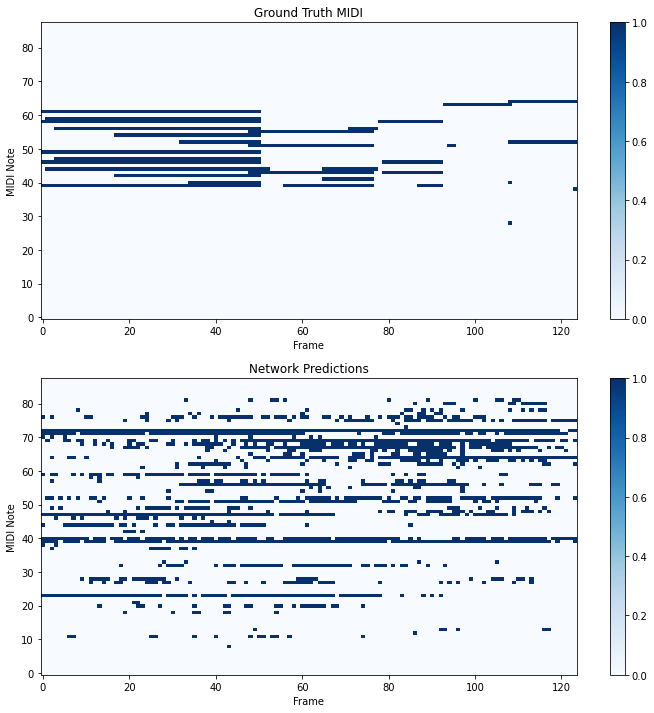

Epoch:35 | batch #525 | Val Acc:0.9347465583251874 | Val Loss:1.0824309587478638
Computing epoch 36...
Epoch:36 | batch #525 | Train Acc:0.8925651736256577 | Train Loss:0.4551490545272827


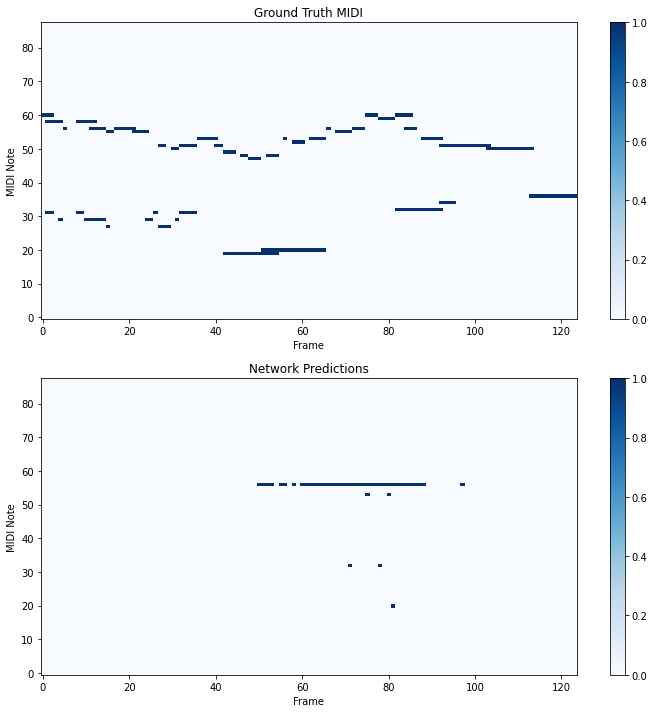

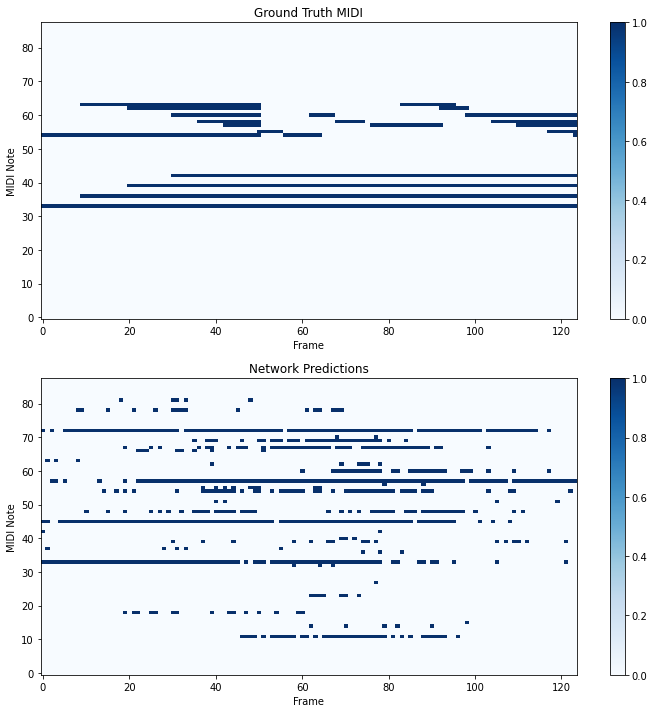

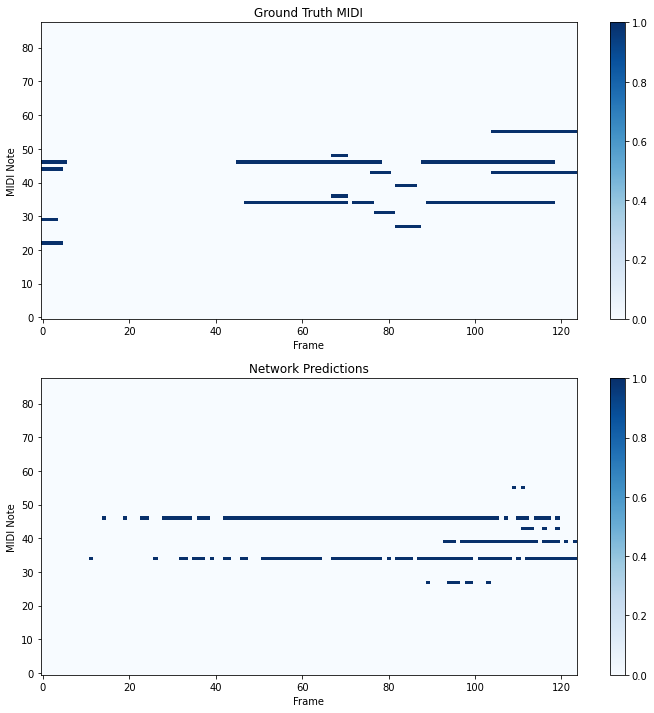

Epoch:36 | batch #525 | Val Acc:0.932859950309547 | Val Loss:0.8254473805427551
Computing epoch 37...
Epoch:37 | batch #525 | Train Acc:0.893340461062236 | Train Loss:0.5443800091743469


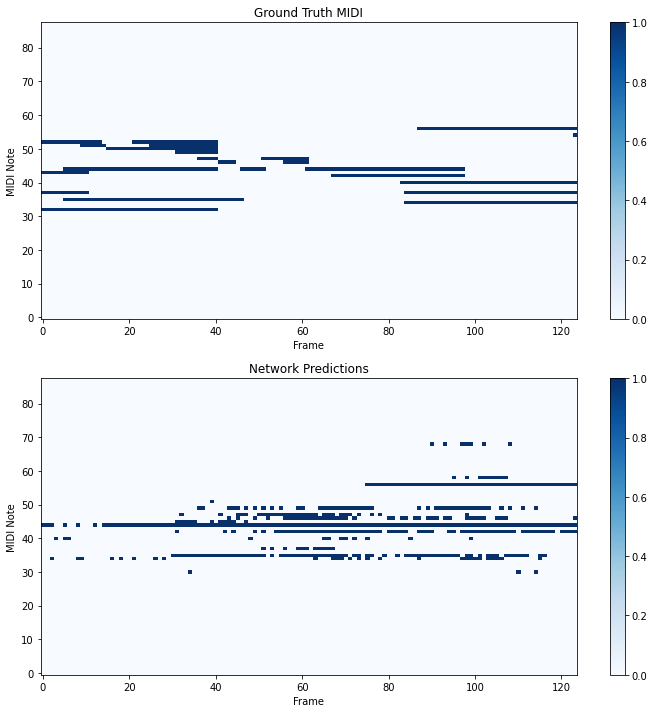

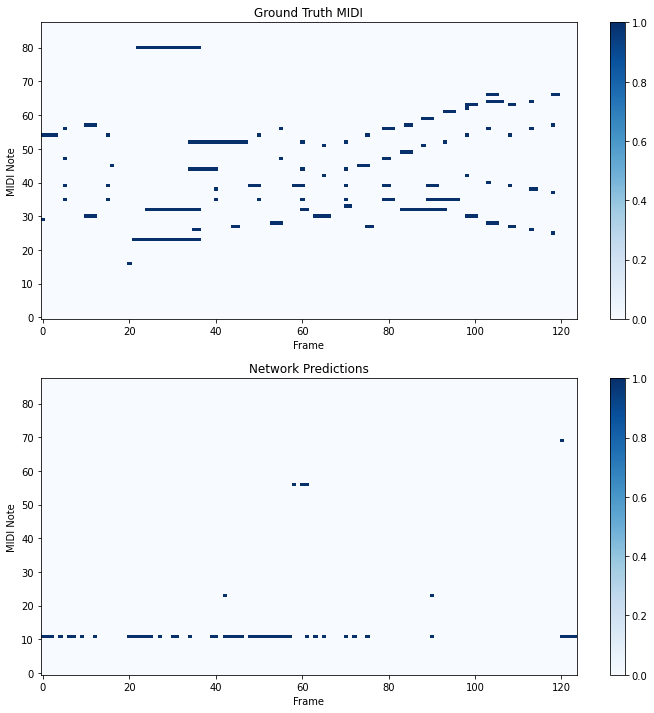

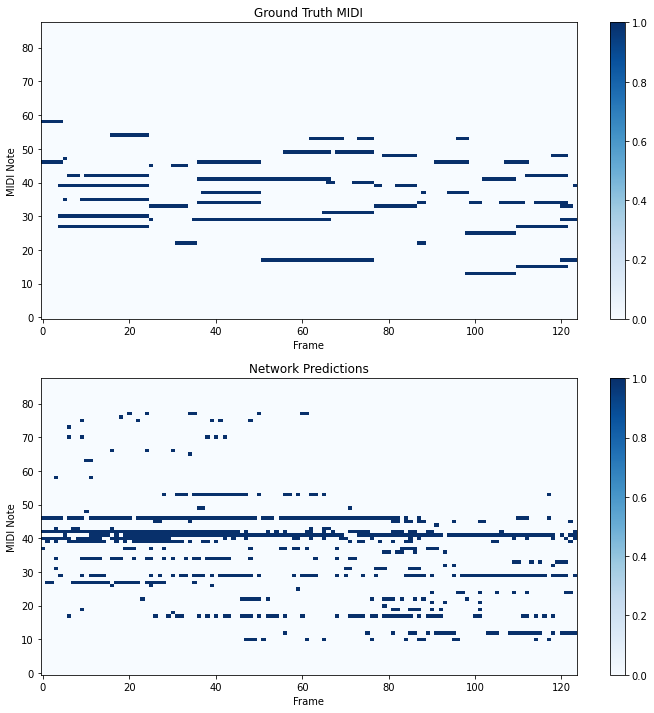

Epoch:37 | batch #525 | Val Acc:0.9207004521016617 | Val Loss:0.6636160016059875
Computing epoch 38...
Epoch:38 | batch #525 | Train Acc:0.8945781228180423 | Train Loss:0.6406087279319763


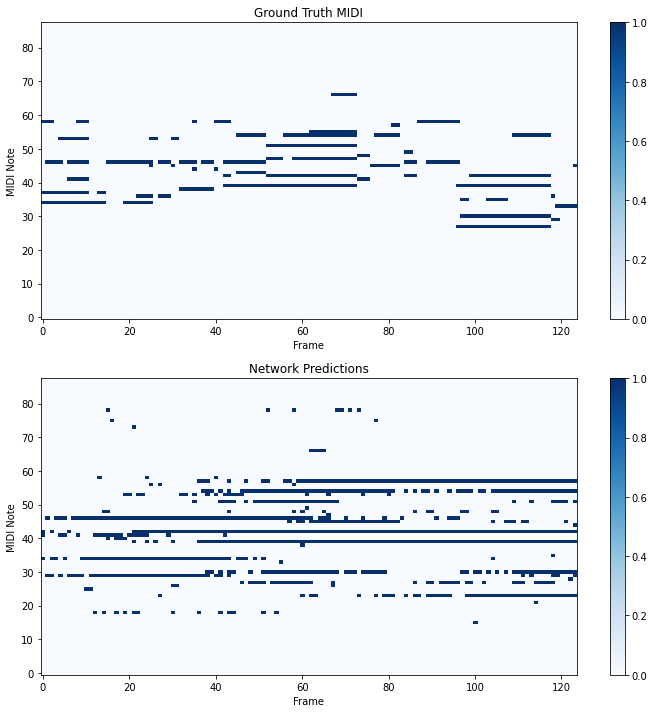

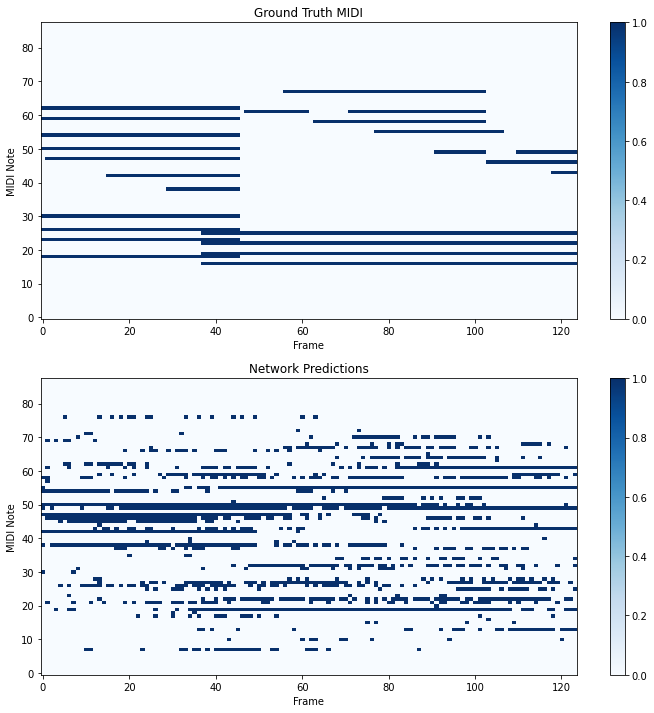

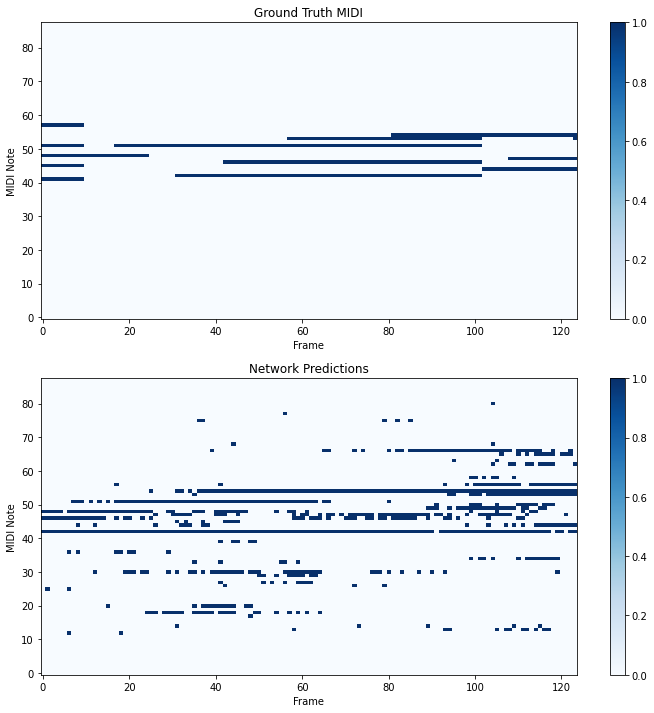

Epoch:38 | batch #525 | Val Acc:0.9136094819159335 | Val Loss:0.8475112318992615
Computing epoch 39...
Epoch:39 | batch #525 | Train Acc:0.8951101801424385 | Train Loss:0.587449312210083


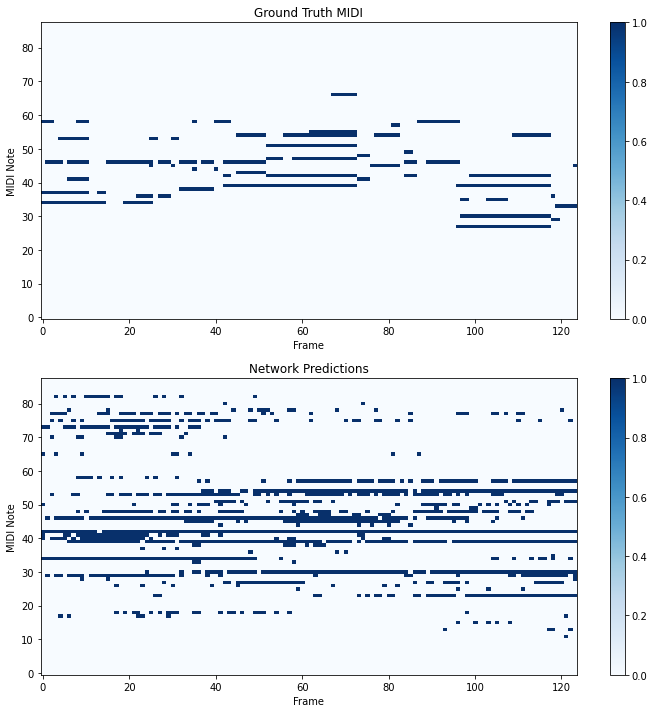

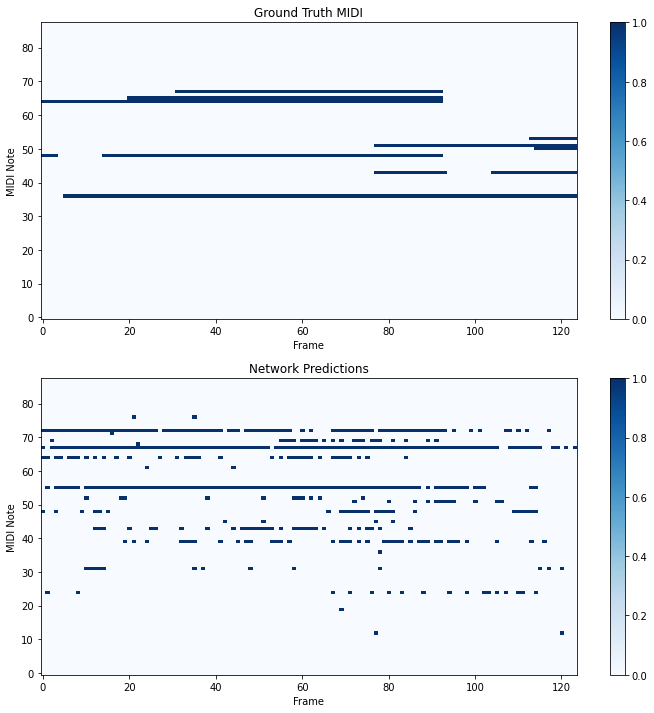

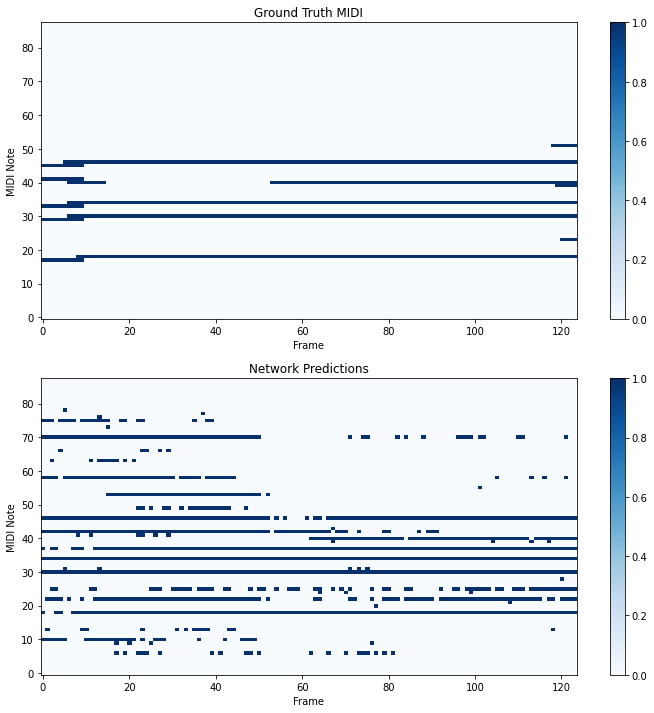

Epoch:39 | batch #525 | Val Acc:0.8978163693385467 | Val Loss:0.9126216769218445
Computing epoch 40...
Epoch:40 | batch #525 | Train Acc:0.89531574384397 | Train Loss:0.4454553723335266


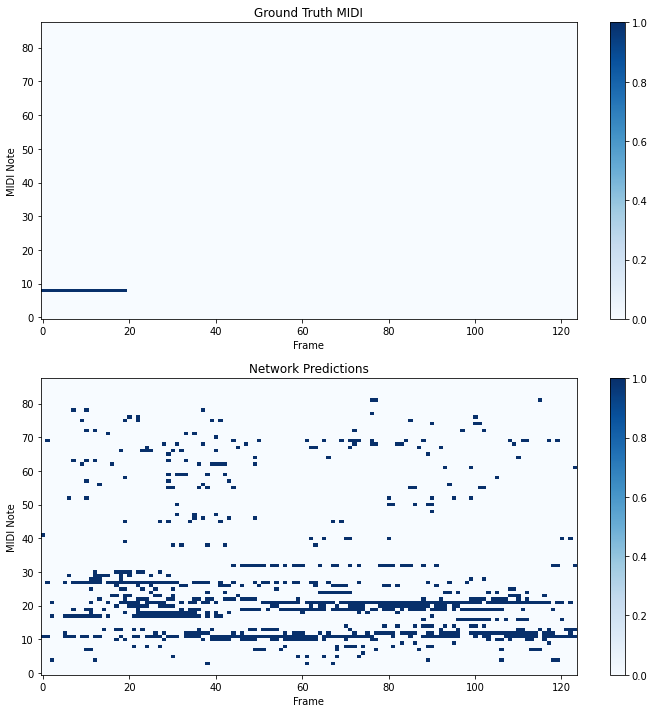

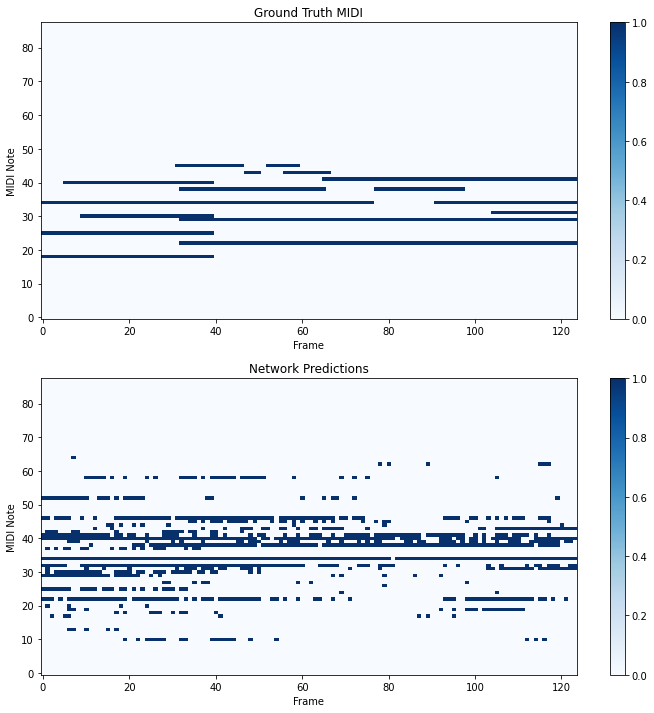

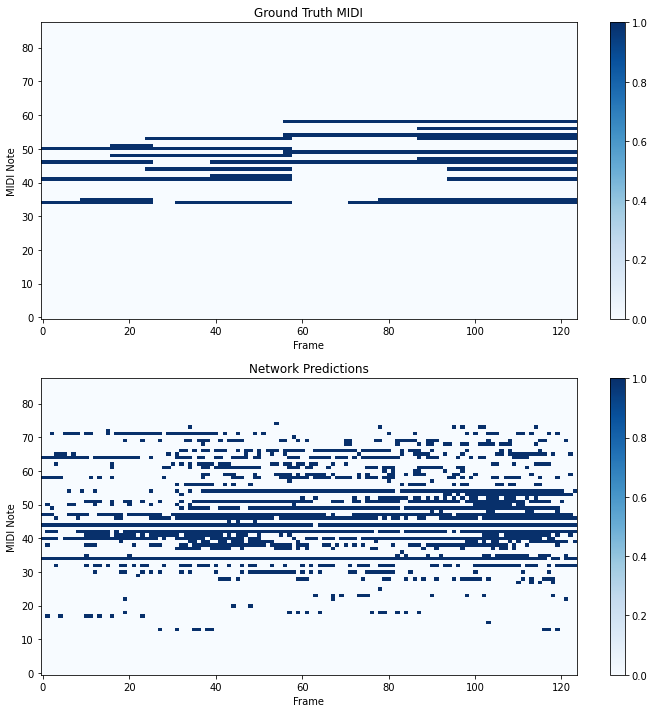

Epoch:40 | batch #525 | Val Acc:0.9198347385141741 | Val Loss:0.831884503364563
Computing epoch 41...
Epoch:41 | batch #525 | Train Acc:0.8959893433179721 | Train Loss:0.5105746388435364


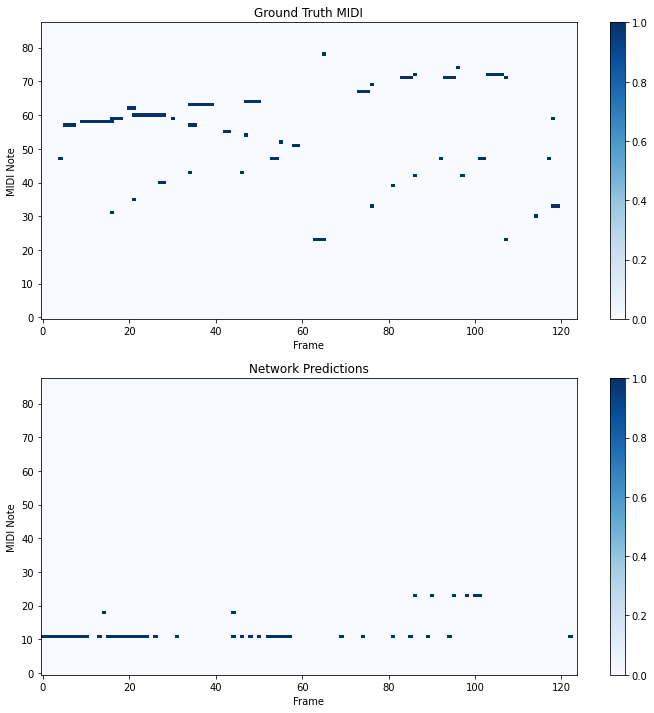

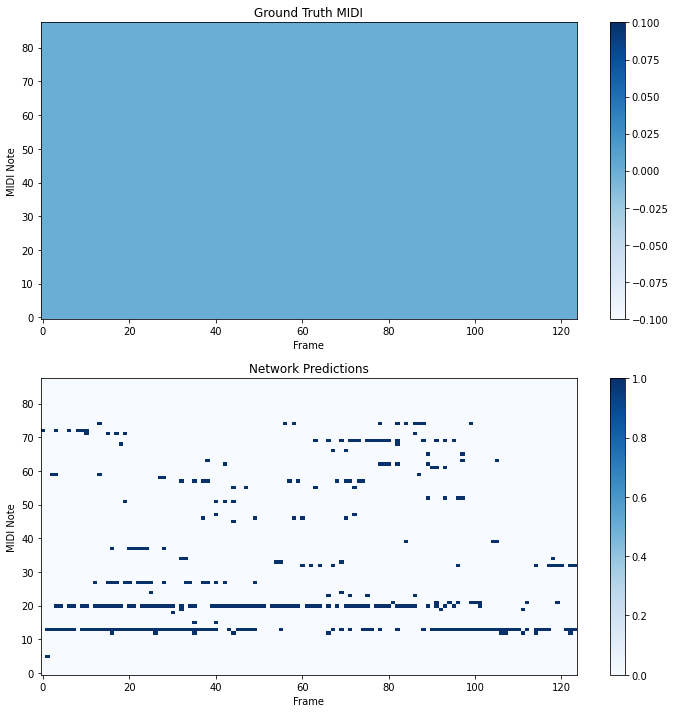

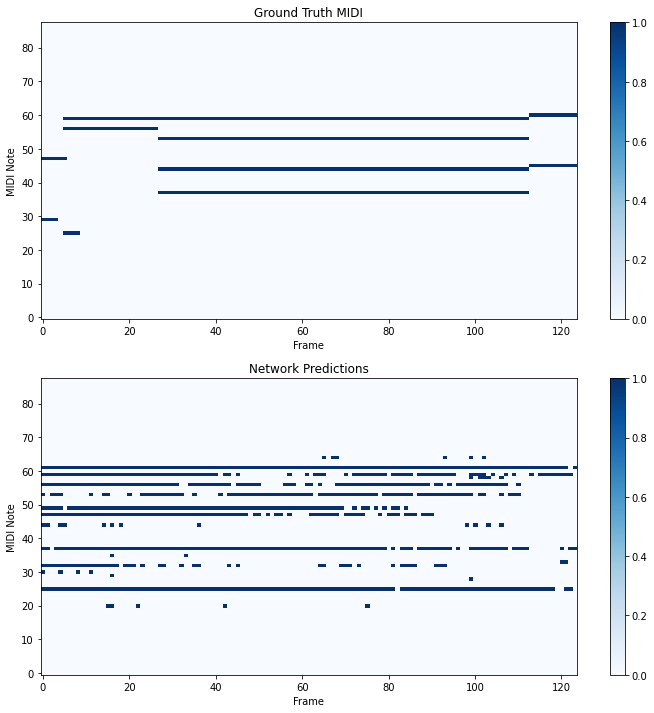

Epoch:41 | batch #525 | Val Acc:0.8994973932877157 | Val Loss:0.7547776699066162
Computing epoch 42...
Epoch:42 | batch #525 | Train Acc:0.8968524036447427 | Train Loss:0.42572206258773804


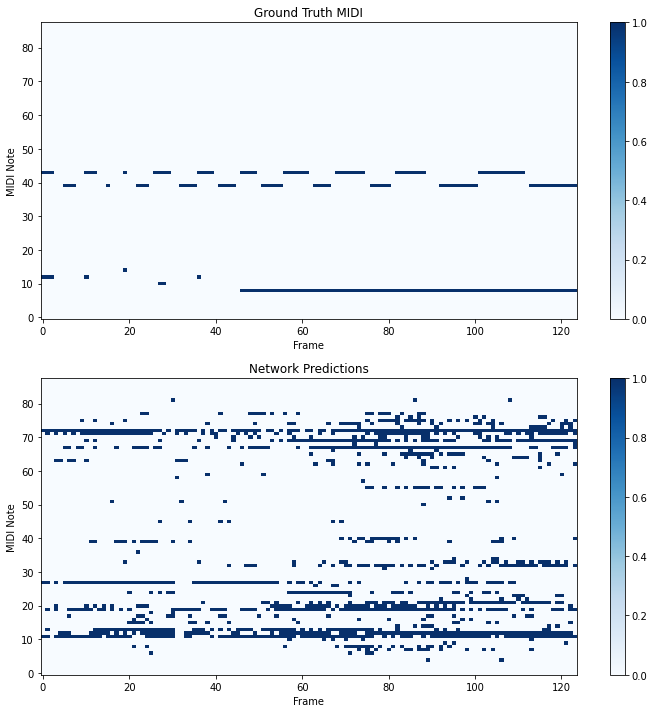

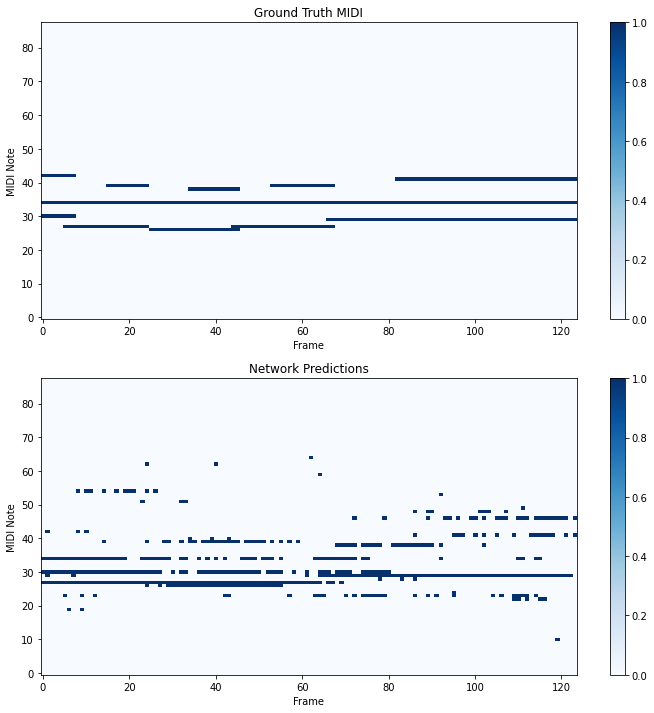

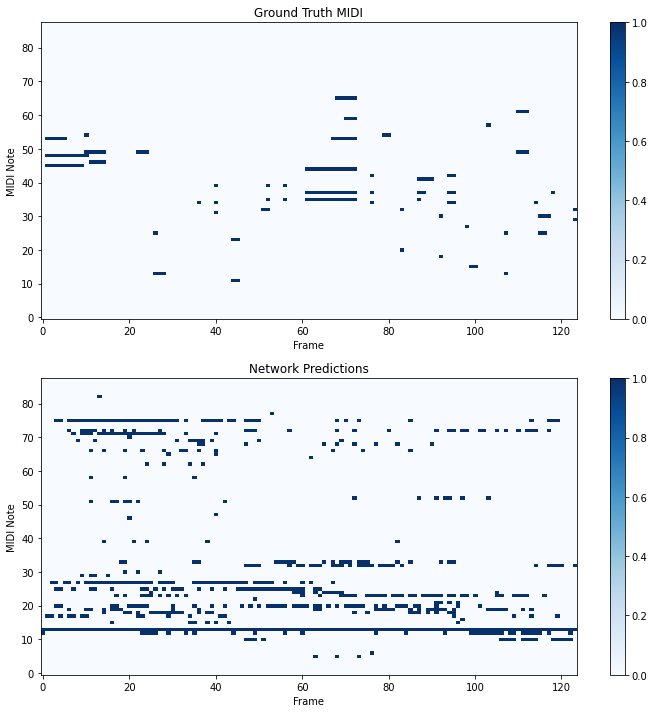

Epoch:42 | batch #525 | Val Acc:0.9240930474095795 | Val Loss:0.625390350818634
Computing epoch 43...
Epoch:43 | batch #525 | Train Acc:0.8967314679048555 | Train Loss:0.5293583869934082


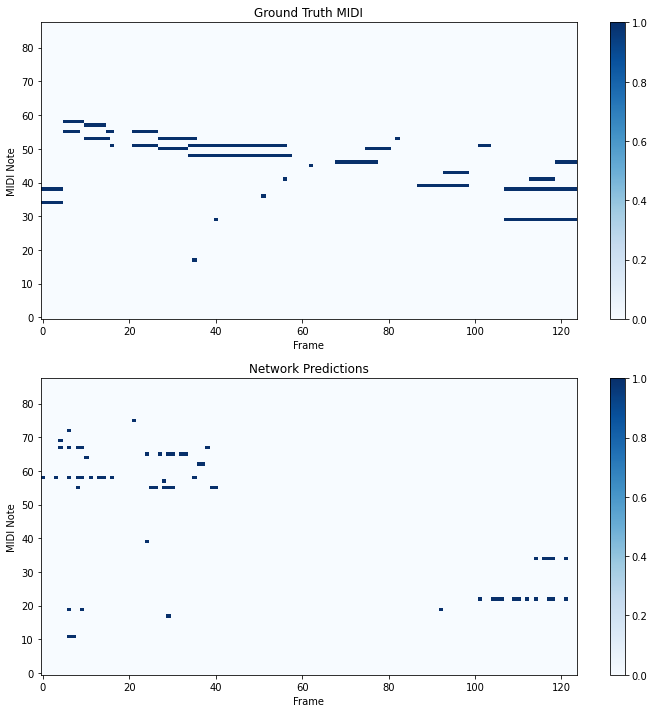

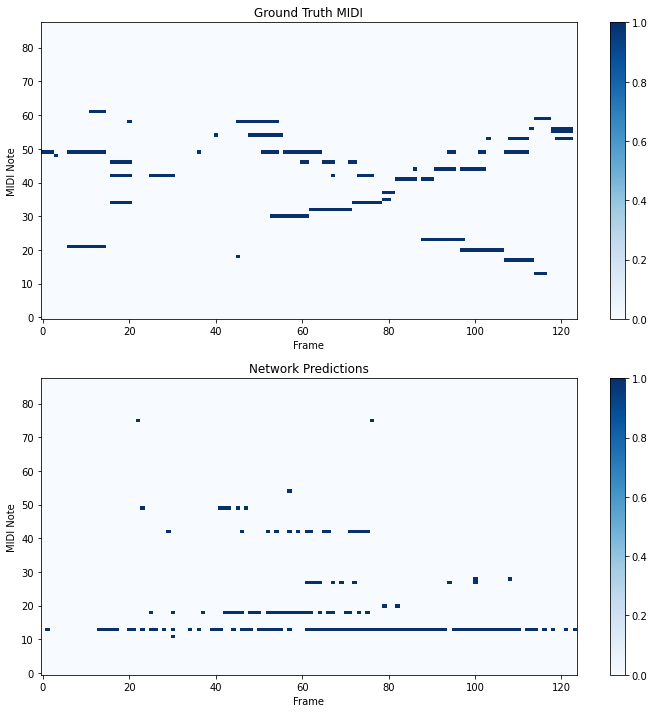

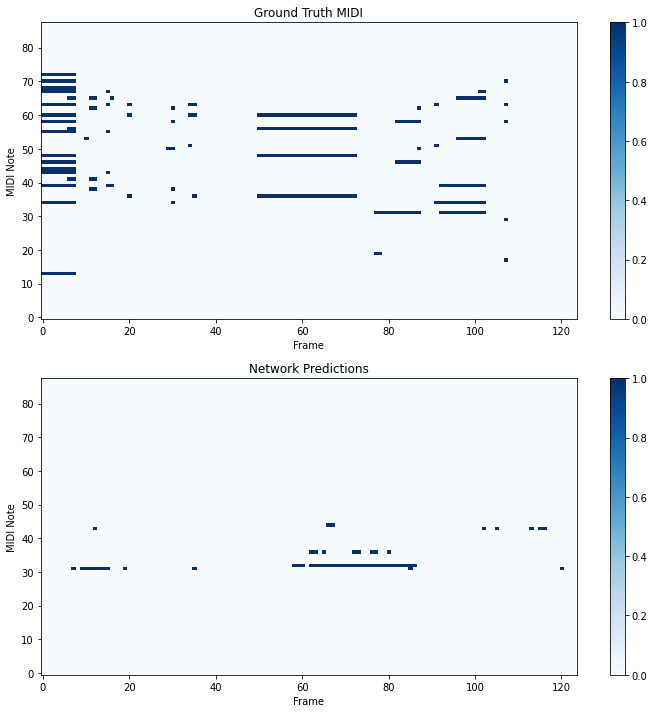

Epoch:43 | batch #525 | Val Acc:0.9262813620071685 | Val Loss:0.8109601736068726
Computing epoch 44...
Epoch:44 | batch #525 | Train Acc:0.8980951333612625 | Train Loss:0.6062453985214233


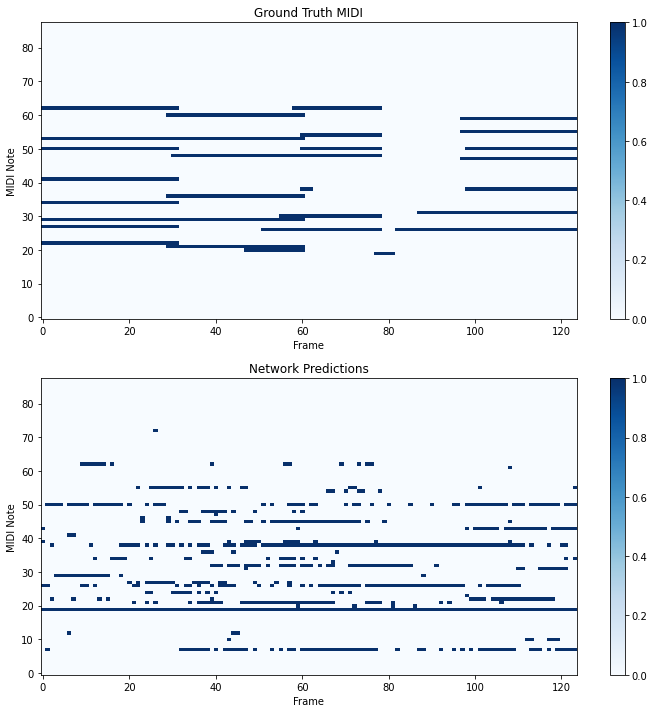

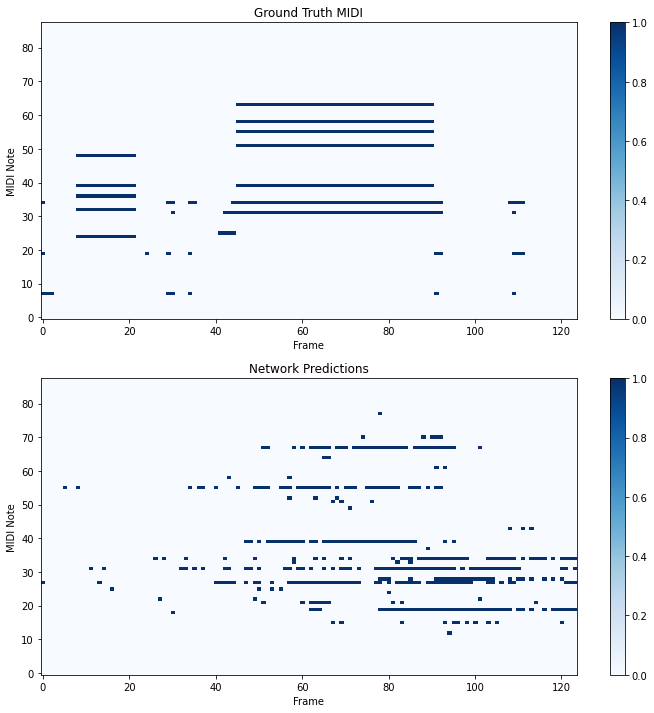

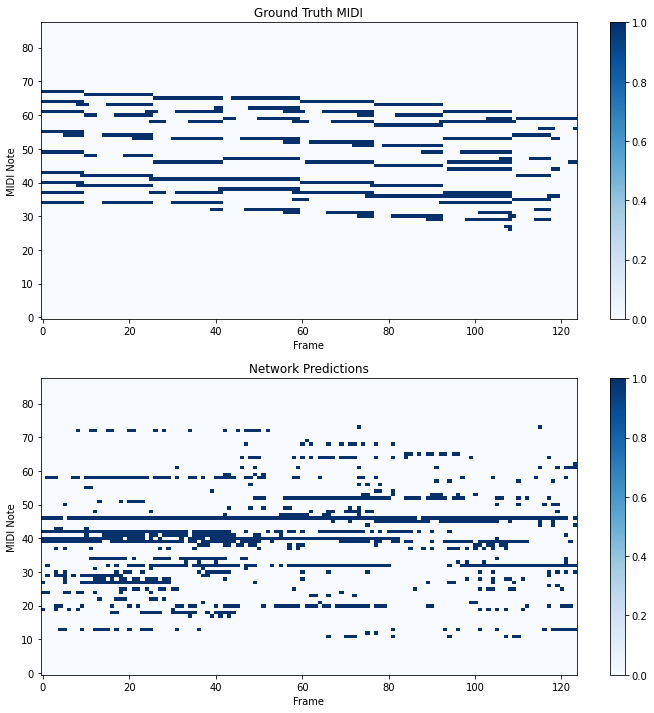

Epoch:44 | batch #525 | Val Acc:0.9111370764092539 | Val Loss:0.9119834303855896
Computing epoch 45...
Epoch:45 | batch #525 | Train Acc:0.8991222100032592 | Train Loss:0.5707155466079712


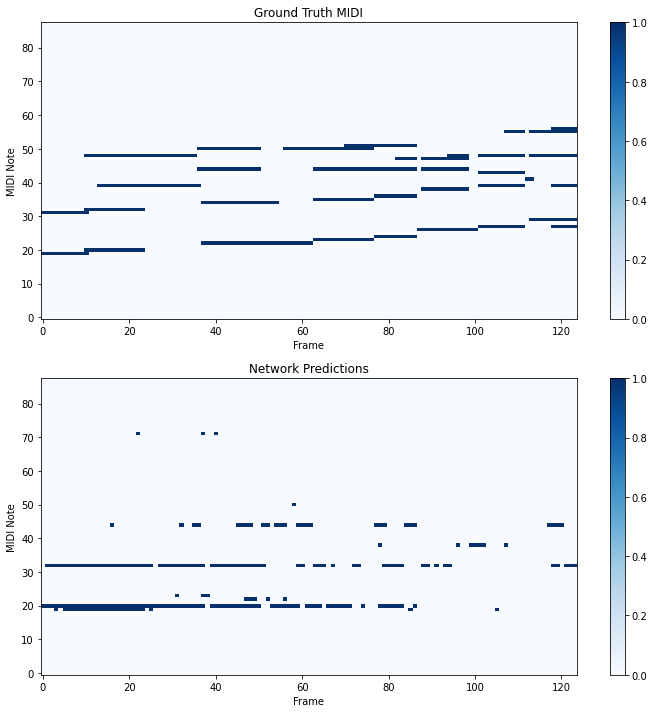

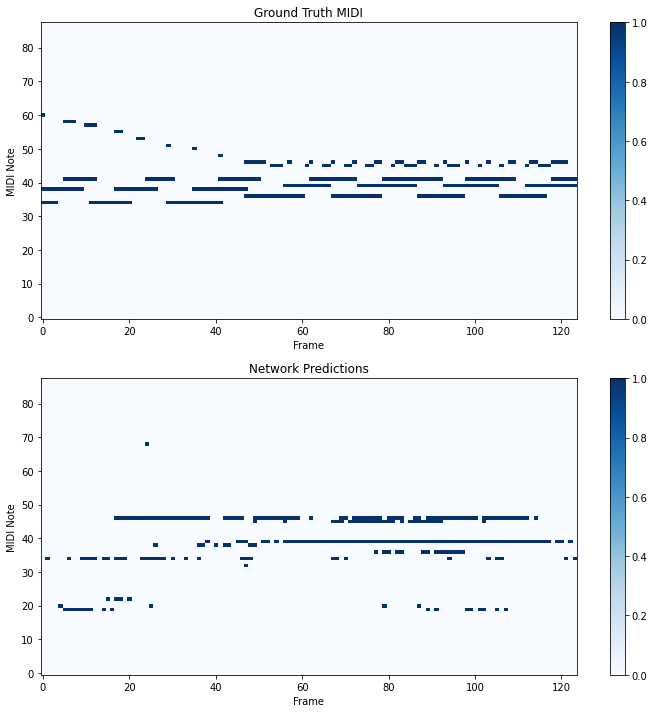

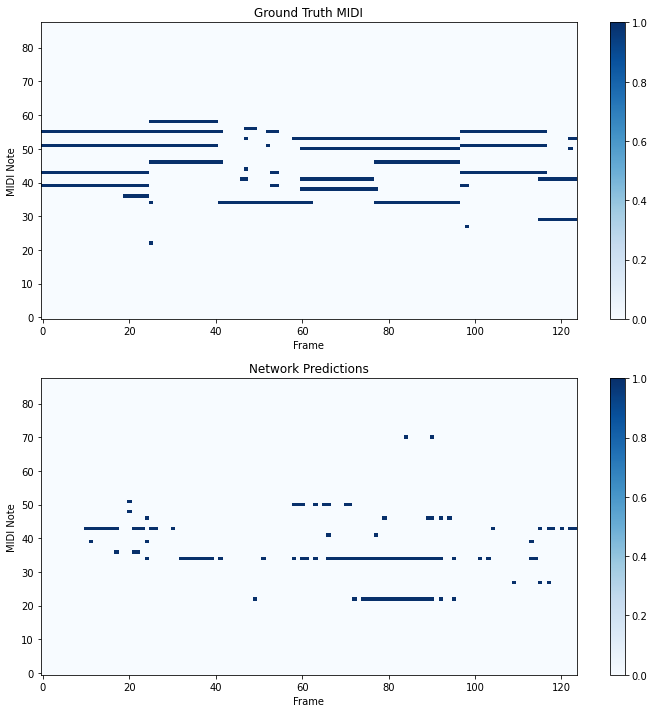

Epoch:45 | batch #525 | Val Acc:0.9324467456826326 | Val Loss:0.7243106365203857
Computing epoch 46...
Epoch:46 | batch #525 | Train Acc:0.8988316314062277 | Train Loss:0.47737181186676025


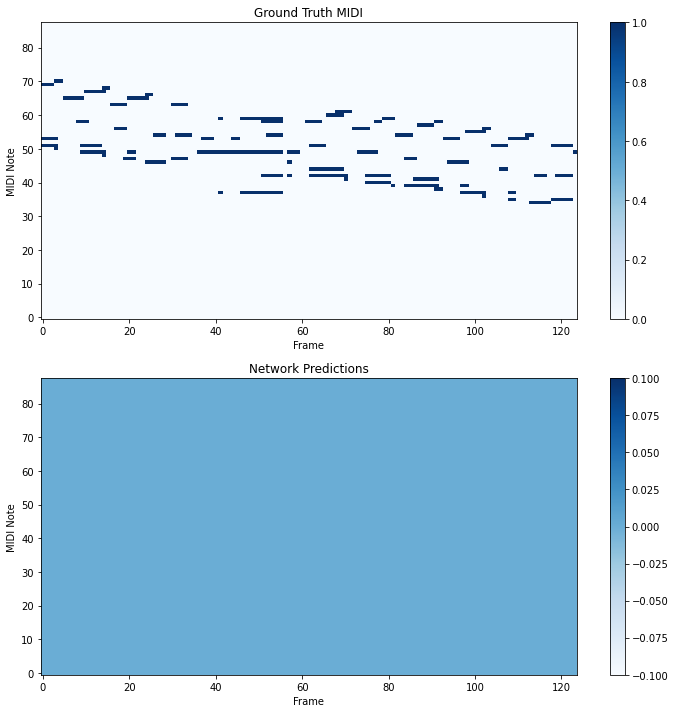

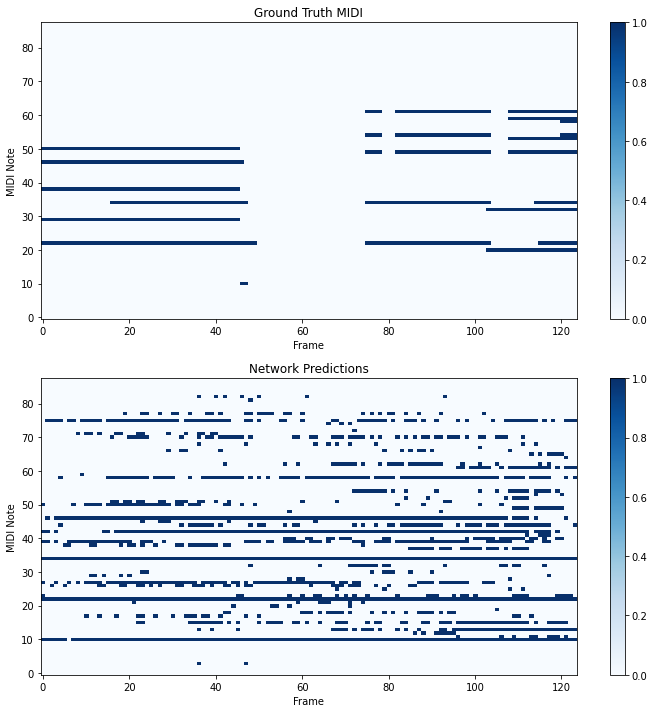

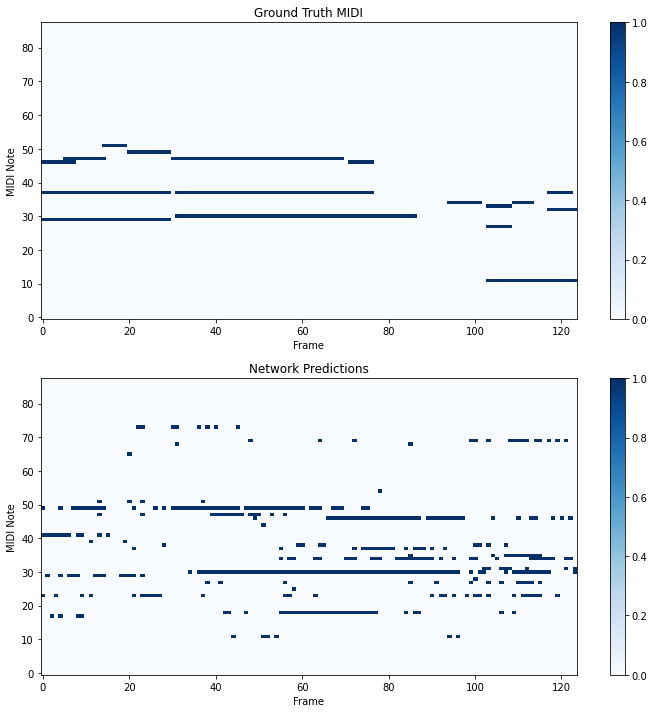

Epoch:46 | batch #525 | Val Acc:0.9211597833170414 | Val Loss:0.6453356742858887
Computing epoch 47...
Epoch:47 | batch #525 | Train Acc:0.8996803489968815 | Train Loss:0.5401240587234497


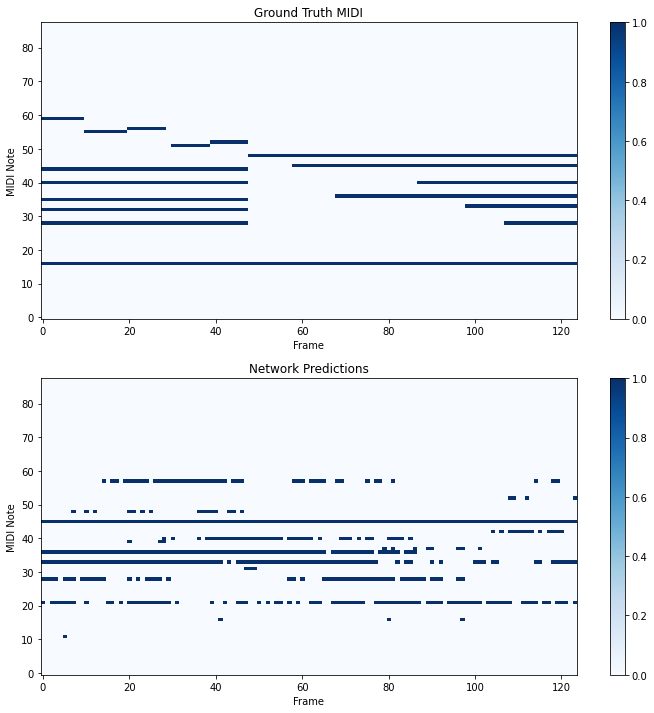

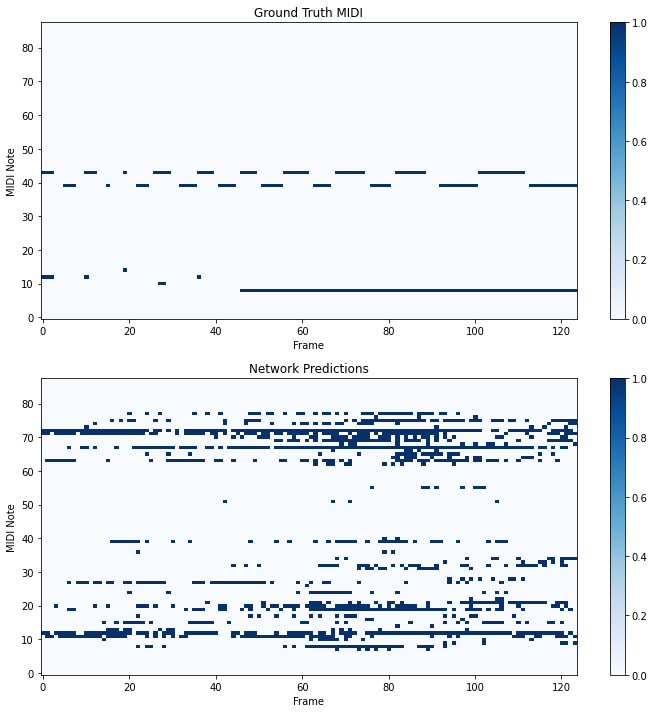

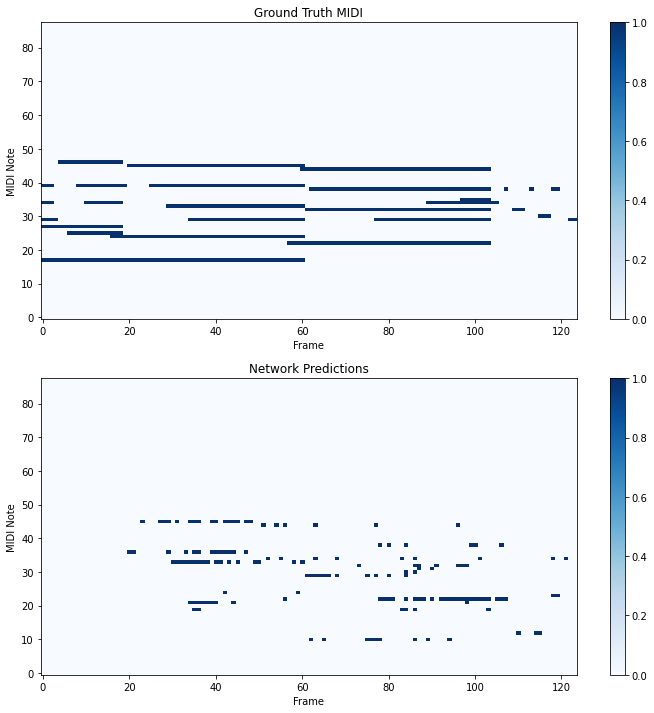

Epoch:47 | batch #525 | Val Acc:0.9272385141739983 | Val Loss:0.9923755526542664
Computing epoch 48...
Epoch:48 | batch #525 | Train Acc:0.9004367086766286 | Train Loss:0.5646823644638062


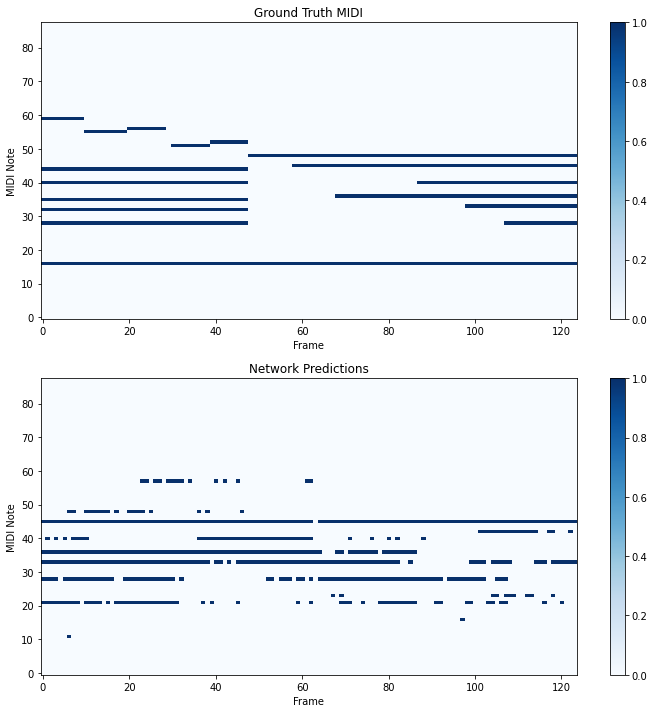

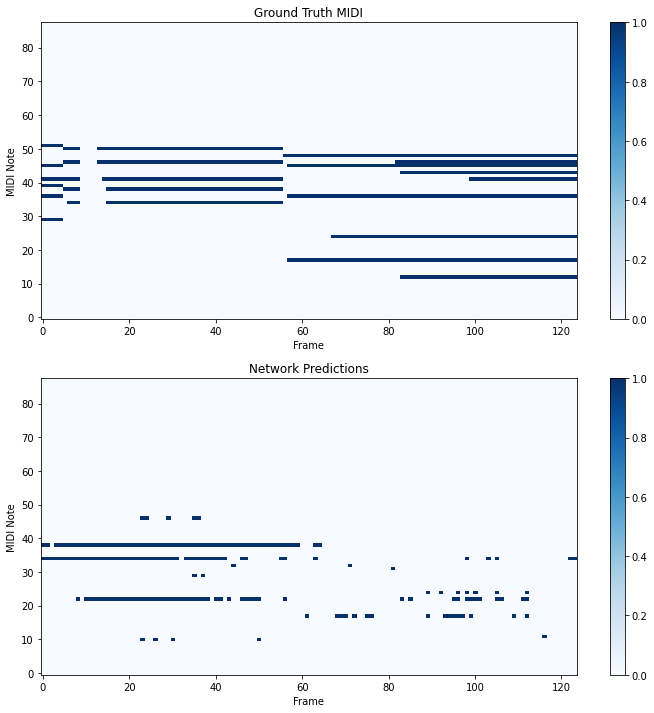

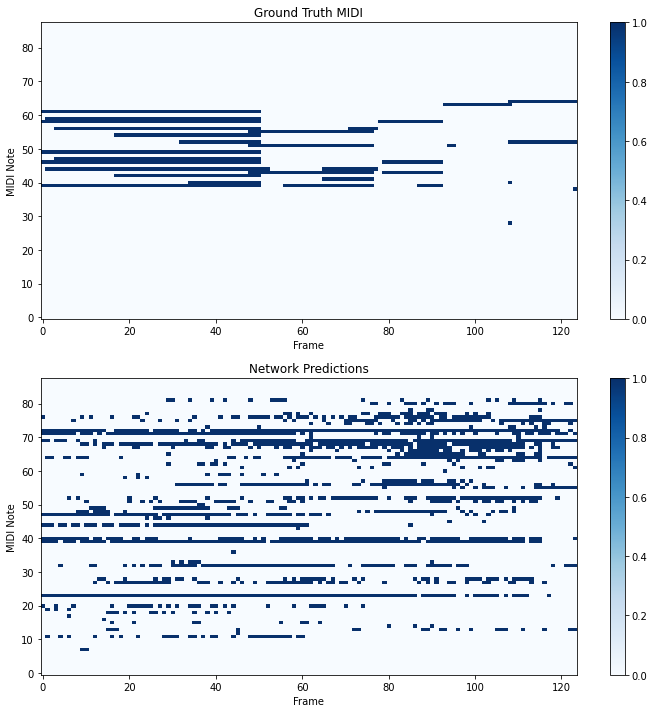

Epoch:48 | batch #525 | Val Acc:0.9338636363636366 | Val Loss:0.7051259279251099
Computing epoch 49...
Epoch:49 | batch #525 | Train Acc:0.899821757319741 | Train Loss:0.4863857924938202


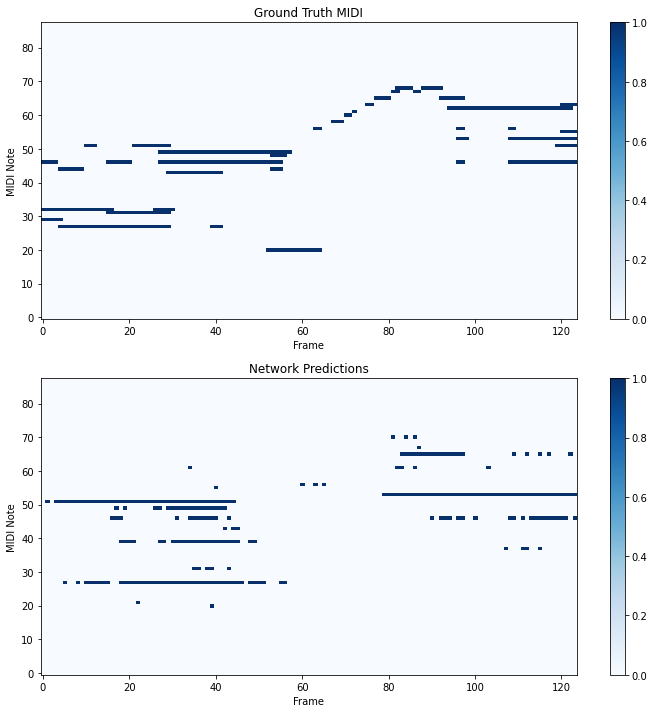

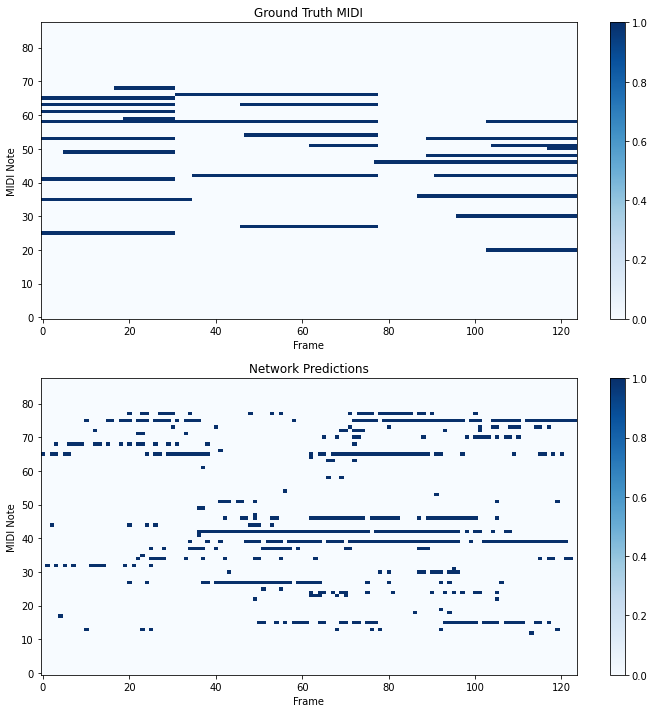

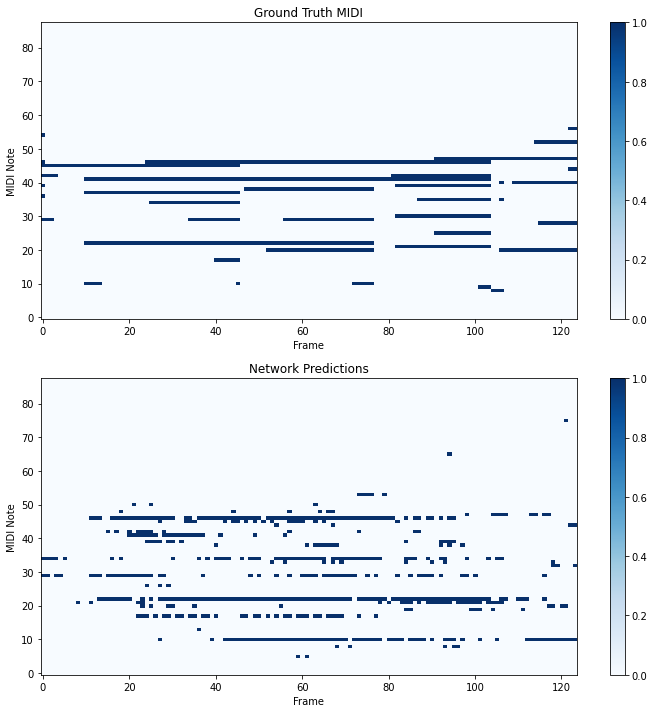

Epoch:49 | batch #525 | Val Acc:0.9354390681003585 | Val Loss:0.9671371579170227
Training Loop Complete
Testing network...


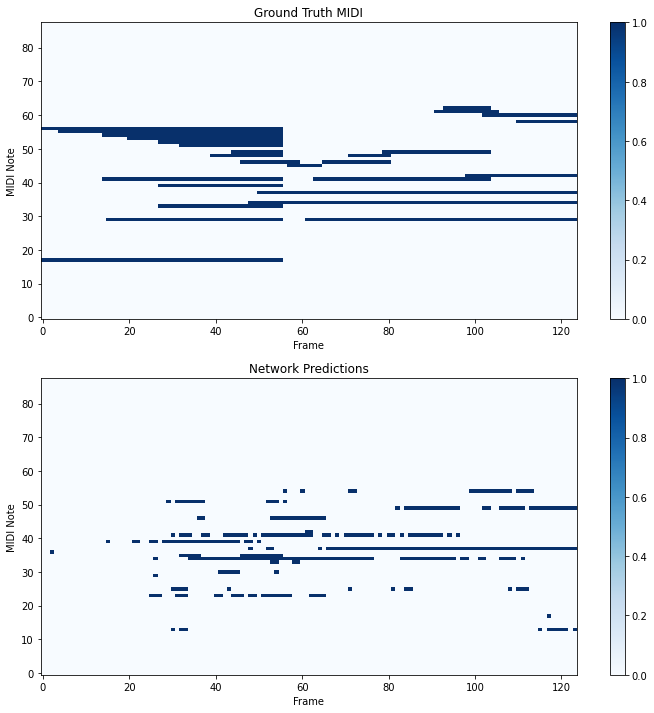

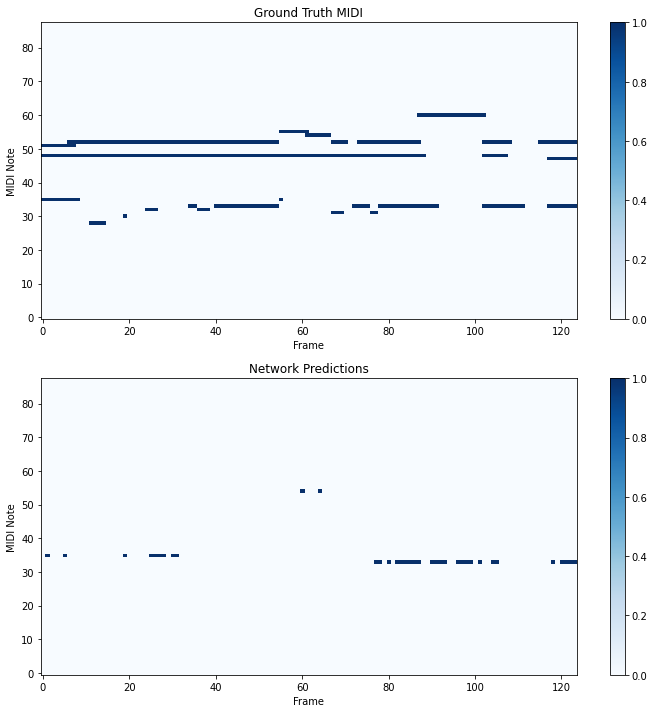

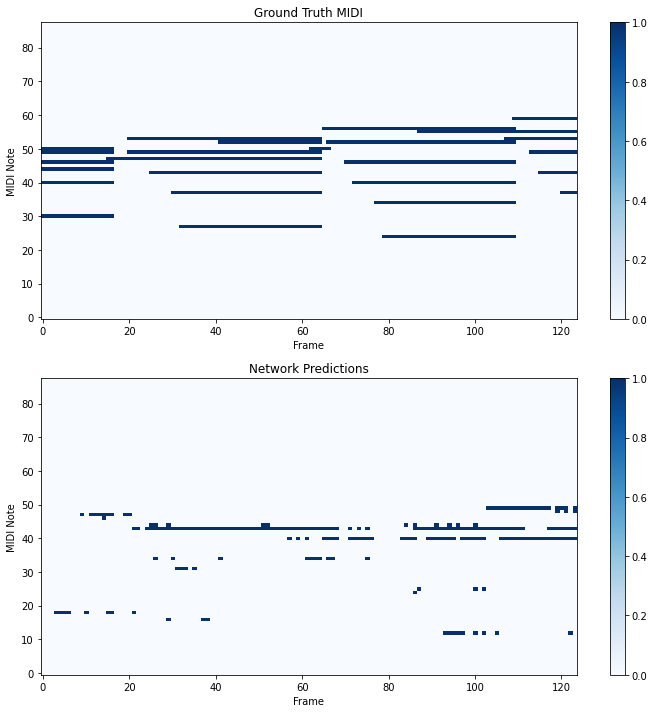

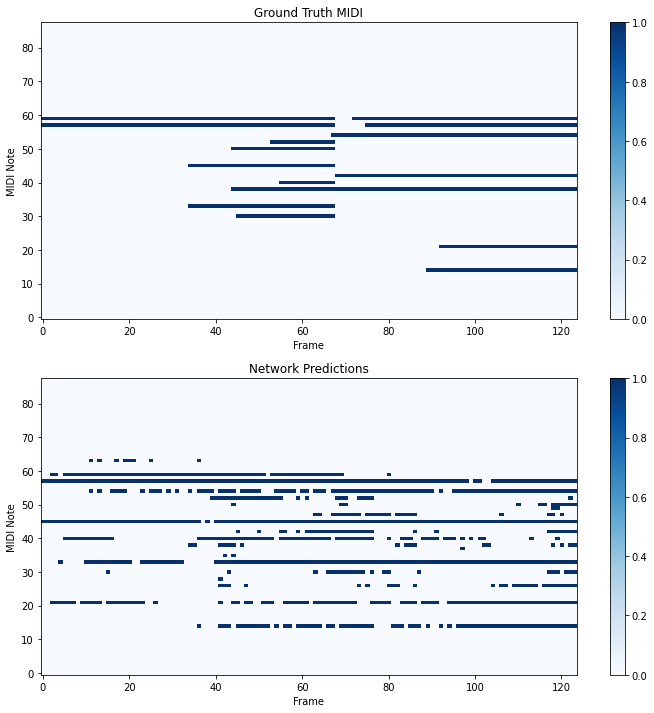

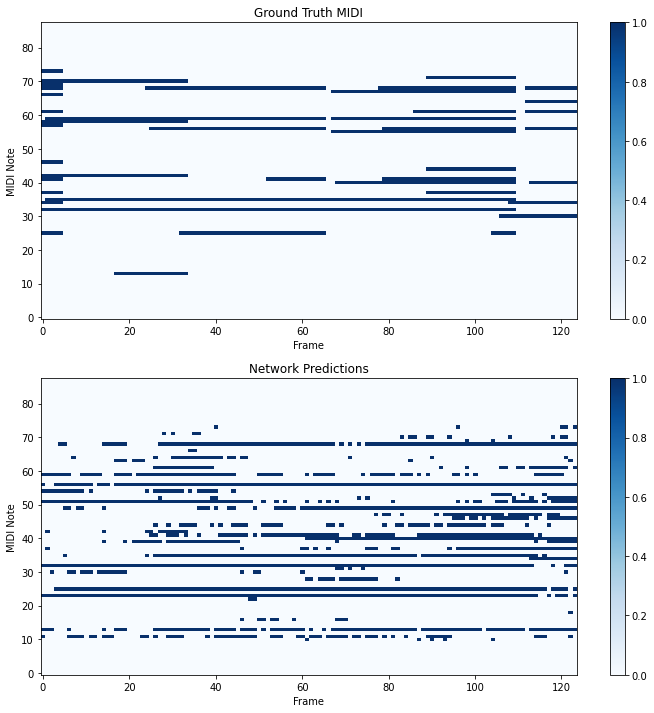

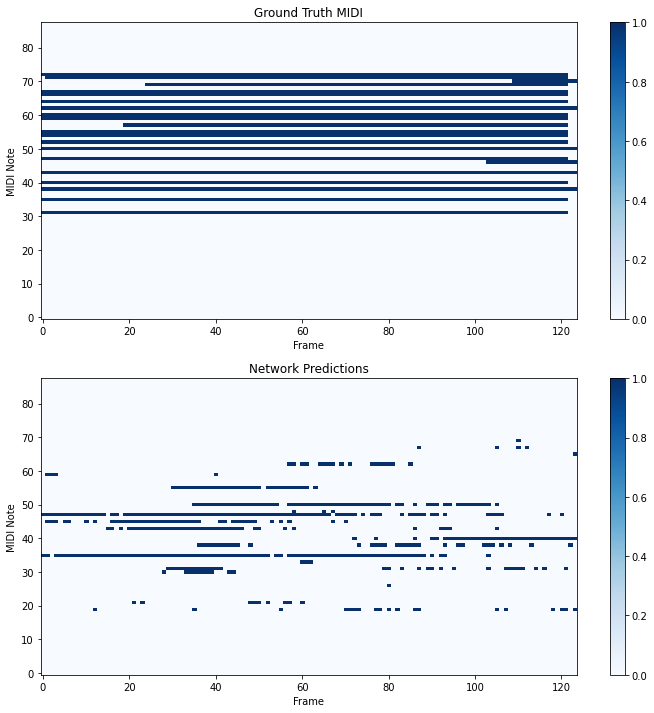

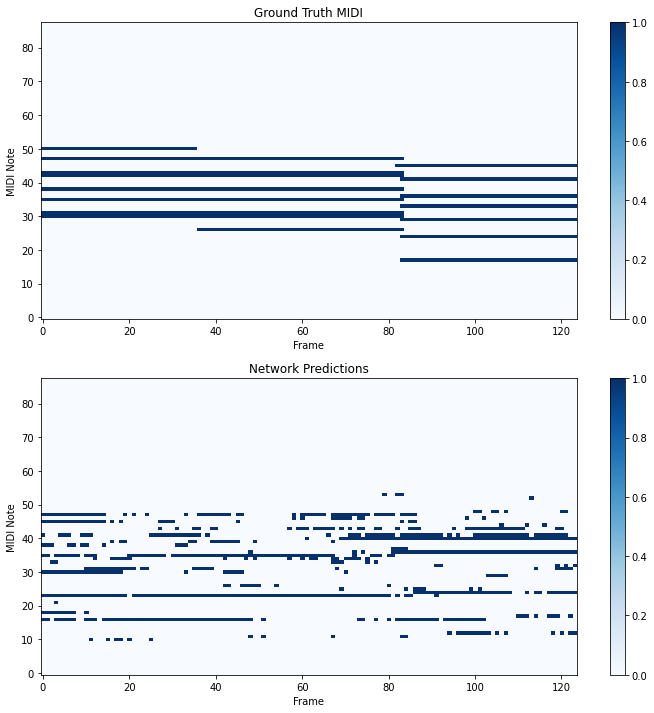

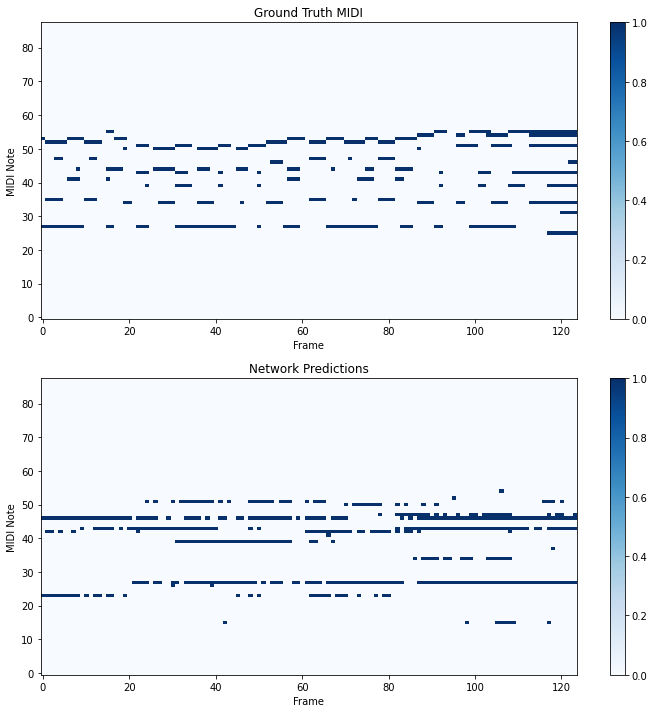

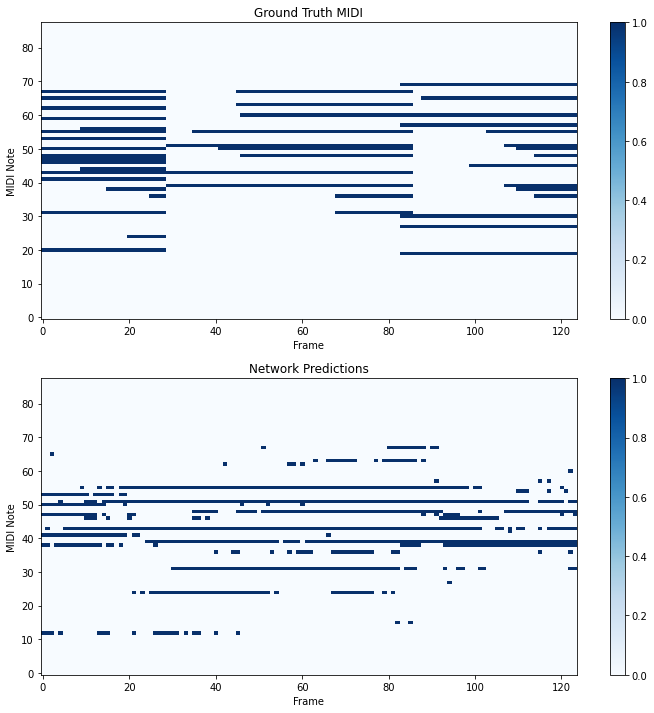

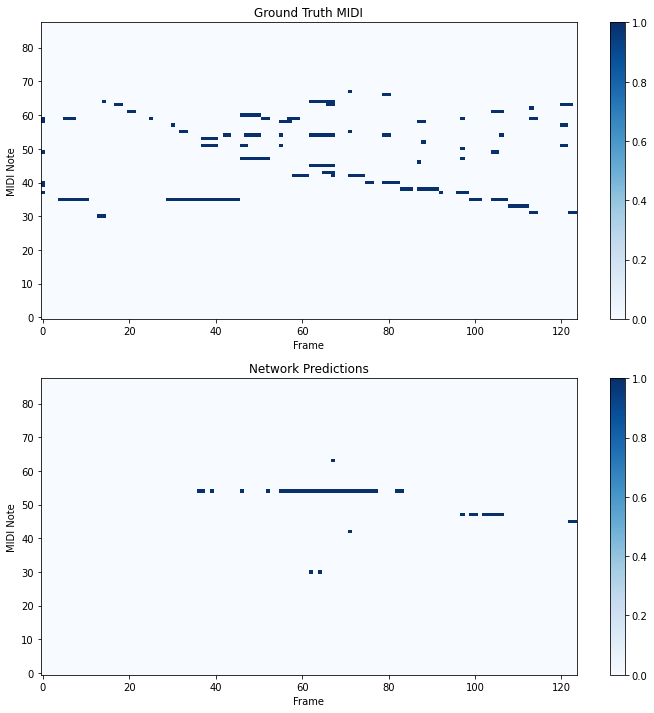

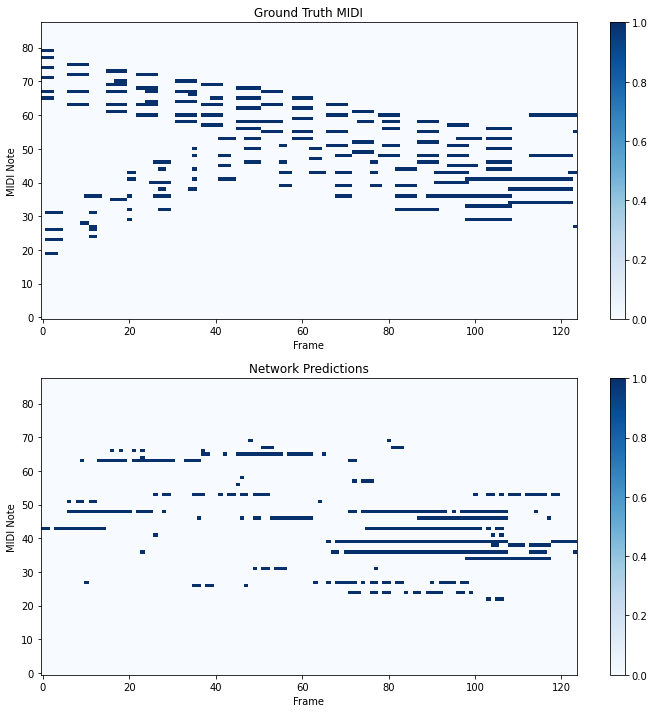

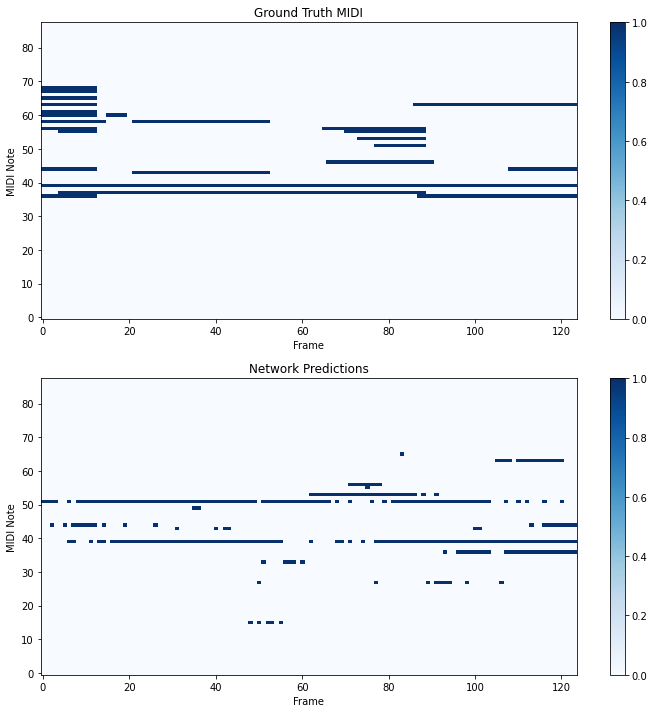

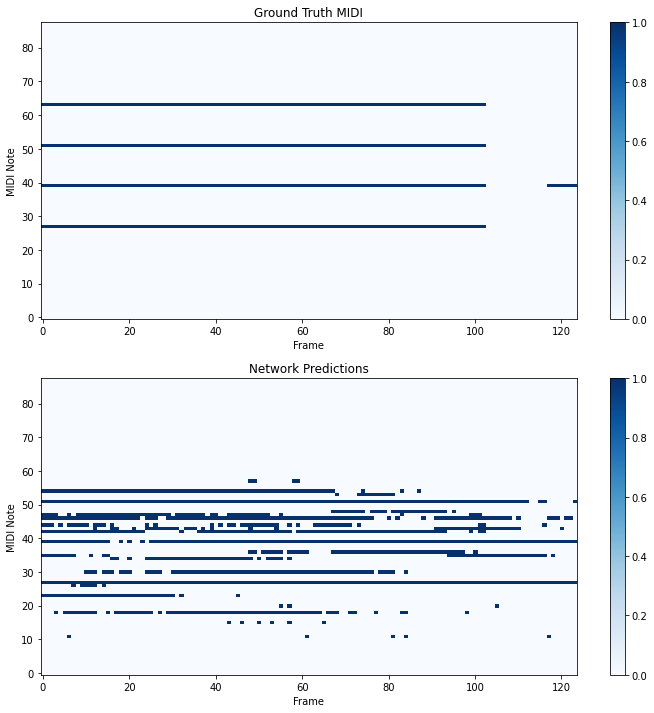

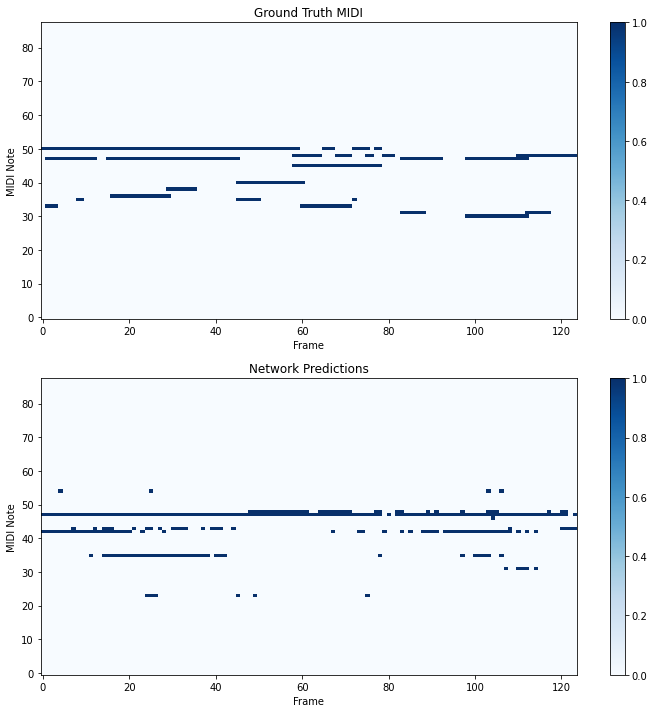

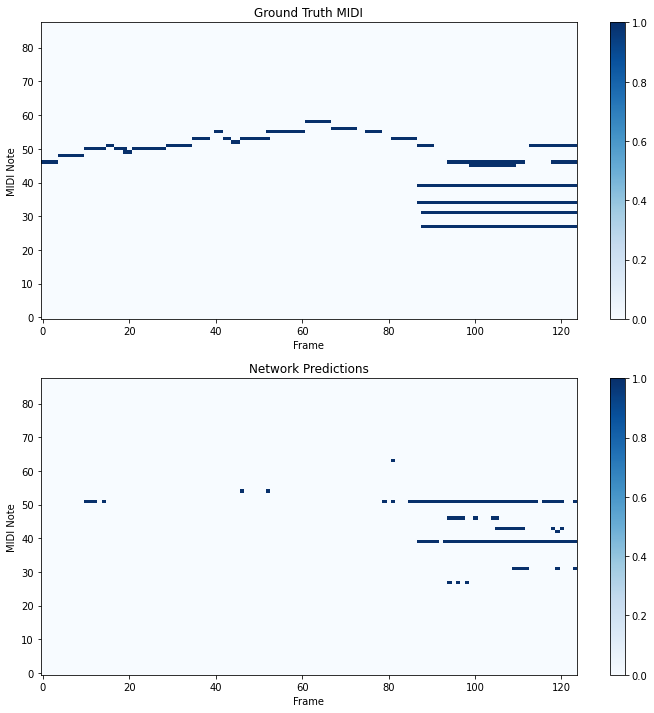

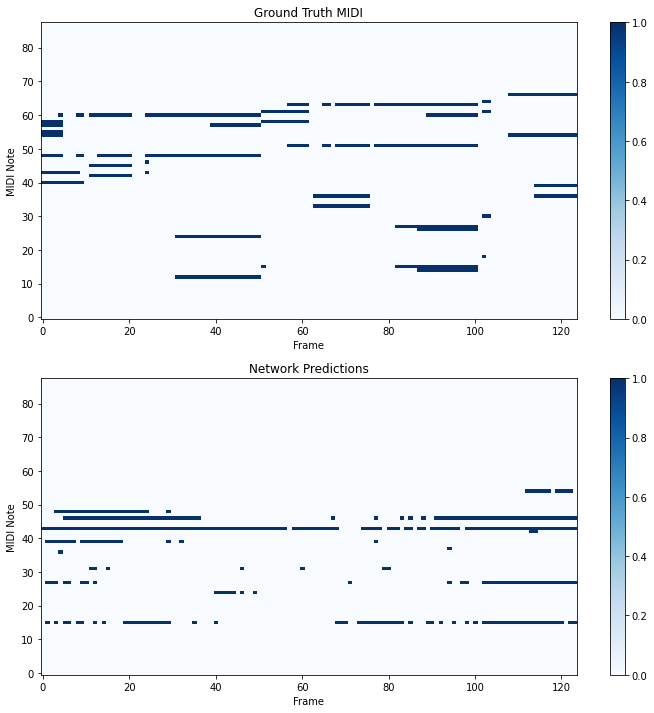

Test Acc:0.9318642000126132 | Test Loss:0.6309771537780762
Saving current model...


In [15]:
torch.cuda.empty_cache()
trainLossRec, trainAccRec, trainTimeSteps, valLossRec, valAccRec, valTimeSteps, testData = trainNetWithAcc(numOfEpochs=50, batchSize=15, learningRate=0.005, modelVer="Mk5", lossFuncType="BCE", optimizerType="RMSprop")

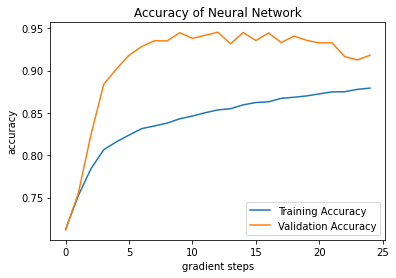

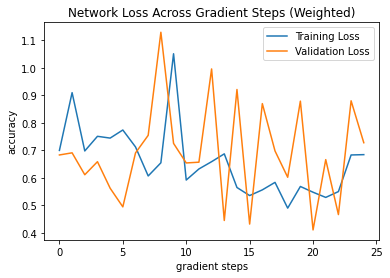

In [14]:
plt.figure()
plt.plot(trainAccRec, label='Training Accuracy')
plt.plot(valAccRec, label='Validation Accuracy')
plt.xlabel("gradient steps")
plt.ylabel("accuracy")
plt.legend()
plt.title("Accuracy of Neural Network")
plt.savefig("Accuracies (numOfEpochs=50, batchSize=8, learningRate=0.005, modelVer=Mk5, lossFuncType=BCE, optimizerType=RMSprop).png")
plt.show()

plt.figure()
plt.plot(trainLossRec, label='Training Loss')
plt.plot(valLossRec, label='Validation Loss')
plt.xlabel("gradient steps")
plt.ylabel("accuracy")
plt.legend()
plt.title("Network Loss Across Gradient Steps (Weighted)")
plt.savefig("Loss (numOfEpochs=50, batchSize=8, learningRate=0.005, modelVer=Mk5, lossFuncType=BCE, optimizerType=RMSprop).png")
plt.show()

In [ ]:
windowSizes = [1, 5, 11, 123]
for size in windowSizes:
    torch.cuda.empty_cache()
    trainLossRec, trainAccRec, trainTimeSteps, valLossRec, valAccRec, valTimeSteps, testData = trainNetWithAcc(numOfEpochs=1, batchSize=15, learningRate=0.005, modelVer="Mk3", lossFuncType="BCE", optimizerType="RMSprop", accuracyType="frame", windowSize=size)

    plt.figure()
    plt.plot(trainTimeSteps, trainAccRec, label='Training Accuracy')
    plt.plot(valTimeSteps, valAccRec, label='Validation Accuracy')
    plt.xlabel("gradient steps")
    plt.ylabel("accuracy")
    plt.legend()
    plt.title("Accuracy of Neural Network With Window Size " + str(size))
    plt.savefig("Accuracies_AccType2_WindowSize" + str(size) + ".png")
    plt.show()

    plt.figure()
    plt.plot(trainTimeSteps, trainLossRec, label='Training Loss')
    plt.plot(valTimeSteps, valLossRec, label='Validation Loss')
    plt.xlabel("gradient steps")
    plt.ylabel("accuracy")
    plt.legend()
    plt.title("Network Loss Across Gradient Steps With Window Size " + str(size))
    plt.savefig("Loss_WindowSize" + str(size) + ".png")
    plt.show()

In [ ]:
torch.cuda.empty_cache()
trainLossRec2, trainAccRec2, trainTimeSteps2, valLossRec2, valAccRec2, valTimeSteps2, testData = trainNetWithAcc(numOfEpochs=1, batchSize=15, learningRate=0.005, modelVer="Mk3", lossFuncType="BCE", optimizerType="RMSprop", accuracyType="frame")

In [ ]:
plt.figure()
plt.plot(trainAccRec2, trainTimeSteps2, label='Training Accuracy')
plt.plot(validAccRec2, trainTimeSteps2, label='Validation Accuracy')
plt.xlabel("gradient steps")
plt.ylabel("accuracy")
plt.legend()
plt.title("Accuracy of Neural Network")
plt.savefig("Accuracies_AccType1.png")
plt.show()

plt.figure()
plt.plot(trainLossRec2, trainTimeSteps2, label='Training Loss')
plt.plot(validLossRec2, trainTimeSteps2, label='Validation Loss')
plt.xlabel("gradient steps")
plt.ylabel("accuracy")
plt.legend()
plt.title("Network Loss Across Gradient Steps")
plt.savefig("Loss.png")
plt.show()


In [ ]:
net = amtNetMk4()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
inp = torch.randn(1, 229, 126)
summary(net.to(device), (1, 229, 126))

Qualitative Results

In [ ]:
# Load model

net = amtNetMk4() # I think this is the right one
net.load_state_dict(torch.load("Net.pt"))
net.eval()

In [ ]:
# Load sample spectrogram and midi

path = "MAESTRO/test/"

data_list = os.listdir(path+'data')

In [ ]:
data_sample_path = data_list[random.randint(0,len(data_list)-1)]
data_sample = np.load(path+'data/'+data_sample_path)

midi = pretty_midi.PrettyMidi(path+'labels/'+data_sample_path[:-4]+'.mid')
label_sample = midi.get_piano_roll(fs=31)[:,:124]

# Disregard code below this cell
Destructuring trainNet function so I don't need to recompute heavy portions of code everytime, will merge into unified function later

In [5]:
class amtNetMk3(nn.Module): 
    def __init__(self, num_kernels=40):
        super().__init__() 
        self.n_layers = 1
        self.hidden_size=100
        
        self.cnn = nn.Sequential(
            # input batchsizex1x229x126
            nn.Conv2d(1, 10, (3, 3), padding=0),
            nn.BatchNorm2d(10), 
            nn.ReLU(), 
            # current shape batchsizex10x229x124
            nn.Conv2d(10, 10, (3, 3), padding=1), 
            nn.BatchNorm2d(10), 
            nn.ReLU(), 
            nn.MaxPool2d((4, 1)), 
            nn.Dropout(0.25), 
            # current shape batchsizex10x57x124
            nn.Conv2d(10, 10, (3, 3), padding=1), 
            nn.BatchNorm2d(10), 
            nn.ReLU(), 
            nn.MaxPool2d((4, 1)), 
            nn.Dropout(0.25), 
            # current shape 10x14x124
        )
    
        self.fc1 = nn.Sequential(
            #input shape is 1x34720
            nn.Linear((124*14*10), int(124*88*1.5)),
            nn.Dropout(0.5),
            nn.BatchNorm1d(int(124*88*1.5)),
            nn.Sigmoid(),
        )
        
        # input shape is 248x110
        self.rnn = nn.GRU(input_size=int(88*1.5), hidden_size=100)
        
        self.fc2 = nn.Sequential(
            nn.Linear(124*100, 124*88), 
            nn.Dropout(0.5),
            nn.BatchNorm1d(124*88),
            nn.Sigmoid(),
        )
        
    def forward(self, x):
        batch_size = x.size(0)
        #print(x.shape)
        x = self.cnn(x)
        #print(x.shape)
        #x = x.transpose(1, 3).flatten(-3)
        x = x.view(batch_size, -1)
        #print(x.shape)
        x = self.fc1(x)
        #print(x.shape)
        x = x.reshape(batch_size, int(88*1.5), 124) 
        #print(x.shape)
        x = x.transpose(1, 2)
        #print(x.shape)
        x, a = self.rnn(x)
        # print(x.shape)
        # print(a.shape)
        x = x.transpose(1, 2).flatten(-2)
        #print(x.shape)
        x = self.fc2(x)
        #print(x.shape)
        x = x.reshape(batch_size, 88, 124)
        #print(x.shape)
        return x, a
    
    def init_hidden(self, batch_size, device):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, 124, self.hidden_size).zero_().to(device)
        return hidden

In [30]:
def trainNet(numOfEpochs = 5, batchSize = 10, learningRate = 0.001, modelVer = "Mk2", lossFuncType = "BCE", optimizerType = "RMSprop"):
    torch.manual_seed(324)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Running through " + str(device))

    print("Initializing dataloaders...")
    trainLoader, valLoader, testLoader = getLoader(batchSize)

    print("Initializing models...")
    net, lossFunc, optimizer = getModels(learningRate, modelVer, lossFuncType, optimizerType)
    net.to(device)
    
    lossRec = [] 
    N = 0

    torch.cuda.empty_cache()
    for epoch in range(0, numOfEpochs, 1):
        N = 0
        print("Computing epoch " + str(epoch) + "...")
        for data in trainLoader:  
            net.train()
            inputs = (data[0].unsqueeze(1)).to(device)
            labels = data[1].to(device)
            optimizer.zero_grad()
            preds, finalH = net(inputs.float())
            print(preds)
            loss = lossFunc(input=preds, target=labels.float())
            loss.backward() 
            optimizer.step()
            if N%10 == 0: 
                print("Epoch:" + str(epoch) + " | batch #" + str(N) + " | Loss:" + str(loss))
            N += 1
        torch.save(net.state_dict(), "Net.pt")

    return True

In [6]:
class amtNetMk4(nn.Module): 
    def __init__(self, num_kernels=40):
        super().__init__() 
        self.n_layers = 1
        self.hidden_size=100
        
        self.cnn = nn.Sequential(
            # input batchsizex1x229x126
            nn.Conv2d(1, 20, (3, 3), padding=0),
            nn.BatchNorm2d(20), 
            nn.ReLU(), 
            # current shape batchsizex20x229x124
            nn.Conv2d(20, 20, (3, 3), padding=1), 
            nn.BatchNorm2d(20), 
            nn.ReLU(), 
            nn.MaxPool2d((4, 1)), 
            nn.Dropout(0.25), 
            # current shape batchsizex20x57x124
            nn.Conv2d(20, 20, (3, 3), padding=1), 
            nn.BatchNorm2d(20), 
            nn.ReLU(), 
            nn.MaxPool2d((4, 1)), 
            nn.Dropout(0.25), 
            # current shape 20x14x124
        )
    
        self.fc1 = nn.Sequential(
            #input shape is 1x34720
            nn.Linear((124*14*20), int(124*88*1.5)),
            nn.Dropout(0.5),
            nn.BatchNorm1d(int(124*88*1.5)),
            nn.Sigmoid(),
        )
        
        # input shape is 248x110
        self.rnn = nn.GRU(input_size=int(88*1.5), hidden_size=100)
        
        self.fc2 = nn.Sequential(
            nn.Linear(124*100, 124*88), 
            nn.Dropout(0.5),
            nn.BatchNorm1d(124*88),
            nn.Sigmoid(),
        )
        
    def forward(self, x):
        batch_size = x.size(0)
        #print(x.shape)
        x = self.cnn(x)
        #print(x.shape)
        #x = x.transpose(1, 3).flatten(-3)
        x = x.view(batch_size, -1)
        #print(x.shape)
        x = self.fc1(x)
        #print(x.shape)
        x = x.reshape(batch_size, int(88*1.5), 124) 
        #print(x.shape)
        x = x.transpose(1, 2)
        #print(x.shape)
        x, a = self.rnn(x)
        # print(x.shape)
        # print(a.shape)
        x = x.transpose(1, 2).flatten(-2)
        #print(x.shape)
        rawPreds = self.fc2(x).unsqueeze(1)
        print(rawPreds.shape)
        preds = nn.Sigmoid()(rawPreds)
        preds = preds.reshape(batch_size, 88, 124)
        rawPreds = rawPreds.reshape(batch_size, 88, 124)
        #print(x.shape)
        return preds, rawPreds
    
    def init_hidden(self, batch_size, device):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, 124, self.hidden_size).zero_().to(device)
        return hidden


In [4]:
class amtNetMk2(nn.Module): 
    def __init__(self, num_kernels=40):
        super().__init__() 
        self.n_layers = 1
        self.hidden_size=100
        
        self.cnn = nn.Sequential(
            # input batchsizex1x229x251
            nn.Conv2d(1, 10, (4, 4), padding=0),
            nn.BatchNorm2d(10), 
            nn.ReLU(), 
            # current shape batchsizex10x229x248
            nn.Conv2d(10, 10, (3, 3), padding=1), 
            nn.BatchNorm2d(10), 
            nn.ReLU(), 
            nn.MaxPool2d((4, 1)), 
            nn.Dropout(0.25), 
            # current shape batchsizex10x57x248
            nn.Conv2d(10, 10, (3, 3), padding=1), 
            nn.BatchNorm2d(10), 
            nn.ReLU(), 
            nn.MaxPool2d((4, 1)), 
            nn.Dropout(0.25), 
            # current shape 10x14x248
        )
    
        self.fc1 = nn.Sequential(
            #input shape is 1x34720
            nn.Linear((248*14*10), 24552),
            nn.Dropout(0.5),
            nn.BatchNorm1d(24552),
            nn.Sigmoid(),
        )
        
        # input shape is 248x110
        self.rnn = nn.GRU(input_size=99, hidden_size=90)
        
        self.fc2 = nn.Sequential(
            nn.Linear(248*90, 248*88), 
            nn.Dropout(0.5),
            nn.BatchNorm1d(248*88),
            nn.Sigmoid(),
        )
        
    def forward(self, x):
        batch_size = x.size(0)
        #print(x.shape)
        x = self.cnn(x)
        #print(x.shape)
        #x = x.transpose(1, 3).flatten(-3)
        x = x.view(batch_size, -1)
        #print(x.shape)
        x = self.fc1(x)
        #print(x.shape)
        x = x.reshape(batch_size, 99, 248) 
        #print(x.shape)
        x = x.transpose(1, 2)
        #print(x.shape)
        x, a = self.rnn(x)
        #print(x.shape)
        #print(a.shape)
        x = x.transpose(1, 2).flatten(-2)
        #print(x.shape)
        x = self.fc2(x)
        #print(x.shape)
        x = x.reshape(batch_size, 88, 248)
        #print(x.shape)
        return x, a
    
    def init_hidden(self, batch_size, device):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, 248, self.hidden_size).zero_().to(device)
        return hidden

In [ ]:
batchSize = 8
trainLoader, valLoader, testLoader = getLoader(batchSize)

In [ ]:
for data, labels in (trainLoader):
    print(data)
    break

In [ ]:
net = amtNetMk2()
torch.save(net.state_dict(), "Net.pt")
print("done")

In [ ]:
torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

inp = torch.randn(10, 1, 229, 251)


# if torch.cuda.is_available():
#     model.cuda()

#out, res = model(inp)
res = model(inp)

In [ ]:
print(model)

In [ ]:
class amtNetMk1(nn.Module): 
    def __init__(self, num_kernels=40):
        super().__init__() 
        
        self.cnn = nn.Sequential(
            # input batchsizex1x229x626
            nn.Conv2d(1, 10, (3, 3), padding=1),
            nn.BatchNorm2d(10), 
            nn.ReLU(), 
            # current shape batchsizex229x10x626
            nn.Conv2d(10, 10, (3, 3), padding=1), 
            nn.BatchNorm2d(10), 
            nn.ReLU(), 
            nn.MaxPool2d((4, 1)), 
            nn.Dropout(0.25), 
            # current shape batchsizex57x626x10
            nn.Conv2d(10, 20, (3, 3), padding=1), 
            nn.BatchNorm2d(20), 
            nn.ReLU(), 
            nn.MaxPool2d((4, 1)), 
            nn.Dropout(0.25), 
            # current shape 14x626x20
        )
    
        self.fc1 = nn.Sequential(
            nn.Linear((626*20*14), 3130),
            nn.Dropout(0.5),
            # Code calls for another batch norm here but unsure what to specifically normalize here
            nn.Sigmoid(),
        )
        
        self.rnn = nn.GRU(input_size=626, hidden_size=626) # hidden_size is num of features 
        
        self.fc2 = nn.Sequential(
            nn.Linear((626*5), 626*3), 
            nn.Sigmoid(),
        )
        
    def forward(self, x):
        batch_size = x.size(0)
        print(batch_size)
        print(x.shape)
        x = self.cnn(x)
        print(x.shape)
        x = x.transpose(1, 3).flatten(-3)
        print(x.shape)
        x = self.fc1(x)
        print(x.shape)
        x = x.reshape(batch_size, 5, 626) 
        print(x.shape)
        a, x = self.rnn(x)
        print(x.shape)
        print(a.shape)
        x = x.transpose(1, 2).flatten(-2)
        print(x.shape)
        print(a.shape)
        x = self.fc2(x)
        print(x.shape)
        x = x.reshape(batch_size, 3, 626)
        print(x.shape)
        return x

In [4]:
pos_weight = torch.tensor([1, 95], dtype=torch.float64)
pos_weight

tensor([ 1., 95.], dtype=torch.float64)

The mean and standard deviation I got for the training data was -32.1196136474609375 and 21.2591381072998046875 respectively.

In [20]:
output = torch.randn(1, 1, 10, 10, requires_grad=True)
target = torch.randint(0, 2, (1, 1, 10, 10)).float()
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(10.))
loss = criterion(output, target)
print(loss)

output = torch.randn(1, 1, 10, 10, requires_grad=True)
target = torch.randint(0, 2, (1, 1, 10, 10)).float()
criterion = nn.BCEWithLogitsLoss()
loss = criterion(output, target)
print(loss)

print(output)
print(target)
print(torch.tensor(10.))

tensor(4.6382, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.8233, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor([[[[ 0.7819, -1.5988,  1.7838,  1.5292, -0.0660, -0.4148,  1.1004,
           -0.3710,  1.5186, -1.3940],
          [ 0.3773,  1.5022, -0.3660, -0.1532, -1.0761,  0.4162,  2.0068,
            0.1461,  0.3282, -0.0681],
          [ 2.0113,  0.4270, -0.8851, -1.2748, -2.0522,  0.0207, -0.3848,
           -1.1183, -0.7358,  0.8559],
          [ 1.7764,  1.3371,  0.4911,  2.4928,  0.8247, -0.1144, -1.2871,
           -0.7876,  0.4151, -1.1599],
          [ 0.5985,  0.6611,  1.5990,  1.5582,  0.3014, -1.4748,  2.3274,
            0.6226,  1.8622,  1.5430],
          [ 1.0274,  1.3426, -0.7369, -3.7341,  0.7835, -0.8930,  0.5068,
            0.3440, -0.1392, -1.7713],
          [ 0.6363, -1.1197, -1.3520, -0.5569,  0.2451, -1.6538, -0.4976,
           -1.4852, -2.1561,  0.4421],
          [-0.0374,  0.4740, -0.0746,  1.3639,  0.4397,  0.4600, -0.3670,
         

In [10]:
torch.tensor(124.)

tensor(124.)